<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu_20L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take this file to Colab in case you are not executing the code, but only reading it. You can take adavantage of  collapsible, hierarchical structure of notebook.

In [ ]:
"""
# Last amended: 12th Feb, 2024
# Click through rate prediction
# Predict whether a mobile ad will be clicked
# Data Source:
#   https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

### Cleanup
Delete all earlier saved work. Start afresh. Commented to avoid deleteion by mistake.

In [ ]:
# -0.2 WARN Will delete all earlier work

#   Delete all saved avazu data
"""
from pathlib import Path
import shutil
avazufolder = Path("C:\\avazu\\allmodels\\")

if avazufolder.exists():
    shutil.rmtree(avazufolder)
"""

## Basics
Package installations, calling libraries and creating folders to save work

In [ ]:
# 0.1 Install from pypi:
%reset
!pip install catencfamily==0.1.15

In [ ]:
# 0.2 Easy to format columns into tables:
#     Used pandas also

! pip install python-tabulate

In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time


# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.calibration import CalibrationDisplay,CalibratedClassifierCV
from sklearn.metrics import classification_report,f1_score,roc_auc_score,accuracy_score,log_loss
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef,PrecisionRecallDisplay,brier_score_loss
from sklearn.metrics import RocCurveDisplay, roc_curve,precision_recall_curve,auc

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, metrics, cv
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils



# 1.0.5
from tabulate import tabulate
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Create folders to save our work
We save data and results so that next time, work can continue from that point onwards.

In [ ]:
# 1.0.7 Our folders to save work and results:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [ ]:
# 1.0.7 Our folders (alternative place):
#       You can substitute below with your
#         own alternative place (for example colab
#           VM foders such as /content/) BUT do not
#             change folder names as these are used
#              throughout the code.

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [ ]:
# 1.0.8 Create all these folders, if not already existing:

avazufolder.mkdir(parents=True, exist_ok=True)
avazugraphs.mkdir(parents=True, exist_ok=True)
avazudata.mkdir(parents=True, exist_ok=True)
avazuestimators.mkdir(parents=True, exist_ok=True)
avazuunitvecs.mkdir(parents=True, exist_ok=True)


In [ ]:
# 1.0.9 Decide program-wide random state:
#       Yes, if we discontinue in between
#       and restart from some other point
#       in the notebook, this would change.

rng= np.random.RandomState(None)

### Taking a sample of data
We take a sample of 20lakh observations (limited by RAM that we have)


In [ ]:
## 1.1 We will extract data randomly from disk using the following code:

dataPath = "c:\\avazu\\"

dtypes = {
        'C1'              : 'uint16',
        'banner_pos'      : 'uint8',
        'device_type'     : 'uint8',
        'device_conn_type': 'uint8',
        'C14'             : 'uint16',
        'C15'             : 'uint16',
        'C16'             : 'uint16',
        'C17'             : 'uint16',
        'C18'             : 'uint8',
        'C19'             : 'uint16',
        'C20'             : 'int32',
        'click'           : 'uint8'
        }

print('load train...')


# 1.2 Read a fraction of data
total_lines = 40428967   #  (40428967, 24)
read_lines =   2000000

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read
from datetime import datetime
#parse_date = lambda val : pd.to_datetime.datetime.strptime(val, '%y%m%d%H')
parse_date = lambda val : pd.to_datetime(val,format = '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.gz",
                     header=0,
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),
                     dtype=dtypes,
                     parse_dates=['hour'],
                     date_parser=parse_date
                    )   # Takes 2minutes

_= gc.collect()

In [ ]:
# 1.3.1
train.shape   # (2001493, 24)/(1998733, 24)/(1999324, 24)/(1999503, 24)/(2001360, 24)/(1999592, 24)
train.head(3)

In [ ]:
# 1.3.2 Imbalanced data:

train['click'].value_counts()
print("\n")
train['click'].value_counts(normalize = True)  # 83%:17%

# 1.3.3
train.dtypes

In [ ]:
# 1.3.4 Separate target, and drop id

y = train.pop("click")
_= train.pop("id")

### Prepare data for transformation
Check cat cols, column names, null values and label-encode, if neeeded

In [ ]:
# 1.3.5 Our list of columns:

print(list(train.columns))

# 1.1.6 Here is a list of all columns except 'hour'
cols = ["C1","banner_pos","site_id","site_domain","site_category",
        "app_id","app_domain","app_category","device_id","device_ip",
        "device_model", "device_type", "device_conn_type", "C14",
        "C15", "C16","C17", "C18", "C19", "C20", "C21"]

In [ ]:
# 2.0 Check no of unique values in every column
#     Two columns, device_id and device_ip,
#     have very large no of unique values:

u = []
for i in train.columns:
  u.append([i, train[i].nunique()])

# 3.1.1
print(tabulate(u, headers = ["col name", "No of unique values"]))

In [ ]:
# 2.1 Rename columns as per requirement of our CatEncodersFamily class
#     Column names are not to have digits and underscores:

cols = {
        "C1" : "Cone",
        "banner_pos" : "bannerpos",
        "site_id"    :  "siteid",
        "site_domain": "sitedomain",
        "site_category" : "sitecategory",
        "app_id"        : "appid",
        "app_domain"    : "appdomain",
        "app_category"  : "appcategory",
        "device_model"  : "devicemodel",
        "device_type"   : "devicetype",
        "device_ip"     : "deviceip",
        "device_id"      : "deviceid",
        "device_conn_type" : "deviceconntype",
        "C14" : "Cfourteen",
        "C15" : "Cfifteen",
        "C16" : "Csixteen",
        "C17" : "Cseventeen",
        "C18" : "Ceighteen",
        "C19" : "Cnineteen",
        "C20" : "Ctwenty",
        "C21" : "Ctwentyone"
        }

train = train.rename( columns = cols)
train.shape  #    (2001493, 22)/(1998733, 22)/(1999324, 22)/(1999503, 22)
train.head(3)

In [ ]:
 Path(avazudata)

In [ ]:
# 2.1.1 Save this data for quick reading next time:

train.to_pickle(  Path(avazudata) / "train_full_unencoded.pkl" )
y.to_pickle(Path(avazudata) / "y.pkl" )

#### Extract date components

In [ ]:
# 2.2 Extract date components then del 'hour' column:

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour

_=train.pop('hour')
train.head(2)

#### Label Encoding cat cols
xgboost classifier will not accept columns having text data

In [ ]:
# 3.0 Some columns need label encoding for feeding
#     into xgboost classifier. xgboost classifier will
#     not accept columns with text values.

train.iloc[:, :5].head(2)   # siteid, sitedomain,sitecategory
train.iloc[:, 5:10].head(2)   # appid,appdomain,appcategory,device_id,device_ip
train.iloc[:, 10:15].head(2)  # devicemodel


In [ ]:
# 3.0.1 List of cols to label encode:

ColumnsToLabelEncode = ["siteid", "sitedomain", "appid", "appdomain",
                        "appcategory", "deviceid", "deviceip",
                        "devicemodel", 'sitecategory']


# 3.0.2 Check our list once again:

train[ColumnsToLabelEncode[:4]].head(2)
train[ColumnsToLabelEncode[4:]].head(2)


In [ ]:
# 3.1 Label encode columns of train data:
#     Takes time:

dict_ = {}  # To save label encoder objects here for future use
for i in ColumnsToLabelEncode:
    le = LabelEncoder()
    _=le.fit(train[i])
    train[i] = le.transform(train[i])
    dict_[i] = le  # Store the label encoder object
    _=gc.collect()

In [ ]:
# 3.2 Check again if encoding done?

train[ColumnsToLabelEncode[:4]].head(3)
train[ColumnsToLabelEncode[4:]].head(3)

In [ ]:
# 3.2.1 Again save this label encoded data for quick reading next time:

train.to_pickle(Path(avazudata) / "train_full_encoded.pkl" )

#### Partition data

In [ ]:
# 4.0 Split our data

X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 4.0.1 Check shapes:
X_train.shape    # (1501119, 25)/(1499049, 25)/(1499493, 25)/(1499627, 25)/(1499698, 25)/(1499694, 25)
X_test.shape     # (500374, 25)/(499684, 25)/(499831, 25)/(499876, 25)/(499900, 25)/(499898, 25)
y_train.shape    # (1501119,)/(1499049,)/(1499493,)/(1499627,)/(1499694,)
y_test.shape     # (500374,)/(499684, )/(499831,)/(499876,)/(499898,)

In [ ]:
# 4.1 Check nulls. None.:

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()

In [ ]:
# 4.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 83%:17%
y_train.value_counts(normalize = True) # 83%:17%


### Save all data files
This is for future use. Next time we can start from here instead of executing from the beginning.

In [ ]:
# 6.1 Save the dict of LabelEncoder objects for future use:
#     We, however, do not use the saved dict:

utils.savePythonObject( dict_, "labelEnoders.pkl", avazudata)



# 6.2 Also save partitioned data:

X_train.to_pickle(Path(avazudata) / "X_train.pkl")
X_test.to_pickle(Path(avazudata) / "X_test.pkl")
y_train.to_pickle(Path(avazudata) / "y_train.pkl")
y_test.to_pickle(Path(avazudata) / "y_test.pkl")


# 6.3 Finally list all files that we have got here:

list(Path(avazudata).iterdir())

## Data transformation with `CatEncodersFamily` class

### Instantiate and fit `CatEncodersFamily` class

In [ ]:
# 7.0 Which are our cat columns

# 7.1 We cosider all cat features except deviceid and deviceip
#     These two columns as we will shortly see are not important:
#     (But, were we to consider them, we have to merge some rare
#     occurring levels as has been done in the case of talkingData
#     for 'ip'):

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone']   #  exclude: ['deviceid', 'deviceip']

print(f"No of cat_cols is: {len(cat_cols)}")  # 19

# 7.2 Remaining columns are a mix of numeric and cat:

#rem_cols =  set(train.columns).difference(set(cat_cols))
#print(f"Remaining columns are: '{rem_cols}'")

rem_cols = ['day', 'hour_time', 'month', 'dayofweek', 'deviceid', 'deviceip']


# 7.3 As number of cat_cols are quite large
#     Keep interacting columns as null

interactingCatCols = []


In [ ]:
# 8.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0],
                        modelsPath = avazugraphs , # Folder to store graph files
                                                    # Will be created if it does not exist
                        verbose = 0,  # quiet mode
                        pathToStoreProgress  = avazufolder , # Progress recorded in *.csv files
                        saveGraph = True,   # Save all generated *.gml files
                        cutoff = 4  # transform those cat features having levels 5 or more
                       )

# 8.0.1 Fit it on X_train:

gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 71 minutes

Bipartite Network created. Time taken:  0.04600536823272705 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.00852732261021932 minutes
Model saved
Done with Cfifteen  and  Cone
Time taken:  0.05500865379969279
Entry made in file progress.csv



Next:  200  of  306 Cfifteen bannerpos
No of unique values in  Cfifteen  are:  8
Bipartite Network created. Time taken:  0.04531128803888957 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.008672300974527996 minutes
Model saved
Done with Cfifteen  and  bannerpos
Time taken:  0.054621036847432455
Entry made in file progress.csv



Next:  201  of  306 Cfifteen siteid
No of unique values in  Cfifteen  are:  8
Bipartite Network created. Time taken:  0.04728243350982666 minutes
Bipartite Network projected. Time taken:  0.0002603809038798014 minutes
Model extracted. Time taken:  0.008523380756378174 minutes
Model saved
Done with Cfifteen  and  siteid
Time taken:

Bipartite Network created. Time taken:  0.04769954681396484 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.00866328477859497 minutes
Model saved
Done with Csixteen  and  siteid
Time taken:  0.05690069993336996
Entry made in file progress.csv



Next:  220  of  306 Csixteen sitedomain
No of unique values in  Csixteen  are:  9
Bipartite Network created. Time taken:  0.04698327779769897 minutes
Bipartite Network projected. Time taken:  0.00031593640645345055 minutes
Model extracted. Time taken:  0.008728790283203124 minutes
Model saved
Done with Csixteen  and  sitedomain
Time taken:  0.05636508464813232
Entry made in file progress.csv



Next:  221  of  306 Csixteen sitecategory
No of unique values in  Csixteen  are:  9
Bipartite Network created. Time taken:  0.04612037738164266 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.008483453591664632 minutes
Model saved
Done with Csixteen  and  sitecate

Bipartite Network created. Time taken:  0.0466501514116923 minutes
Bipartite Network projected. Time taken:  0.0056096076965332035 minutes
Model extracted. Time taken:  0.011417520046234132 minutes
Model saved
Done with Cseventeen  and  sitecategory
Time taken:  0.06401505470275878
Entry made in file progress.csv



Next:  240  of  306 Cseventeen appid
No of unique values in  Cseventeen  are:  422
Bipartite Network created. Time taken:  0.04854581753412882 minutes
Bipartite Network projected. Time taken:  0.004934847354888916 minutes
Model extracted. Time taken:  0.010732694466908773 minutes
Model saved
Done with Cseventeen  and  appid
Time taken:  0.06485784451166789
Entry made in file progress.csv



Next:  241  of  306 Cseventeen appdomain
No of unique values in  Cseventeen  are:  422
Bipartite Network created. Time taken:  0.04668457508087158 minutes
Bipartite Network projected. Time taken:  0.0052458365758260095 minutes
Model extracted. Time taken:  0.011258145173390707 minutes
Mo

Model extracted. Time taken:  0.008868563175201415 minutes
Model saved
Done with Cnineteen  and  appid
Time taken:  0.05774602890014648
Entry made in file progress.csv



Next:  259  of  306 Cnineteen appdomain
No of unique values in  Cnineteen  are:  66
Bipartite Network created. Time taken:  0.046721601486206056 minutes
Bipartite Network projected. Time taken:  0.0002611398696899414 minutes
Model extracted. Time taken:  0.008616443475087483 minutes
Model saved
Done with Cnineteen  and  appdomain
Time taken:  0.05627483129501343
Entry made in file progress.csv



Next:  260  of  306 Cnineteen appcategory
No of unique values in  Cnineteen  are:  66
Bipartite Network created. Time taken:  0.045775564511617024 minutes
Bipartite Network projected. Time taken:  0.00034228960673014325 minutes
Model extracted. Time taken:  0.008565433820088704 minutes
Model saved
Done with Cnineteen  and  appcategory
Time taken:  0.055324081579844156
Entry made in file progress.csv



Next:  261  of  306 Cni

Bipartite Network created. Time taken:  0.04614138603210449 minutes
Bipartite Network projected. Time taken:  0.0008833567301432292 minutes
Model extracted. Time taken:  0.009212358792622884 minutes
Model saved
Done with Ctwenty  and  appcategory
Time taken:  0.05688184102376302
Entry made in file progress.csv



Next:  279  of  306 Ctwenty devicemodel
No of unique values in  Ctwenty  are:  165
Bipartite Network created. Time taken:  0.05128796100616455 minutes
Bipartite Network projected. Time taken:  0.0033800443013509113 minutes
Model extracted. Time taken:  0.009163157145182291 minutes
Model saved
Done with Ctwenty  and  devicemodel
Time taken:  0.06430648565292359
Entry made in file progress.csv



Next:  280  of  306 Ctwenty devicetype
No of unique values in  Ctwenty  are:  165
Bipartite Network created. Time taken:  0.0463150421778361 minutes
Bipartite Network projected. Time taken:  0.0009327133496602377 minutes
Model extracted. Time taken:  0.00924532413482666 minutes
Model sa




Next:  298  of  306 Ctwentyone devicetype
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.046275007724761966 minutes
Bipartite Network projected. Time taken:  0.00033144156138102215 minutes
Model extracted. Time taken:  0.008730395634969076 minutes
Model saved
Done with Ctwentyone  and  devicetype
Time taken:  0.05598086913426717
Entry made in file progress.csv



Next:  299  of  306 Ctwentyone deviceconntype
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.045609613259633384 minutes
Bipartite Network projected. Time taken:  3.5210450490315756e-05 minutes
Model extracted. Time taken:  0.008856014410654704 minutes
Model saved
Done with Ctwentyone  and  deviceconntype
Time taken:  0.05501036246617635
Entry made in file progress.csv



Next:  300  of  306 Ctwentyone Cfourteen
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.047707974910736084 minutes
Bipartite Network proj

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], cutoff=4,
                  mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

72.78444997072219


#### Save `CatEncodersFamily` object
Maybe for later use

In [ ]:
# 8.1 Save the fitted class object for later use:

utils.savePythonObject(ct, "transformer.pkl", avazudata)

# 8.1.1 We can also delete existing class object

#del ct

In [ ]:
# 8.1.2 And read back saved class object:

ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

### Transform X_train/X_test
Transform `(X_train, X_test)` to `(train_trans, test_trans)`, AND then to `(X_train_trans, X_test_trans)`. `(X_train_trans, X_test_trans)` have only numeric columns ie *transformed cols + date-time columns* BUT no cat_cols.

In [ ]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 39 min on a very slow machine
_= gc.collect()

In [ ]:
# 8.2 Transform X_test data:
gc.collect()
start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 18 min on a very slow machine
gc.collect()

In [ ]:
# 8.3 Check shapes:

train_trans.shape      # (1499493, 591)/(1499627, 603)/(1499698, 765)
test_trans.shape       #  (499831, 591)/(499876, 603)/(499900, 765)

In [ ]:
# 8.3.1 No of unique values per column
nunique = []
for i in train_trans.columns:
    nunique.append(train_trans[i].nunique())

# 8.3.2 Some cols are constant cols
df = pd.DataFrame({'cols' : train_trans.columns, 'noUniqueValues' : nunique}).sort_values(by = 'noUniqueValues', ascending = False)
df

In [ ]:
# 8.3. columns that are constant
nonConst_cols = list(df.loc[df['noUniqueValues'] != 1,'cols'])
len(nonConst_cols)  # 664
train_trans = train_trans[nonConst_cols]
test_trans = test_trans[nonConst_cols]

In [ ]:
# 8.3.4
train_trans.shape
test_trans.shape
train_trans.head(2)
test_trans.head(2)

### Save transformed data

In [ ]:
# 9.0 Save transformed data to avazufolder:

gc.collect()
train_trans.to_pickle(Path(avazudata) / "train_trans.pkl")
test_trans.to_pickle(Path(avazudata) / "test_trans.pkl")

### Read transformed data
Read back all saved/processed data

In [ ]:
# 9.1 Our data folders. Just to recall:

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"  # For *.pkl files
avazuestimators = avazufolder / "estimators"  # For fitted estimators. Not used
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [ ]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test
#       train_trans and test_trans are already reindexed

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check:

train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (1501119, 599)/(1499049, 595)/(2249004, 779)/(1499493, 591)/(1499627, 603)/(1499698, 765)
y_train.shape       # (1501119,),(1499049,),(1499493,)(1499627,)(1499698,)
test_trans.shape    # (500374, 599)/(499684, 595)/(749668, 779),(499831, 591),(499876, 603)/(499900, 765)
y_test.shape        # (500374,)/(499684,),(499831,),(499876, )(499900,)

# 9.3 Our cat cols:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone'] # 19 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'deviceid', 'deviceip']  # 4+2 cols

# 9.3.2 Includes all 19 cat_cols:

train_trans.columns[:20]


,devicemodel,eig_devicemodel_ck_Cfourteen,pr_devicemodel_ck_Cfourteen,pr_devicemodel_ck_Cseventeen,eig_devicemodel_ck_Cseventeen,pr_devicemodel_ck_siteid,eig_devicemodel_ck_siteid,pr_devicemodel_ck_Ctwentyone,eig_devicemodel_ck_Ctwentyone,appid,...,pr_Cone_ck_appid,eig_Cfifteen_ck_Ctwentyone,pr_Cfifteen_ck_Cseventeen,deg_devicetype_ck_devicemodel,eig_Cfifteen_ck_Cseventeen,pr_sitecategory_ck_siteid,pr_Cfifteen_ck_Csixteen,deg_sitecategory_ck_siteid,eig_sitecategory_ck_deviceconntype,deg_Cfifteen_ck_Cseventeen
0,5764,0.023892,0.000434,0.000393,0.022453,0.000227,0.015510,0.000278,0.017581,3482,...,0.188679,0.394103,0.143458,0.75,0.394103,0.022389,0.344825,0.0,0.214033,1.0
1,3108,0.024523,0.000527,0.000449,0.022822,0.000242,0.015545,0.000284,0.017604,3638,...,0.188679,0.394103,0.143458,0.75,0.394103,0.022389,0.344825,0.0,0.214033,1.0


,devicemodel,eig_devicemodel_ck_Cfourteen,pr_devicemodel_ck_Cfourteen,pr_devicemodel_ck_Cseventeen,eig_devicemodel_ck_Cseventeen,pr_devicemodel_ck_siteid,eig_devicemodel_ck_siteid,pr_devicemodel_ck_Ctwentyone,eig_devicemodel_ck_Ctwentyone,appid,...,pr_Cone_ck_appid,eig_Cfifteen_ck_Ctwentyone,pr_Cfifteen_ck_Cseventeen,deg_devicetype_ck_devicemodel,eig_Cfifteen_ck_Cseventeen,pr_sitecategory_ck_siteid,pr_Cfifteen_ck_Csixteen,deg_sitecategory_ck_siteid,eig_sitecategory_ck_deviceconntype,deg_Cfifteen_ck_Cseventeen
0,4586,0.023563,0.000422,0.000387,0.022266,0.000218,0.015446,0.000275,0.017496,836,...,0.188679,0.394103,0.143458,0.75,0.394103,0.022389,0.344825,0.0,0.214033,1.0
1,4516,0.021549,0.000382,0.000358,0.020992,0.000302,0.015145,0.000260,0.017115,3638,...,0.188679,0.394103,0.143458,0.75,0.394103,0.022389,0.344825,0.0,0.214033,1.0


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1590,2699,6,3482,82,4,61625,15663,...,50,423,2,39,100148,32,10,0,27,21
1,1005,0,368,3299,2,3638,107,0,184172,458143,...,50,1722,0,35,-1,79,10,5,25,17


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1012,0,1590,2699,6,836,107,0,58210,101770,...,50,2636,0,47,100111,70,10,2,29,6
1,1002,0,2509,2303,6,3638,107,0,168803,618219,...,50,2512,2,291,100173,52,10,1,28,18


(1499694, 680)

(1499694,)

(499898, 680)

(499898,)

Index(['devicemodel', 'eig_devicemodel_ck_Cfourteen',
       'pr_devicemodel_ck_Cfourteen', 'pr_devicemodel_ck_Cseventeen',
       'eig_devicemodel_ck_Cseventeen', 'pr_devicemodel_ck_siteid',
       'eig_devicemodel_ck_siteid', 'pr_devicemodel_ck_Ctwentyone',
       'eig_devicemodel_ck_Ctwentyone', 'appid',
       'pr_devicemodel_ck_sitedomain', 'eig_devicemodel_ck_sitedomain',
       'pr_devicemodel_ck_Cnineteen', 'eig_devicemodel_ck_Cnineteen',
       'sitedomain', 'eig_devicemodel_ck_appid', 'pr_devicemodel_ck_appid',
       'deg_devicemodel_ck_Cfourteen', 'siteid',
       'deg_devicemodel_ck_Cseventeen'],
      dtype='object')

In [ ]:
# 9.4 Concat first four rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols:

transcols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat but only Ist four rem_cols
#       (ie datetime cols but exclude deviceid and deviceip):

X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[transcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)

# 9.4.3 Check
X_train_trans.shape  # (1501119, 586)/(1499049, 582)/(2250941, 586)/(1499493, 576)/
                     # (1499627, 588)/(1499694, 665)
X_test_trans.shape   # (500374, 586)/(499684, 582)/(750314, 586)/(499831, 576)/(499876, 588)
                     # (499876, 588) 603-19 +4 = 588/(499900, 750)/(499898, 665)

(1499694, 665)

(499898, 665)

# Modeling original and transformed data
Showing equivalence or original and transformed data


### XGboost modeling for original and transformed data
><font color='red'><b>A.</b></font> xgboost with original data: cat_cols + time cols<br>
><font color='red'><b>B.</b></font> xgboost model with only transformed data + time data AND no cat_cols<br>
><font color='red'><b>C.</b></font> XGboost modeling with orig data, cat_cols + time, BUT without deviceid and deviceip<br>
><font color='red'><b>D.</b></font> Xgboost model with only transformed data + time data BUT with impt features<br>

>> In all four cases F1 score is around 0.16, recall is 0.09
>> AUC hovers around 0.75. AUCs of transformed data and of transformed data with impt features are a shade better than the two; this is the general trend in our repeated experiments with this data.

>>Results are:<br>
  
| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| Original | 0.75006940 | 0.15 | 0.09 |  
| Original minus deviceid/deviceip | 0.749759663 | 0.16 | 0.09 |  
| Transformed |  <b>0.7529464064</b> | 0.16 | 0 |
| Transformed with impt features | 0.752946406 | 0.16 | 0.09 |

 <table>
    <caption style="text-align:center"><font size = 4><b>Table: 1; Working with RAW data</font></b></caption>
  <tr>
    <th>Data</th>
    <th>Best AUC</th>
    <th>F1 Score</th>
    <th>Recall</th>  
    <th>Accuracy</th>  
      
  </tr>
  <tr>
      <td>Original</td>
    <td>0.75006940 </td>
    <td>0.15</td>
    <td>0.09</td>
    <td>0.09</td>  
  </tr>
  <tr>
    <td>Original minus deviceid/deviceip</td>
    <td>0.749759663</td>
    <td>  0.16</td>
      <td>0.09</td>
      <td>0.09</td>
  </tr>
  <tr>
    <td>Transformed</td>
    <td>0.7529464064  </td>
    <td> 0.16</td>
      <td></td>
      <td></td>
  </tr>  
  <tr>
    <td>Transformed with impt features</td>
    <td>0.752946406  </td>
    <td>0.16</td>
      <td>0.09</td>
      <td></td>
  </tr>   
</table>

#### <font color='red'><b>A.</b></font> xgboost with original data: cat_cols + time cols

In [ ]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 350,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 7,  # 15
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']
          )


In [ ]:
# 10.0.1 Save the model object:

utils.savePythonObject(model_orig, "model_orig.pkl", avazudata )

In [ ]:
# 10.0.2 Restore model object:

model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

In [ ]:
# 10.1 Best Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  # 0.745942565359886
                                                                #
print("===========")  # 0.7501188549887546 / 0.74978341087298
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 156/135/349


#### <font color='red'><b>Aa.</b></font> Probability threshold graphs and loss metrics--original data
F! score, Accuracy, Kappa and Matthews coeff<br>
Good references. [One](https://stats.stackexchange.com/a/312124) ; [Two](https://stats.stackexchange.com/a/207371) and [Three](https://stats.stackexchange.com/q/464636)

In [ ]:
# Evaluating scores at various thresholds:
# https://stackoverflow.com/a/76502698/3282777
f1_orig = []
ac_orig = []
ka_orig = []
mc_orig = []
prob_orig = model_orig.predict_proba(X_test)
prob_class_1 = prob_orig[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_orig.append(f1_score(y_test.values,y_pred))
    ac_orig.append(accuracy_score(y_test.values,y_pred))
    ka_orig.append(cohen_kappa_score(y_test.values,y_pred))
    mc_orig.append(matthews_corrcoef(y_test.values,y_pred))

In [ ]:
# Brier loss and log loss:
bl_orig = brier_score_loss(y_test,prob_class_1)
ll_orig = log_loss(y_test,prob_class_1)
print(f"Brier score loss: {bl_orig}")
print(f"Log loss: {ll_orig}")

Brier score loss: 0.12448303539380878
Log loss: 0.3979920841064081


In [ ]:
# Save these scores:
orig_scores = (prob_orig, f1_orig,ac_orig,ka_orig,mc_orig, bl_orig, ll_orig)
utils.savePythonObject(orig_scores, "orig_scores.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\orig_scores.pkl


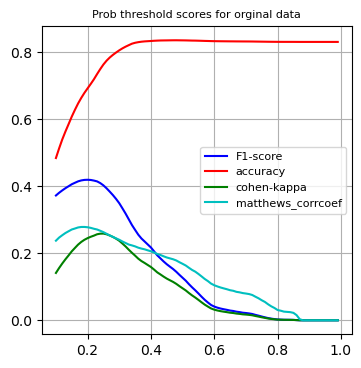

In [ ]:
# Plot the prob thresholds now:
_= plt.figure(figsize = (4,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_orig,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_orig,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_orig,"g-", label = "cohen-kappa")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_orig,"c-", label = "matthews_corrcoef")
_=plt.legend(fontsize = 8)
_=plt.title("Prob threshold scores for orginal data", fontsize = 8)
_=plt.grid()

#### <font color='red'><b>B.</b></font> xgboost model with only transformed data + time data
Original cat columns are not present

In [ ]:
# 10.2 Prepare xgboost model--Transformed data
#      Excluded: cat_cols, deviceid & deviceip
#      Included: time columns

model_trans = xgb.XGBClassifier( n_estimators= 350,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 7,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']
               )

In [ ]:
# 10.2.1 Save model object:

utils.savePythonObject(model_trans, "model_trans.pkl", avazudata)

In [ ]:
# 10.2.2 Restore model object:

model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)

In [ ]:
# 10.3 Best score"
gc.collect()
f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.7528(15L); 0.7538(20L); 0.7531621285335741(20L)
                                                                        # 0.7525667626/0.7529464064396/0.7491441196244635'
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 82(15L) 117(20L);70(20L)/87(20L)/92/349

#### <font color='red'><b>Bb.</b></font> Probability threshold graphs and loss metrics--Transformed data
F! score, Accuracy, Kappa and Matthews coeff<br>
Good references. [One](https://stats.stackexchange.com/a/312124) ; [Two](https://stats.stackexchange.com/a/207371) and [Three](https://stats.stackexchange.com/q/464636)

In [ ]:
# Calculate scores at diff prob thresholds:
# https://stackoverflow.com/a/76502698/3282777

f1_trans = []
ac_trans = []
ka_trans = []
mc_trans = []
prob_trans = model_trans.predict_proba(X_test_trans)
prob_class_1 = prob_trans[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_trans.append(f1_score(y_test.values,y_pred))
    ac_trans.append(accuracy_score(y_test.values,y_pred))
    ka_trans.append(cohen_kappa_score(y_test.values,y_pred))
    mc_trans.append(matthews_corrcoef(y_test.values,y_pred))


In [ ]:
# Calculate brier loss and log loss:

bl_trans = brier_score_loss(y_test,prob_class_1)
ll_trans = log_loss(y_test,prob_class_1)
print(f"Brier score loss transformed data: {bl_trans}")
print(f"Log loss transformed data: {ll_trans}")

Brier score loss transformed data: 0.12357433284650565
Log loss transformed data: 0.39442597892354375


In [ ]:
# Save all above acores:
trans_scores = (prob_trans, f1_trans,ac_trans,ka_trans,mc_trans, bl_trans, ll_trans)
utils.savePythonObject(trans_scores, "trans_scores.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\trans_scores.pkl


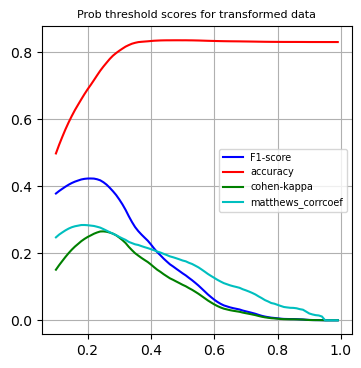

In [ ]:
# Plot scores at diff prob thresholds:

_= plt.figure(figsize = (4,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_trans,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_trans,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_trans,"g-", label = "cohen-kappa")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_trans,"c-", label = "matthews_corrcoef")
_=plt.legend(fontsize = 7)
_=plt.title("Prob threshold scores for transformed data", fontsize = 8)
_=plt.grid()

##### Compare prob threshold scores for original and transformed data

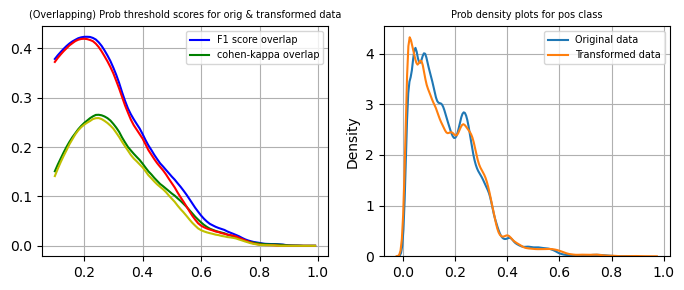

In [ ]:
fig,ax=plt.subplots(1,2,figsize = (7,3))
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_trans,"b-", label = "F1 score overlap")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ka_trans,"g-", label = "cohen-kappa overlap")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ka_orig,"y-")
_=ax[0].legend(fontsize = 7)
_=ax[0].grid()
_=ax[0].set_title("(Overlapping) Prob threshold scores for orig & transformed data", fontsize = 7)

# Prob density plots
_=sns.kdeplot(x = prob_orig[:,1], ax = ax[1], label = "Original data")
_=sns.kdeplot(x = prob_trans[:,1], ax = ax[1], label = "Transformed data")
_=ax[1].set_title("Prob density plots for pos class", fontsize = 7)
_=ax[1].grid()
_=ax[1].legend(fontsize = 7)
_=plt.tight_layout()

#### <font color='red'><b>C.</b></font> XGboost modeling with orig data, cat_cols + time, BUT without deviceid and deviceip

In [ ]:
# 10.4.0
Xtr = X_train.copy()
Xte = X_test.copy()
_=Xtr.pop('deviceid')
_=Xtr.pop('deviceip')
_=Xte.pop('deviceip')
_=Xte.pop('deviceid')

In [ ]:
# 10.4.0.1 Prepare xgboost model--Original data
#          But without deviceid and deviceip


model_orig_noip = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 7,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   Xtr
test_X = Xte
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig_noip.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


In [ ]:
# 10.4.1 Save and restore:

utils.savePythonObject(model_orig_noip, "model_orig_noip.pkl", avazudata)

In [ ]:
# 10.4.2 REstore model:
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

In [ ]:
# 10.4.3 Best score
f"Best auc from orig data minus deviceid/deviceip: {model_orig_noip.best_score}"  # 0.7528(15L); 0.7538(20L);  0.7506422630703(20L)
                                                                            # 0.75005234664/0.74975966300514
print("===========")
f"Best iteration:: {model_orig_noip.best_iteration}"  # 82(15L) 117(20L);136(20L)/144/141

##### Classification reports
Three cases

In [ ]:
# 10.5 Original data:

pred = model_orig.predict(X_test)
print(classification_report(ytest, pred))

In [ ]:
# 10.6 Original data without deviceid and deviceip

pred = model_orig_noip.predict(Xte)
print(classification_report(ytest, pred))

In [ ]:
# 10.7 Transformed data:

pred = model_trans.predict(X_test_trans)
print(classification_report(ytest, pred))

In [ ]:
# 10.8 No longer needed
del Xtr
del Xte
_=gc.collect()

#### <font color='red'><b>D.</b></font> xgboost model with only important features of transformed data   
AUC is about the same as that for transformed data.

##### Get **Feature** importance
Know feature importance of transformed data

In [ ]:
# 11.0 Get feature importance:
# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 414;405;411;350
print("\n")
len(fe_0)   # 172;177;177
fe[:5]  # Show impt oftop-five cols

In [ ]:
# 11.0.1
utils.savePythonObject(fe_1,"fe_1.pkl", avazuestimators)

In [ ]:
# 11.0.2
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)
len(fe_1)

350

##### xgboost modeling now

In [ ]:
# 11.1 Prepare xgboost model--Transformed but now with impt features:
model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                                     )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train
ytest = y_test


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']
                    )

9323

[12:31:01] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:31:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9754 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75452	validation_1-auc:0.73467
[12:31:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7852 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.76107	validation_1-auc:0.74080
[12:31:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8666 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76452	validation_1-auc:0.74316
[12:31:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8542 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76648	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 11.1.1 Save model object:
utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_trans_impt.pkl


In [ ]:
# 11.1.2 Restore model object:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

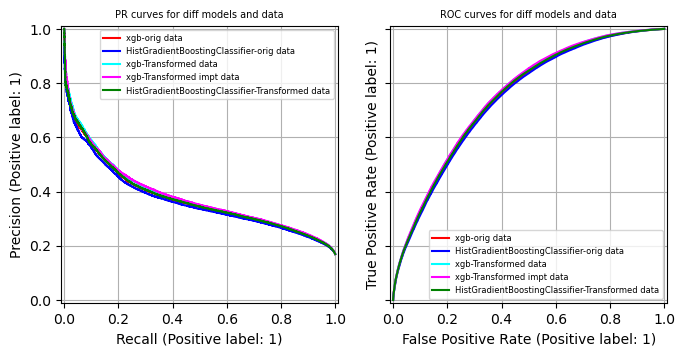

In [ ]:
fig,ax=plt.subplots(1,2,figsize = (7,5), sharey = True)

# PR curves
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[0],color = "red",label = "xgb-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[0], color = "blue", label = "HistGradientBoostingClassifier-orig data ")
_=PrecisionRecallDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[0], color = "cyan", label = "xgb-Transformed data" )
_=PrecisionRecallDisplay.from_estimator(model_trans_impt,X_test_trans[fe_1],y_test.values,ax = ax[0], color = "magenta", label = "xgb-Transformed impt data" )
_=PrecisionRecallDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[0], color = "green", label = "HistGradientBoostingClassifier-Transformed data")
_=ax[0].set_title("PR curves for diff models and data", fontsize = 7)
_=ax[0].legend(fontsize = 6)
_=ax[0].grid()

# ROC curves
_=RocCurveDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[1],color = "red", label = "xgb-orig data" )
_=RocCurveDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[1], color = "blue", label = "HistGradientBoostingClassifier-orig data")
_=RocCurveDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[1], color = "cyan",label = "xgb-Transformed data"  )
_=RocCurveDisplay.from_estimator(model_trans_impt,X_test_trans[fe_1],y_test.values,ax = ax[1], color = "magenta",label = "xgb-Transformed impt data"  )
_=RocCurveDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[1], color = "green",label = "HistGradientBoostingClassifier-Transformed data")
_=ax[1].set_title("ROC curves for diff models and data", fontsize = 7)
_=ax[1].legend(fontsize = 6)
_=ax[1].grid()
_=plt.tight_layout()

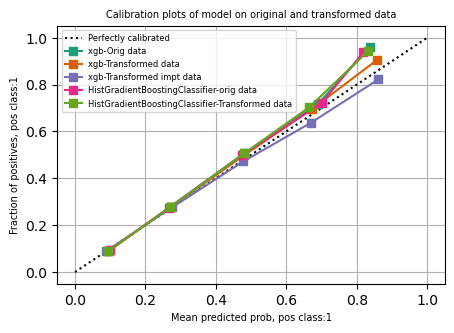

In [ ]:
# Probability Callibration plots:

clf_list = [
    (model_orig, "xgb-Orig data", X_test,y_test.values),
    (model_trans, "xgb-Transformed data",X_test_trans,y_test.values),
    (model_trans_impt, "xgb-Transformed impt data",X_test_trans[fe_1],y_test.values),
    (model_orig_hist, "HistGradientBoostingClassifier-orig data",X_test,y_test.values),
    (model_trans_hist, "HistGradientBoostingClassifier-Transformed data", X_test_trans,y_test.values),
]

fig = plt.figure(figsize=(5, 7))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name,xt,yt) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        xt,
        yt,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

_=ax_calibration_curve.grid()
_=ax_calibration_curve.set_title("Calibration plots of model on original and transformed data", fontsize = 7)
_=ax_calibration_curve.set_xlabel("Mean predicted prob, pos class:1", fontsize = 7)
_=ax_calibration_curve.set_ylabel("Fraction of positives, pos class:1", fontsize = 7)

plt.legend(fontsize = 6)

In [ ]:
calibrator = CalibratedClassifierCV(model_trans_impt,method = "isotonic", cv ='prefit')
calibrator.fit(X_test_trans[fe_1],y_test.values)
cal_preds = calibrator.predict_proba(X_test_trans[fe_1])
pred = model_trans_impt.predict_proba(X_test_trans[fe_1])

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.06, eval_metric=None,
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=15, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=250, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None, ...),
                       method='isotonic')

In [ ]:

brier_score_loss(y_test.values,cal_preds[:,1])
brier_score_loss(y_test.values,pred[:,1])

0.12333915309557582

0.1234279850906576

##### Classification report
Classification report of model with transformed data having impt features

In [ ]:
# 11.2 Classification report of transformed data but with impt features:

model_trans_impt.best_score    # 0.753373650(40L)/0.7525667626318204/0.7529464064396215
pred = model_trans_impt.predict(test_X)
print(classification_report(ytest, pred))

0.75383667447754

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415168
           1       0.60      0.09      0.16     84730

    accuracy                           0.84    499898
   macro avg       0.72      0.54      0.53    499898
weighted avg       0.80      0.84      0.78    499898



### Learning curves
LEarning curves of all the four xgboost models, ie
> Model with original data<br>
>Model with original data but without deviceid and deviceip<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

As the plots show:  
- Learning plots with transformed data show AUC which is shade better than that with original data<br>
- Learning plots of original data with and without deviceid and deviceip are about the the same


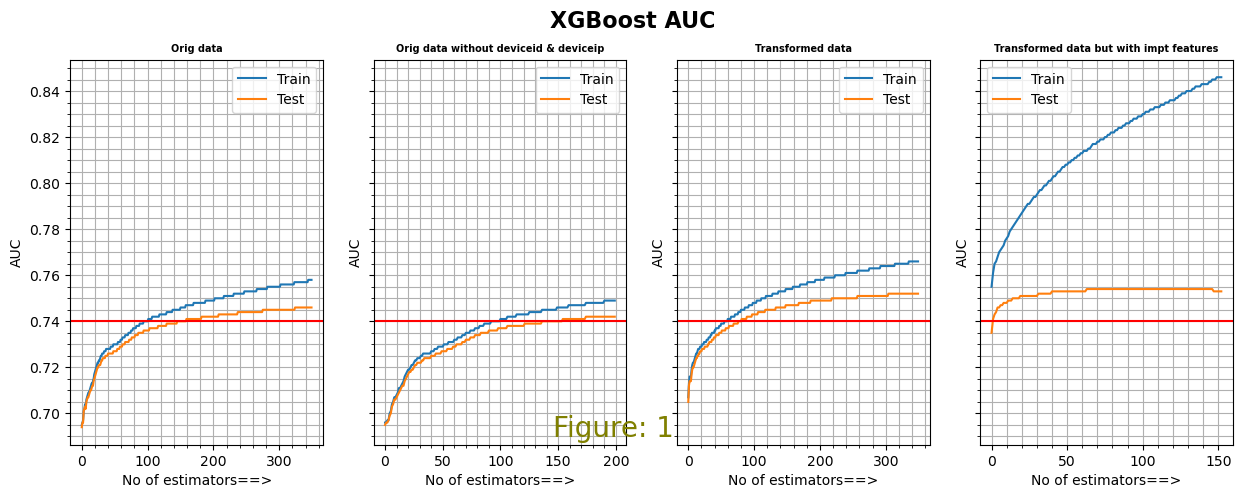

<Figure size 640x480 with 0 Axes>

In [ ]:
# 12.0 Learning curves of all the three models

_=plt.style.use('default')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(), model_orig_noip.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Orig data", 'Orig data without deviceid & deviceip', 'Transformed data', 'Transformed data but with impt features']
_=fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 16)

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    _=ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1.5, label='Train');
    _=ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1.5, label='Test');
    _=ax[i].legend();
    _=ax[i].grid(visible = True, which = 'both');
    _=ax[i].minorticks_on();
    _=ax[i].set_ylabel('AUC');
    _=ax[i].set_xlabel('No of estimators==>');
    _=ax[i].set_title(title[i], fontsize = 7, fontweight = "bold");
    _=ax[i].axhline(y=0.74, color='r', linestyle='-')

# This needs to be adjusted
txt="Figure: 1"
_=plt.text(-250, 0.69, txt, ha='center', fontsize = 20, color = "olive")

_=plt.show();
_=plt.tight_layout()

### Probability calibration and loss metrics:
Xgboost and HistGradientBoostingClassifier modeling on both orig and transformed data

In [ ]:
# Original data--xgboost modeling
calibrator = CalibratedClassifierCV(model_orig,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
cal_preds_orig = calibrator.predict_proba(X_test)[:,1]

# Transformed data xgboost modeling
calibrator = CalibratedClassifierCV(model_trans,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
cal_preds_trans = calibrator.predict_proba(X_test_trans)[:,1]

# Original data- HistGradientBoostingClassifier modeling
calibrator = CalibratedClassifierCV(model_orig_hist,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
cal_preds_orig_hist = calibrator.predict_proba(X_test)[:,1]

# Transformed data-HistGradientBoostingClassifier modeling
calibrator = CalibratedClassifierCV(model_trans_hist,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
cal_preds_trans_hist = calibrator.predict_proba(X_test_trans)[:,1]


In [ ]:
# Calculate brier loss for calbrated prob in each case of modeling:
f"Brier loss orig data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_orig)}"
f"Brier loss transformed data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_orig)}"
f"Brier loss orig data HistGradientBoostingClassifier modeling {brier_score_loss(y_test.values,cal_preds_orig_hist)}"
f"Brier loss transformed data HistGradientBoostingClassifier modeling  {brier_score_loss(y_test.values,cal_preds_trans_hist)}"

'Brier loss orig data xgboost modeling: 0.12432051126409586'

'Brier loss transformed data xgboost modeling: 0.12432051126409586'

'Brier loss orig data HistGradientBoostingClassifier modeling 0.12516220091208063'

'Brier loss transformed data HistGradientBoostingClassifier modeling  0.12410732937986543'

## HistGradientBoostingClassifier  modeling for original and transformed data

###  HistGradientBoostingClassifier Original data

In [ ]:
# 10.2 Prepare HistGradientBoostingClassifier model--Original data
#      Declare cat cols. Very high cardinality cat cols excluded

category_cols = ['Cone', 'bannerpos',   'sitecategory',  'appdomain',
                 'appcategory',  'devicetype', 'deviceconntype',
                 'Cfifteen', 'Csixteen',  'Ceighteen', 'Cnineteen',
                 'Ctwenty', 'Ctwentyone']  # Ignore high cardinality columns

model_orig_hist = HistGradientBoostingClassifier(  max_iter = 350,
                                                   verbose = 3,
                                                   learning_rate = 0.05,
                                                   max_features = 0.8,
                                                   categorical_features=category_cols,
                                                   random_state = rng,
                                                   n_iter_no_change=20,
                                                   loss = "log_loss",
                                                   validation_fraction=0.1,
                                                   max_depth = 8,
                                                   l2_regularization = 0.001
                                               )


tr_X =   X_train
test_X = X_test
ytrain = y_train
ytest = y_test


model_orig_hist.fit(tr_X, ytrain.values)

In [ ]:
# 10.2.1 Save model object:

utils.savePythonObject(model_orig_hist, "model_orig_hist.pkl", avazudata)


In [ ]:
# 10.2.2 Restore model object:

model_orig_hist = utils.restorePythonObject("model_orig_hist.pkl", avazudata)

### Prob threshold graphs and loss metrics

In [ ]:
#
# https://stackoverflow.com/a/76502698/3282777
f1_orig_hist = []
ac_orig_hist = []
ka_orig_hist = []
mc_orig_hist = []
prob_orig_hist = model_orig_hist.predict_proba(X_test)
prob_class_1 = prob_orig_hist[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_orig_hist.append(f1_score(y_test.values,y_pred))
    ac_orig_hist.append(accuracy_score(y_test.values,y_pred))
    ka_orig_hist.append(cohen_kappa_score(y_test.values,y_pred))
    mc_orig_hist.append(matthews_corrcoef(y_test.values,y_pred))

In [ ]:
# Brier score and log loss
bl_orig_hist = brier_score_loss(y_test,prob_orig_hist[:,1])
ll_orig_hist = log_loss(y_test,prob_orig_hist[:,1])
print(f"Brier score loss : {bl_orig_hist}")
print(f"Log loss: {ll_orig_hist}")


Brier score loss : 0.12532934908294466
Log loss: 0.40068150041114253


In [ ]:
# Save these lists/values for future:
orig_hist_scores = (prob_orig_hist, f1_orig_hist,ac_orig_hist,ka_orig_hist,mc_orig_hist, bl_orig_hist, ll_orig_hist)
utils.savePythonObject(orig_hist_scores, "orig_hist_scores.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\orig_hist_scores.pkl


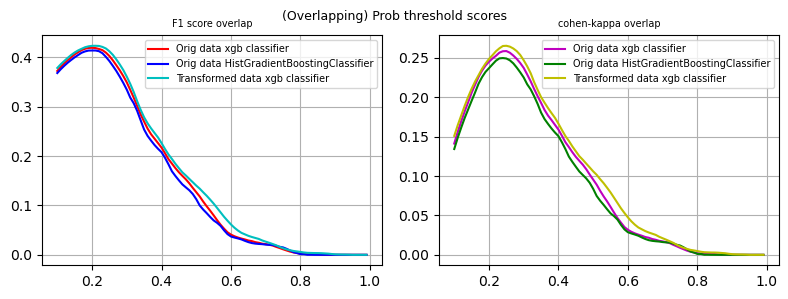

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (8,3))
#_= plt.figure(figsize = (4,4))
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-", label = "Orig data xgb classifier" )
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_orig_hist,"b-", label = "Orig data HistGradientBoostingClassifier")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_trans,"c-", label = "Transformed data xgb classifier")
_=ax[0].set_title("F1 score overlap", fontsize = 7)
_=ax[0].grid()
_=ax[0].legend(fontsize = 7)
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_orig,"m-",label = "Orig data xgb classifier" )
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_orig_hist,"g-",  label = "Orig data HistGradientBoostingClassifier")
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_trans,"y-", label = "Transformed data xgb classifier")
_=ax[1].legend(fontsize = 7)
_=ax[1].grid()
_=ax[1].set_title( "cohen-kappa overlap", fontsize = 7)
_=plt.tight_layout()
_=plt.suptitle("(Overlapping) Prob threshold scores", fontsize = 9)

### HistGradientBoostingClassifier Transformed data

In [ ]:
# 10.2 Prepare xgboost model--Transformed data
#      Excluded: cat_cols, deviceid & deviceip
#      Included: time columns
gc.collect()
model_trans_hist = HistGradientBoostingClassifier(  max_iter = 350,
                                                   verbose = 3,
                                                   learning_rate = 0.05,
                                                   max_features = 0.8,
                                                   random_state = rng,
                                                   n_iter_no_change=20,
                                                   loss = "log_loss",
                                                   validation_fraction=0.1,
                                                   #max_depth = 8,
                                                   l2_regularization = 0.001
                                               )


tr_X =   X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test


model_trans_hist.fit(tr_X, ytrain.values)

In [ ]:
# Save model
utils.savePythonObject(model_trans_hist, "model_trans_hist.pkl",avazudata)

In [ ]:
# Restore model
model_trans_hist = utils.restorePythonObject("model_trans_hist.pkl",avazudata)

In [ ]:
# https://stackoverflow.com/a/76502698/3282777
f1_trans_hist = []
ac_trans_hist = []
ka_trans_hist = []
mc_trans_hist = []
prob_trans_hist = model_trans_hist.predict_proba(X_test_trans)
prob_class_1 = prob_trans_hist[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_trans_hist.append(f1_score(y_test.values,y_pred))
    ac_trans_hist.append(accuracy_score(y_test.values,y_pred))
    ka_trans_hist.append(cohen_kappa_score(y_test.values,y_pred))
    mc_trans_hist.append(matthews_corrcoef(y_test.values,y_pred))

In [ ]:
bl_trans_hist = brier_score_loss(y_test,prob_trans_hist[:,1])
ll_trans_hist = log_loss(y_test,prob_trans_hist[:,1])
print(f"Brier score loss: {bl_trans_hist}")
print(f"Log loss: {ll_trans_hist}")

Brier score loss: 0.12425594421390837
Log loss: 0.39696224746676995


In [ ]:
# Save these lists/values for future:
trans_hist_scores = (prob_trans_hist, f1_trans_hist,ac_trans_hist,ka_trans_hist,mc_trans_hist, bl_trans_hist, ll_trans_hist)
utils.savePythonObject(trans_hist_scores, "trans_hist_scores.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\trans_hist_scores.pkl


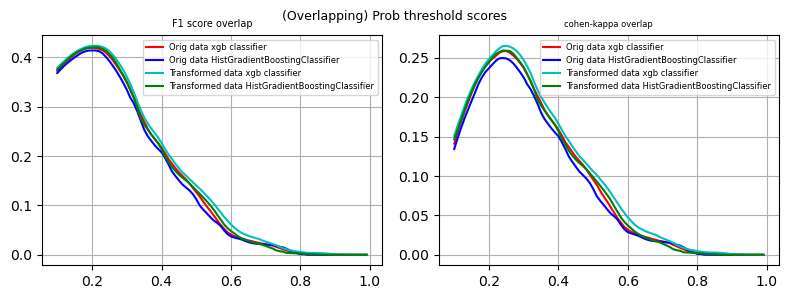

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (8,3))
#_= plt.figure(figsize = (4,4))
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-", label = "Orig data xgb classifier" )
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_orig_hist,"b-", label = "Orig data HistGradientBoostingClassifier")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_trans,"c-", label = "Transformed data xgb classifier")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_trans_hist,"g-", label = "Transformed data HistGradientBoostingClassifier")
_=ax[0].set_title("F1 score overlap", fontsize = 7)
_=ax[0].grid()
_=ax[0].legend(fontsize = 6)
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_orig,"r-",label = "Orig data xgb classifier" )
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_orig_hist,"b-",  label = "Orig data HistGradientBoostingClassifier")
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_trans,"c-", label = "Transformed data xgb classifier")
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_trans_hist,"g-", label = "Transformed data HistGradientBoostingClassifier")
_=ax[1].legend(fontsize = 6)
_=ax[1].grid()
_=ax[1].set_title( "cohen-kappa overlap", fontsize = 6)
_=plt.tight_layout()
_=plt.suptitle("(Overlapping) Prob threshold scores", fontsize = 9)

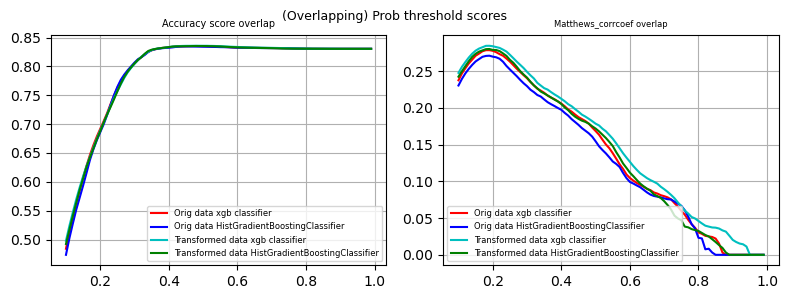

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (8,3))
#_= plt.figure(figsize = (4,4))
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ac_orig,"r-", label = "Orig data xgb classifier" )
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ac_orig_hist,"b-", label = "Orig data HistGradientBoostingClassifier")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ac_trans,"c-", label = "Transformed data xgb classifier")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ac_trans_hist,"g-", label = "Transformed data HistGradientBoostingClassifier")
_=ax[0].set_title("Accuracy score overlap", fontsize = 7)
_=ax[0].grid()
_=ax[0].legend(fontsize = 6)
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),mc_orig,"r-",label = "Orig data xgb classifier" )
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),mc_orig_hist,"b-",  label = "Orig data HistGradientBoostingClassifier")
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),mc_trans,"c-", label = "Transformed data xgb classifier")
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),mc_trans_hist,"g-", label = "Transformed data HistGradientBoostingClassifier")
_=ax[1].legend(fontsize = 6)
_=ax[1].grid()
_=ax[1].set_title( "Matthews_corrcoef overlap", fontsize = 6)
_=plt.tight_layout()
_=plt.suptitle("(Overlapping) Prob threshold scores", fontsize = 9)

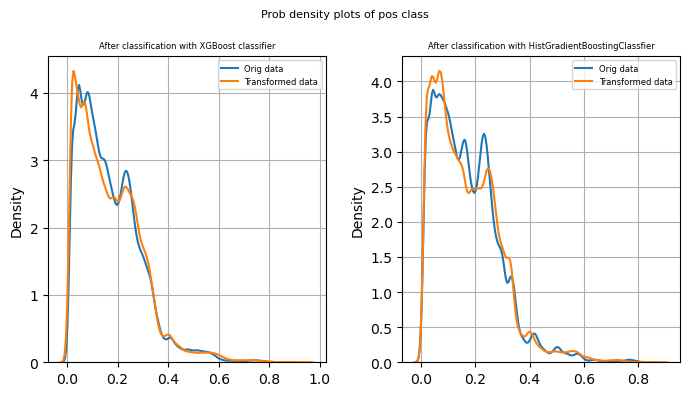

In [ ]:
# Prob density plots
fig,ax = plt.subplots(1,2,figsize = (7,4))

_=sns.kdeplot(x = prob_orig[:,1], ax = ax[0], label = "Orig data")
_=sns.kdeplot(x = prob_trans[:,1],  ax = ax[0] ,label = "Transformed data")
_=ax[0].set_title("After classification with XGBoost classifier", fontsize = 6)
_=ax[0].legend(fontsize = 6)
_=ax[0].grid()

_=sns.kdeplot(x = prob_orig_hist[:,1], ax = ax[1], label = "Orig data")
_=sns.kdeplot(x = prob_trans_hist[:,1], ax = ax[1], label = "Transformed data")
_=ax[1].legend(fontsize = 6)
_=ax[1].grid()
_=ax[1].set_title("After classification with HistGradientBoostingClassfier", fontsize = 6)
_=plt.suptitle("Prob density plots of pos class" , fontsize = 8)
_=plt.tight_layout()

### PR and ROC curves

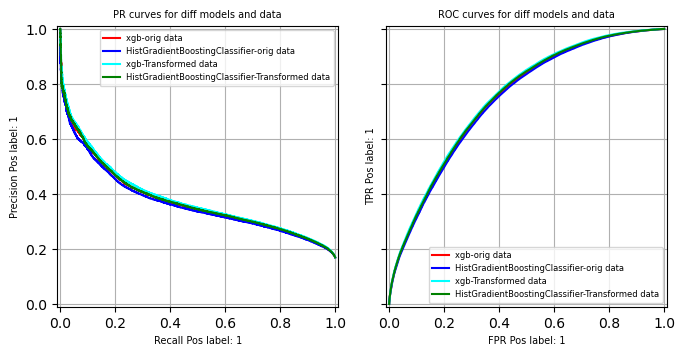

In [ ]:
fig,ax=plt.subplots(1,2,figsize = (7,5), sharey = True)

# PR curves
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[0],color = "red",label = "xgb-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[0], color = "blue", label = "HistGradientBoostingClassifier-orig data ")
_=PrecisionRecallDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[0], color = "cyan", label = "xgb-Transformed data" )
_=PrecisionRecallDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[0], color = "green", label = "HistGradientBoostingClassifier-Transformed data")
_=ax[0].set_title("PR curves for diff models and data", fontsize = 7)
_=ax[0].legend(fontsize = 6)
_=ax[0].grid()
_=ax[0].set_xlabel("Recall Pos label: 1", fontsize=7)
_=ax[0].set_ylabel("Precision Pos label: 1", fontsize=7)

# ROC curves
_=RocCurveDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[1],color = "red", label = "xgb-orig data" )
_=RocCurveDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[1], color = "blue", label = "HistGradientBoostingClassifier-orig data")
_=RocCurveDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[1], color = "cyan",label = "xgb-Transformed data"  )
_=RocCurveDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[1], color = "green",label = "HistGradientBoostingClassifier-Transformed data")
_=ax[1].set_title("ROC curves for diff models and data", fontsize = 7)
_=ax[1].legend(fontsize = 6)
_=ax[1].grid()
_=ax[1].set_ylabel("TPR Pos label: 1", fontsize=7)
_=ax[1].set_xlabel("FPR Pos label: 1", fontsize=7)
_=plt.tight_layout()

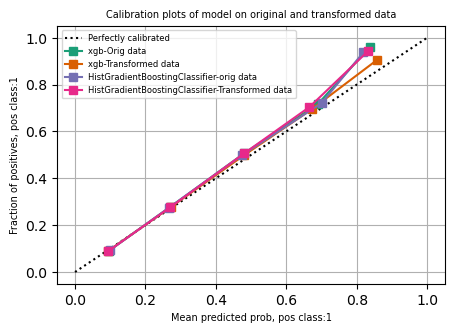

In [ ]:
# Probability Callibration plots:
clf_list = [
    (model_orig, "xgb-Orig data", X_test,y_test.values),
    (model_trans, "xgb-Transformed data",X_test_trans,y_test.values),
    (model_orig_hist, "HistGradientBoostingClassifier-orig data",X_test,y_test.values),
    (model_trans_hist, "HistGradientBoostingClassifier-Transformed data", X_test_trans,y_test.values),
]

fig = plt.figure(figsize=(5, 7))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name,xt,yt) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        xt,
        yt,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

_=ax_calibration_curve.grid()
_=ax_calibration_curve.set_title("Calibration plots of model on original and transformed data", fontsize = 7)
_=ax_calibration_curve.set_xlabel("Mean predicted prob, pos class:1", fontsize = 7)
_=ax_calibration_curve.set_ylabel("Fraction of positives, pos class:1", fontsize = 7)
_=plt.legend(fontsize = 6)

### Probability calibration and loss metrics:
Xgboost and HistGradientBoostingClassifier modeling on both orig and transformed data

In [ ]:
# Original data--xgboost modeling
calibrator = CalibratedClassifierCV(model_orig,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
cal_preds_orig = calibrator.predict_proba(X_test)[:,1]

# Transformed data xgboost modeling
calibrator = CalibratedClassifierCV(model_trans,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
cal_preds_trans = calibrator.predict_proba(X_test_trans)[:,1]

# Original data- HistGradientBoostingClassifier modeling
calibrator = CalibratedClassifierCV(model_orig_hist,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
cal_preds_orig_hist = calibrator.predict_proba(X_test)[:,1]

# Transformed data-HistGradientBoostingClassifier modeling
calibrator = CalibratedClassifierCV(model_trans_hist,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
cal_preds_trans_hist = calibrator.predict_proba(X_test_trans)[:,1]


In [ ]:
# Calculate brier loss for calbrated prob in each case of modeling:
f"Brier loss orig data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_orig)}"
f"Brier loss transformed data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_orig)}"
f"Brier loss orig data HistGradientBoostingClassifier modeling {brier_score_loss(y_test.values,cal_preds_orig_hist)}"
f"Brier loss transformed data HistGradientBoostingClassifier modeling  {brier_score_loss(y_test.values,cal_preds_trans_hist)}"

'Brier loss orig data xgboost modeling: 0.12432051126409586'

'Brier loss transformed data xgboost modeling: 0.12432051126409586'

'Brier loss orig data HistGradientBoostingClassifier modeling 0.12516220091208063'

'Brier loss transformed data HistGradientBoostingClassifier modeling  0.12410732937986543'

## catboost classifier  modeling for original and transformed data

### catboost model--Original data

In [ ]:
category_cols = ['Cone', 'bannerpos',   'sitecategory',  'appdomain',
                 'appcategory',  'devicetype', 'deviceconntype',
                 'Cfifteen', 'Csixteen',  'Ceighteen', 'Cnineteen',
                 'Ctwenty', 'Ctwentyone']  # Ignore high cardinality columns
params = {
         'iterations': 2000,
         'learning_rate': 0.1,
         'eval_metric': metrics.AUC(),
         'random_seed': 42,
         'logging_level': 'Silent',
         'use_best_model': True,
         'early_stopping_rounds' : 100,
         'custom_loss' : ['AUC', metrics.Logloss()]
        }
train_pool = Pool(X_train, y_train.values, cat_features=category_cols)
validate_pool = Pool(X_test, y_test.values, cat_features=category_cols)

# Instantiate model
model_orig_cb = CatBoostClassifier(**params)

0

In [ ]:
# For catboost model
start =time.time()
model_orig_cb.fit(train_pool, eval_set=validate_pool, verbose = True)
end = time.time()
print((end-start)/60)  # 33min

33.06768849293391


In [ ]:
# Save the model object
utils.savePythonObject(model_orig_cb, "model_orig_cb.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_orig_cb.pkl


In [ ]:
# Some modeling stats
model_orig_cb.best_score_ # 'validation': {'Logloss': 0.3967246760817494, 'AUC': 0.747908455501685}}
model_orig_cb.best_iteration_  # 1994

{'learn': {'Logloss': 0.39189203702194475},
 'validation': {'Logloss': 0.3967246760817494, 'AUC': 0.747908455501685}}

1994

### PR curves

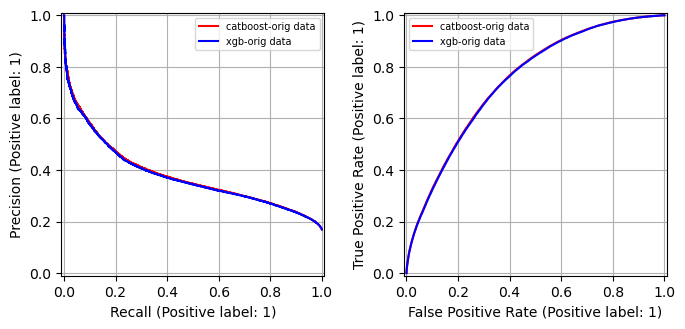

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (7,5))
_=PrecisionRecallDisplay.from_estimator(model_orig_cb,X_test,y_test.values,ax = ax[0], color = "red",label = "catboost-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[0],color = "blue",label = "xgb-orig data" )
_=ax[0].legend(fontsize = 7)
_=ax[0].grid()

_=RocCurveDisplay.from_estimator(model_orig_cb,X_test,y_test.values,ax = ax[1], color = "red",label = "catboost-orig data" )
_=RocCurveDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[1],color = "blue",label = "xgb-orig data" )
_=ax[1].legend(fontsize = 7)
_=ax[1].grid()
_=plt.tight_layout()

### Prob threshold plots

In [ ]:
# Calculate scores at diff prob thresholds:
# https://stackoverflow.com/a/76502698/3282777

f1_orig_cb = []
ac_orig_cb = []
ka_orig_cb = []
mc_orig_cb = []
prob_orig_cb = model_orig_cb.predict_proba(X_test)
prob_class_1 = prob_orig_cb[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_orig_cb.append(f1_score(y_test.values,y_pred))
    ac_orig_cb.append(accuracy_score(y_test.values,y_pred))
    ka_orig_cb.append(cohen_kappa_score(y_test.values,y_pred))
    mc_orig_cb.append(matthews_corrcoef(y_test.values,y_pred))

In [ ]:
# Calculate brier loss and log loss:

bl_orig_cb = brier_score_loss(y_test,prob_orig_cb[:,1])
ll_orig_cb = log_loss(y_test, prob_orig_cb[:,1])
print(f"Brier score loss orig data: {bl_orig_cb}")
print(f"Log loss transformed data: {ll_orig_cb}")

Brier score loss orig data: 0.12412438263101541
Log loss transformed data: 0.3967250245267757


In [ ]:
# Save all above acores:
orig_cb_scores = (prob_orig_cb, f1_orig_cb, ac_orig_cb, ka_orig_cb, mc_orig_cb, bl_orig_cb, ll_orig_cb)
utils.savePythonObject(orig_cb_scores, "orig_cb_scores.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\orig_cb_scores.pkl


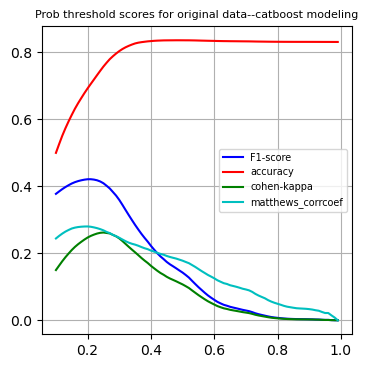

In [ ]:
# Plot scores at diff prob thresholds:

_= plt.figure(figsize = (4,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_orig_cb,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_orig_cb,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_orig_cb,"g-", label = "cohen-kappa")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_orig_cb,"c-", label = "matthews_corrcoef")
_=plt.legend(fontsize = 7)
_=plt.title("Prob threshold scores for original data--catboost modeling", fontsize = 8)
_=plt.grid()

### catboost model for transformed data

In [ ]:
# Parameters and model

params = {
         'iterations': 2000,
         'learning_rate': 0.1,
         'eval_metric': metrics.AUC(),
         'random_seed': 42,
        'logging_level': 'Silent',
        'use_best_model': True,
        'early_stopping_rounds' : 100,
        'custom_loss' : ['AUC', metrics.Logloss()]
      }
train_pool = Pool(X_train_trans, y_train.values )
validate_pool = Pool(X_test_trans, y_test.values)

model_trans_cb = CatBoostClassifier(**params)

0

In [ ]:
# Fit model
start =time.time()
model_trans_cb.fit(train_pool, eval_set=validate_pool, verbose = True)
end = time.time()
print((end-start)/60)  # 14 min

13.94100190003713


In [ ]:
# Save the model object
utils.savePythonObject(model_trans_cb, "model_trans_cb.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_trans_cb.pkl


In [ ]:
# Some stats
model_trans_cb.best_score_  # 'validation': {'Logloss': 0.39356434696852555, 'AUC': 0.7544055259704832}}
model_trans_cb.best_iteration_  # 999

{'learn': {'Logloss': 0.384650946361986},
 'validation': {'Logloss': 0.39356434696852555, 'AUC': 0.7544055259704832}}

1996

#### Prob density plots

In [ ]:
# Probability cals
p_orig_cb = model_orig_cb.predict_proba(X_test)[:,1]
p_trans_cb = model_trans_cb.predict_proba(X_test_trans)[:,1]

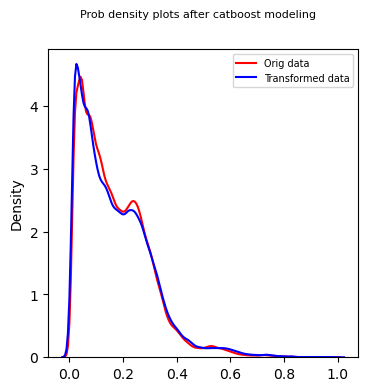

In [ ]:
# Prob plotting
fig,ax = plt.subplots(1,1, figsize= (4,4))
_=plt.suptitle("Prob density plots after catboost modeling", fontsize = 8)
_=sns.kdeplot(p_orig_cb, ax =ax, color = "red", label = "Orig data")
_=sns.kdeplot(p_trans_cb, ax = ax, color = "blue", label = "Transformed data")
_=plt.legend(fontsize = 7)
_= plt.show()

#### PR and ROC curves orig and transformed data

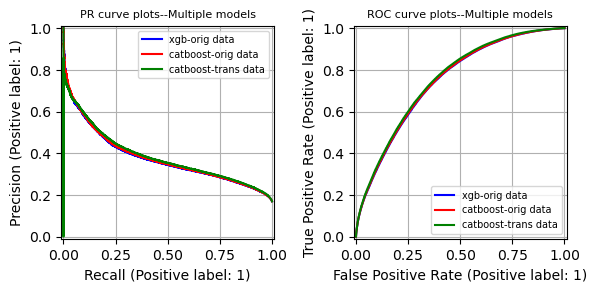

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (6,5))
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[0],color = "blue",label = "xgb-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_orig_cb,X_test,y_test.values,ax = ax[0], color = "red",label = "catboost-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_trans_cb,X_test_trans,y_test.values,ax = ax[0], color = "green",label = "catboost-trans data" )

_=ax[0].legend(fontsize = 7)
_=ax[0].grid()
_=ax[0].set_title("PR curve plots--Multiple models", fontsize = 8)

_=RocCurveDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[1],color = "blue",label = "xgb-orig data" )
_=RocCurveDisplay.from_estimator(model_orig_cb,X_test,y_test.values,ax = ax[1], color = "red",label = "catboost-orig data" )
_=RocCurveDisplay.from_estimator(model_trans_cb,X_test_trans,y_test.values,ax = ax[1],color = "green",label = "catboost-trans data" )
_=ax[1].legend(fontsize = 7)
_=ax[1].grid()
_=ax[1].set_title("ROC curve plots--Multiple models", fontsize = 8)
_=plt.tight_layout()

### Prob threshold plots

In [ ]:
f1_trans_cb = []
ac_trans_cb = []
ka_trans_cb = []
mc_trans_cb = []
prob_trans_cb = model_trans_cb.predict_proba(X_test_trans)
prob_class_1 = prob_trans_cb[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_trans_cb.append(f1_score(y_test.values,y_pred))
    ac_trans_cb.append(accuracy_score(y_test.values,y_pred))
    ka_trans_cb.append(cohen_kappa_score(y_test.values,y_pred))
    mc_trans_cb.append(matthews_corrcoef(y_test.values,y_pred))


In [ ]:
# Calculate brier loss and log loss:
bl_trans_cb = brier_score_loss(y_test,prob_trans_cb[:,1])
ll_trans_cb = log_loss(y_test,prob_trans_cb[:,1])
print(f"Brier score loss orig data: {bl_trans_cb}")
print(f"Log loss transformed data: {ll_trans_cb}")

Brier score loss orig data: 0.12333277967133173
Log loss transformed data: 0.39356464408404185


In [ ]:
# Save all above acores:
trans_cb_scores = (prob_trans_cb, f1_trans_cb, ac_trans_cb, ka_trans_cb, mc_trans_cb, bl_trans_cb, ll_trans_cb)
utils.savePythonObject(trans_cb_scores, "trans_cb_scores.pkl", avazudata)


Object saved to: c:\avazu\allmodels\datafiles\trans_cb_scores.pkl


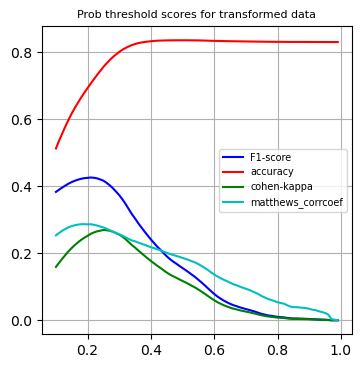

In [ ]:
# Plot scores at diff prob thresholds:

_= plt.figure(figsize = (4,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_trans_cb,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_trans_cb,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_trans_cb,"g-", label = "cohen-kappa")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_trans_cb,"c-", label = "matthews_corrcoef")
_=plt.legend(fontsize = 7)
_=plt.title("Prob threshold scores for transformed data", fontsize = 8)
_=plt.grid()

## Curves from all models

In [ ]:
# Restore all models, if not available:
model_orig      = utils.restorePythonObject("model_orig.pkl", avazudata )
model_trans     = utils.restorePythonObject("model_trans.pkl", avazudata)

model_orig_hist = utils.restorePythonObject("model_orig_hist.pkl", avazudata)
model_trans_hist= utils.restorePythonObject("model_trans_hist.pkl",avazudata)

model_orig_cb =   utils.restorePythonObject("model_orig_cb.pkl",avazudata)
model_trans_cb =  utils.restorePythonObject("model_trans_cb.pkl",avazudata)

### Prob density plots

In [ ]:
# Probability calculations
p_orig_xgb = model_orig.predict_proba(X_test)[:,1]
p_trans_xgb = model_trans.predict_proba(X_test_trans)[:,1]

p_orig_hist = model_orig_hist.predict_proba(X_test)[:,1]
p_trans_hist = model_trans_hist.predict_proba(X_test_trans)[:,1]

p_orig_cb = model_orig_cb.predict_proba(X_test)[:,1]
p_trans_cb = model_trans_cb.predict_proba(X_test_trans)[:,1]

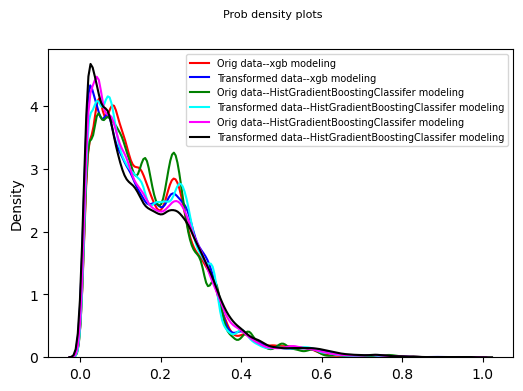

In [ ]:
# Prob plotting
fig,ax = plt.subplots(1,1, figsize= (6,4))
_=plt.suptitle("Prob density plots", fontsize = 8)
_=sns.kdeplot(p_orig_xgb, ax =ax, color = "red", label = "Orig data--xgb modeling")
_=sns.kdeplot(p_trans_xgb, ax = ax, color = "blue", label = "Transformed data--xgb modeling")

_=sns.kdeplot(p_orig_hist, ax =ax, color = "green", label = "Orig data--HistGradientBoostingClassifer modeling")
_=sns.kdeplot(p_trans_hist, ax = ax, color = "cyan", label = "Transformed data--HistGradientBoostingClassifer modeling")

_=sns.kdeplot(p_orig_cb, ax =ax, color = "magenta", label = "Orig data--HistGradientBoostingClassifer modeling")
_=sns.kdeplot(p_trans_cb, ax = ax, color = "black", label = "Transformed data--HistGradientBoostingClassifer modeling")


_=plt.legend(fontsize = 7)
_= plt.show()

### Prob calibration and brier/log loss

In [ ]:
# Original data--xgboost modeling
calibrator = CalibratedClassifierCV(model_orig,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
cal_preds_orig = calibrator.predict_proba(X_test)[:,1]

# Transformed data xgboost modeling
calibrator = CalibratedClassifierCV(model_trans,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
cal_preds_trans = calibrator.predict_proba(X_test_trans)[:,1]

# Original data- HistGradientBoostingClassifier modeling
calibrator = CalibratedClassifierCV(model_orig_hist,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
cal_preds_orig_hist = calibrator.predict_proba(X_test)[:,1]

# Transformed data-HistGradientBoostingClassifier modeling
calibrator = CalibratedClassifierCV(model_trans_hist,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
cal_preds_trans_hist = calibrator.predict_proba(X_test_trans)[:,1]

# Original data- catboost classifier modeling
calibrator = CalibratedClassifierCV(model_orig_cb,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
cal_preds_orig_cb = calibrator.predict_proba(X_test)[:,1]

# Transformed data-catboost classifier modeling
calibrator = CalibratedClassifierCV(model_trans_cb,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
cal_preds_trans_cb = calibrator.predict_proba(X_test_trans)[:,1]

In [ ]:
# Brier loss calculations

# Calculate brier loss for calbrated prob in each case of modeling:
##xgboost modelibg
f"Brier loss orig data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_orig)}"
f"Brier loss transformed data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_orig)}"

## histgradientboosting model
f"Brier loss orig data HistGradientBoostingClassifier modeling {brier_score_loss(y_test.values,cal_preds_orig_hist)}"
f"Brier loss transformed data HistGradientBoostingClassifier modeling  {brier_score_loss(y_test.values,cal_preds_trans_hist)}"

# catboost model
f"Brier loss orig data catboost modeling: {brier_score_loss(y_test.values,cal_preds_orig_cb)}"
f"Brier loss transformed data catboost modeling: {brier_score_loss(y_test.values,cal_preds_trans_cb)}"


'Brier loss orig data xgboost modeling: 0.12432051126409586'

'Brier loss transformed data xgboost modeling: 0.12432051126409586'

'Brier loss orig data HistGradientBoostingClassifier modeling 0.12516220091208063'

'Brier loss transformed data HistGradientBoostingClassifier modeling  0.12410732937986543'

'Brier loss orig data catboost modeling: 0.12404372780018136'

'Brier loss transformed data catboost modeling: 0.12324039773477515'

In [ ]:
# Brier loss calculations

# Calculate brier loss for calbrated prob in each case of modeling:
##xgboost modelibg
f"Log loss orig data xgboost modeling: {log_loss(y_test.values,cal_preds_orig)}"
f"Log loss transformed data xgboost modeling: {log_loss(y_test.values,cal_preds_orig)}"

## histgradientboosting model
f"Log loss orig data HistGradientBoostingClassifier modeling {log_loss(y_test.values,cal_preds_orig_hist)}"
f"Log loss transformed data HistGradientBoostingClassifier modeling  {log_loss(y_test.values,cal_preds_trans_hist)}"

# catboost model
f"Log loss orig data catboost modeling: {log_loss(y_test.values,cal_preds_orig_cb)}"
f"Log loss transformed data catboost modeling: {log_loss(y_test.values,cal_preds_trans_cb)}"


'Log loss orig data xgboost modeling: 0.39728115483157217'

'Log loss transformed data xgboost modeling: 0.39728115483157217'

'Log loss orig data HistGradientBoostingClassifier modeling 0.4000367086387048'

'Log loss transformed data HistGradientBoostingClassifier modeling  0.3963353460973182'

'Log loss orig data catboost modeling: 0.39639673239759193'

'Log loss transformed data catboost modeling: 0.39316660119156843'

### PR and ROC curves

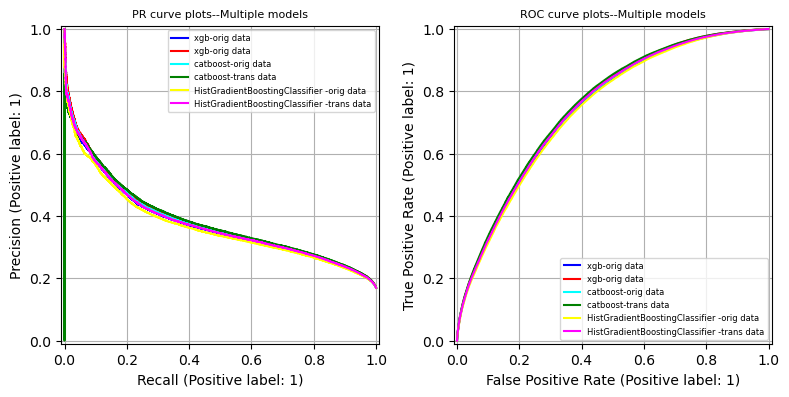

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (8,5))
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[0],color = "blue",label = "xgb-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[0],color = "red",label = "xgb-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_orig_cb,X_test,y_test.values,ax = ax[0], color = "cyan",label = "catboost-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_trans_cb,X_test_trans,y_test.values,ax = ax[0], color = "green",label = "catboost-trans data" )
_=PrecisionRecallDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[0], color = "yellow",label = "HistGradientBoostingClassifier -orig data" )
_=PrecisionRecallDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[0], color = "magenta",label = "HistGradientBoostingClassifier -trans data" )
_=ax[0].legend(fontsize = 6)
_=ax[0].grid()
_=ax[0].set_title("PR curve plots--Multiple models", fontsize = 8)

_=RocCurveDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[1],color = "blue",label = "xgb-orig data" )
_=RocCurveDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[1],color = "red",label = "xgb-orig data" )
_=RocCurveDisplay.from_estimator(model_orig_cb,X_test,y_test.values,ax = ax[1], color = "cyan",label = "catboost-orig data" )
_=RocCurveDisplay.from_estimator(model_trans_cb,X_test_trans,y_test.values,ax = ax[1],color = "green",label = "catboost-trans data" )
_=RocCurveDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[1], color = "yellow",label = "HistGradientBoostingClassifier -orig data" )
_=RocCurveDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[1],color = "magenta",label = "HistGradientBoostingClassifier -trans data" )

_=ax[1].legend(fontsize = 6)
_=ax[1].grid()
_=ax[1].set_title("ROC curve plots--Multiple models", fontsize = 8)
_=plt.tight_layout()

In [ ]:
f"AUC orig data after xgboost modeling: {roc_auc_score(y_test.values, p_orig_xgb)}"
f"AUC transformed data after xgbosst modeling: {roc_auc_score(y_test.values, p_trans_xgb)}"
f"AUC orig data after histgradientboost modeling: {roc_auc_score(y_test.values, p_orig_hist)}"
f"AUC transformed data after histgradientboost modeling: {roc_auc_score(y_test.values, p_trans_hist)}"
f"AUC orig data after catboost modeling: {roc_auc_score(y_test.values, p_orig_cb)}"
f"AUC transformed data after catboost modeling: {roc_auc_score(y_test.values, p_trans_cb)}"


'AUC orig data after xgboost modeling: 0.7459425653598867'

'AUC transformed data after xgbosst modeling: 0.7522024837914942'

'AUC orig data after histgradientboost modeling: 0.7402968364298298'

'AUC transformed data after histgradientboost modeling: 0.7478340748192405'

'AUC orig data after catboost modeling: 0.7479084555016852'

'AUC transformed data after catboost modeling: 0.7544055259704833'

In [ ]:
# Data to plot precision - recall curve
precision, recall, _ = precision_recall_curve(y_test.values, p_orig_xgb)
f"PR curve area orig data xgboost modeling {auc(recall, precision)}"
precision, recall, _ = precision_recall_curve(y_test.values, p_trans_xgb)
f"PR curve area trans data xgboost modeling {auc(recall, precision)}"
precision, recall, _ = precision_recall_curve(y_test.values, p_orig_hist)
f"PR curve area orig data histgradientboosting modeling {auc(recall, precision)}"
precision, recall, _ = precision_recall_curve(y_test.values, p_trans_hist)
f"PR curve area trans data histgradientboosting modeling {auc(recall, precision)}"
precision, recall, _ = precision_recall_curve(y_test.values, p_orig_cb)
f"PR curve area orig data catboost modeling {auc(recall, precision)}"
precision, recall, _ = precision_recall_curve(y_test.values, p_trans_cb)
f"PR curve area trans data catboost modeling {auc(recall, precision)}"



'PR curve area orig data xgboost modeling 0.3759710642856666'

'PR curve area trans data xgboost modeling 0.3837630244314624'

'PR curve area orig data histgradientboosting modeling 0.3673721381445388'

'PR curve area trans data histgradientboosting modeling 0.3772709071579572'

'PR curve area orig data catboost modeling 0.37886210096427764'

'PR curve area trans data catboost modeling 0.3840324233771476'

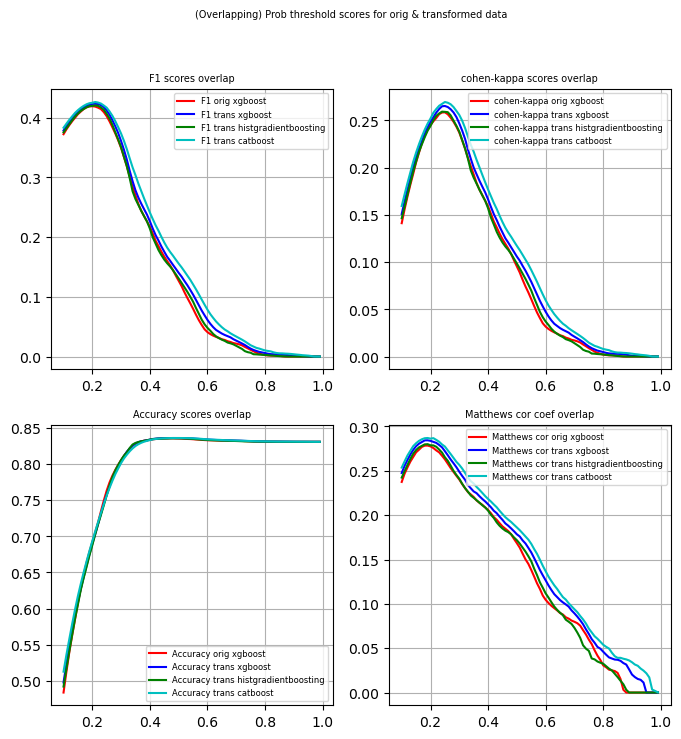

In [ ]:
fig,ax=plt.subplots(2,2,figsize = (8,8))

_=ax[0,0].plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-", label = "F1 orig xgboost")
_=ax[0,0].plot(np.arange(0.1, 1.0,  0.01),f1_trans,"b-", label = "F1 trans xgboost")
_=ax[0,0].plot(np.arange(0.1, 1.0,  0.01),f1_trans_hist,"g-", label = "F1 trans histgradientboosting")
_=ax[0,0].plot(np.arange(0.1, 1.0,  0.01),f1_trans_cb,"c-", label = "F1 trans catboost")
_=ax[0,0].legend(fontsize = 6)
_=ax[0,0].grid()
_=ax[0,0].set_title("F1 scores overlap", fontsize = 7)


_=ax[0,1].plot(np.arange(0.1, 1.0,  0.01),ka_orig,"r-" , label = "cohen-kappa orig xgboost")
_=ax[0,1].plot(np.arange(0.1, 1.0,  0.01),ka_trans,"b-", label = "cohen-kappa trans xgboost")
_=ax[0,1].plot(np.arange(0.1, 1.0,  0.01),ka_trans_hist,"g-", label = "cohen-kappa trans histgradientboosting")
_=ax[0,1].plot(np.arange(0.1, 1.0,  0.01),ka_trans_cb,"c-", label = "cohen-kappa trans catboost ")

_=ax[0,1].legend(fontsize = 6)
_=ax[0,1].grid()
_=ax[0,1].set_title("cohen-kappa scores overlap", fontsize = 7)



_=ax[1,0].plot(np.arange(0.1, 1.0,  0.01),ac_orig,"r-", label = "Accuracy orig xgboost")
_=ax[1,0].plot(np.arange(0.1, 1.0,  0.01),ac_trans,"b-", label = "Accuracy trans xgboost")
_=ax[1,0].plot(np.arange(0.1, 1.0,  0.01),ac_trans_hist,"g-", label = "Accuracy trans histgradientboosting")
_=ax[1,0].plot(np.arange(0.1, 1.0,  0.01),ac_trans_cb,"c-", label = "Accuracy trans catboost")
_=ax[1,0].legend(fontsize = 6)
_=ax[1,0].grid()
_=ax[1,0].set_title("Accuracy scores overlap", fontsize = 7)



_=ax[1,1].plot(np.arange(0.1, 1.0,  0.01),mc_orig,"r-", label = "Matthews cor orig xgboost")
_=ax[1,1].plot(np.arange(0.1, 1.0,  0.01),mc_trans,"b-", label = "Matthews cor trans xgboost")
_=ax[1,1].plot(np.arange(0.1, 1.0,  0.01),mc_trans_hist,"g-", label = "Matthews cor trans histgradientboosting")
_=ax[1,1].plot(np.arange(0.1, 1.0,  0.01),mc_trans_cb,"c-", label = "Matthews cor trans catboost")

_=ax[1,1].legend(fontsize = 6)
_=ax[1,1].grid()
_=ax[1,1].set_title("Matthews cor coef overlap", fontsize = 7)




_=plt.suptitle("(Overlapping) Prob threshold scores for orig & transformed data", fontsize = 7)

# Approach--II: Working with PCA of Transformed data


We perform following steps
><font color='red'><b>A.</b></font> Take PCA of `X_train_trans/X_test_trans` after imputing<br>
><font color='red'><b>B.</b></font> Plot first two principal components (`pc0` & `pc1`) that clearly show existence of two clusters in data<br>
><font color='red'><b>C.</b></font> Perform xgboost modeling with PCA<br>
><font color='red'><b>D.</b></font> Use `imblearn` library to (a) undersample with `EditedNearestNeighbours` (b) Oversample and then undersample with `SMOTEENN`<br>
><font color='red'><b>E.</b></font> Perform XGBoost modeling with the two datasets obtained in <font color='red'><b>(D)</b></font> above.<br>

Performance wise numbers are;

| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| Original data | <b>0.75006940</b> | 0.15 | 0.09 |  
| PCA data | 0.737737462 | 0.14 | 0.08 |  
| PCA followed by `EditedNearestNeighbours` |  0.7387503785918 | 0.37 | 0.37 |
| PCA followed by `SMOTEENN` | 0.730573852 | <b>0.40</b> | <b>0.72</b> |

### Impute data

In [ ]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 63060/65406/65932

X_train_trans.shape  # (1499627, 588)/(1499698, 750)
X_test_trans.shape   # (499876, 588)/(499900, 750)

In [ ]:
# 13.1 Impute as test data has null values:
#      First reduce memory requirements:
#      (We had to do it as our machine had 16gb RAM)

X_train_trans_imputed = X_train_trans.astype('float16')
X_test_trans_imputed  = X_test_trans.astype('float16')

In [ ]:
# 13.1 Impute as test data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_imputed[:] = si.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = si.transform(X_test_trans_imputed)
end = time.time()
print("Done: ", (end-start)/60)  # 2.79 min

In [ ]:
# 13.1.1 Check for nulls again:

X_train_trans_imputed.isnull().sum().sum()  # 0
X_test_trans_imputed.isnull().sum().sum()   # 0

#### Save imputed data

In [ ]:
# 13.2 Save imputed data for later experiments:

X_train_trans_imputed.to_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed.to_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.0 Datashapes:

X_train_trans_imputed.shape  # (1501119, 586)/(1499049, 582)/(1499627, 588)/(1499698, 750)
X_test_trans_imputed.shape   # (500374, 586)/(499684, 582)/(499876, 588)/(499900, 750)

#### Read imputed data

In [ ]:
# 13.2.1 Read back saved imputed data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 13.2.2 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)/(1499698, 750)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)/(499900, 750)

### Perform 95% PCA

In [ ]:
# 13.2.3
ss = StandardScaler()
X_train_trans_imputed[:] = ss.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = ss.transform(X_test_trans_imputed)

In [ ]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95


pca = PCA(n_components= 0.95,
          whiten= True,
          random_state = rng)

pca_train = pca.fit_transform(X_train_trans_imputed)

pca_test  = pca.transform(X_test_trans_imputed)

# 13.3.1 Check data shapes:
pca_train.shape  # (1501119, 97)/(1499493, 96)/(1499627, 95)/(1499698, 101)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)/(499900, 101)

In [ ]:
# 13.3.2
pca.explained_variance_ratio_[:10]

In [ ]:
# 13.3.3 Save PCA object
utils.savePythonObject(pca,"pca.pkl", avazudata)

In [ ]:
# 13.3.4 Restore PCA object
pca = utils.restorePythonObject("pca.pkl", avazudata)

In [ ]:
# 13.4 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test =  pd.DataFrame(pca_test,  columns = colnames)

# 13.4.1 Dataframe shapes:

pca_train.shape  # (1501119, 97)/(1499493, 96)/1499627, 95)/(1499698, 101)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)/(499900, 101)

### Save and Read back 95% PCA data







In [ ]:
# 13.5 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazudata) / "pca_train.pkl")
pca_test.to_pickle(Path(avazudata) / "pca_test.pkl")

In [ ]:
# 13.5.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazudata) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 13.5.2 Check
pca_train.head(3)
pca_test.head(3)

### Plotting PCA
Plotting Ist two componenets of PCA provides insights into data structure. This data clearly has two clusters.

In [ ]:
# 13.6 Take a stratified sample for plotting:
#      Just 5000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 50000,
                                       stratify = y_train
                                      )

# 13.6.1 Our data for plotting:
pca_tr.shape  # (5000, 97)/(5000, 95)/(5000, 101)
pca_y.shape   # (5000,)

In [ ]:
# 13.7 2D PCA plot from first two principal components:
#      Two clusters are evident:

fig = plt.figure(figsize = (10,5));
ax1=fig.add_subplot(1,2,1);
sns.set_theme() ; # Set default theme
_=sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["lightgrey", "red"],
                ax =ax1
                ).set(title='PCA from transformed data');


_=plt.xlabel("pc0 \n\n Figure: 2a")
_=plt.axvline(x= 0.3, linestyle="--", color = 'grey')
_=plt.axhline(y= 0.8, linestyle="--", color = 'grey')

# 13.7.1 Contour plot that brings more clarity:
ax2=fig.add_subplot(1,2,2);
_=sns.kdeplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"],
                ax = ax2,
                bw_adjust = 0.5  # Less smoothing effect; default = 1
                ).set(title='PCA from transformed data');


_=plt.xlabel("pc0 \n\n Figure: 2b")
_=plt.axvline(x= 0.3, linestyle="--", color = 'grey')
_=plt.axhline(y= 0.8, linestyle="--", color = 'grey')

##### Examining PCA plot
By examining plot we discover that one level of `sitedomain` barely contributes to clicks. From PCA plot we observe that:   
><font color = 'red'> a) </font> There are two clear clusters   
><font color = 'red'> b) </font> The <b>Ist quadrant</b> of the clusters (see Figure: 2) has very few clicks.    
><font color = 'red'> c) </font>Ratio of clicks to total data is <u>17%</u>. But for rows having level of `sitedomain` as `c4e18dd6`, this click ratio is: <u>0.8%</u>. Such rows having level of `sitedomain` as `c4e18dd6` are 37.42% of the whole data.

We verify above on the whole of dataset, step-by-step.

In [ ]:
# 14.0 Get number of clicks in the Ist quadrant and their proportion:

pca_train['click'] = y_train.values
noOfClicks  = pca_train.loc[(pca_train['pc0'] > 0.5) & (pca_train['pc1'] > 0.8) , :].click.sum()
noOfDataPts = pca_train.loc[(pca_train['pc0'] > 0.5) & (pca_train['pc1'] > 0.8) , :].shape[0]
f'Proportion of clicks (to total data) in the Ist quadrant: {noOfClicks/noOfDataPts}'
f'Proportion of clicks (to total data) in all the quadrants: {pca_train.click.sum()/pca_train.shape[0]}'

So the Ist quadrant corresponds to which rows in X_train ?

In [ ]:
# 14.1 Let us look at data that constitute Ist quadrant:

X_train.loc[(pca_train['pc0'] > 0.5) & (pca_train['pc1'] > 0.8) , :].head()

A quick visual examination shows that `sitedomain` has almost a constant value of `2720` in that quadrant. Let us further probe this. Proportion of `sitedomain` with value `2720` jumps from a ratio of `0.374` for the whole of X_train to a ratio of `0.999` in the Ist quadrant.

In [ ]:
# 14.2 Distribution of sitedomain levels over X_train:
X_train['sitedomain'].value_counts(normalize = True)[:5]

# 14.3 Distribution of sitedomain limited to the Ist quadrant:
X_train.loc[(pca_train['pc0'] > 0.5) & (pca_train['pc1'] > 0.8) , 'sitedomain'].value_counts(normalize = True)[:5]

Proportion of `stedomain` coded as `2720` is much larger in the Ist quadrant. Let us now examine this for the whole of train data:

In [ ]:
# 14.4 Read full train data:

train_full = pd.read_pickle(  avazudata / "train_full.pkl")
y = pd.read_pickle(  avazudata / "y.pkl")

# 14.5 Append 'click' feature to train_full:
train_full['click'] = y

In [ ]:
# 14.6.0 Also readback labelEncoder objects:
dict_ = utils.restorePythonObject( "labelEnoders.pkl", avazudata)

# 14.6.1 And here is a the list of classes in sitedomain feature
dict_['sitedomain'].classes_

# 14.6.2 And here are the corresponding integer labels:
dict_['sitedomain'].transform(dict_['sitedomain'].classes_)

In [ ]:
# 14.7 So corresponding to 2720, the actual level is:

dict_['sitedomain'].classes_[2720]   # 'c4e18dd6'

# 14.7.1 Proportion of rows in the whole of data with level: 'c4e18dd6'
(train_full['sitedomain'] == 'c4e18dd6').sum()/train_full.shape[0]   # 0.3742796346985566

# 14.7.2 And recheck the above as:
train_full['sitedomain'].value_counts(normalize = True)[:5]

In [ ]:
# 14.8 Finally find the ratio of clicks in rows that have 'sitedomain' as 'c4e18dd6':
r1 = train_full.loc[train_full['sitedomain'] == 'c4e18dd6' , 'click'].sum() * 100/train_full.loc[train_full['sitedomain'] == 'c4e18dd6' , 'click'].shape[0]


# 14.8.1 Percentage of such rows in total data is:
r2 = train_full.loc[train_full['sitedomain'] == 'c4e18dd6' , :].shape[0] * 100/train_full.shape[0]  # 37.427%

f"How likely 'sitedomain' with level of 'c4e18dd6' will get clicked: {r1}%"
f"How likely 'sitedomain' with level of 'c4e18dd6' will occur in train data: {r2}%"

In [ ]:
# 14.9 Now release memory as we do not immediately need train_full:

del train_full
_gc.collect()

### xgboost modeling with all the PCA components


In [ ]:
# 15.0 Prepare xgboost model--PCA data

# 15.0.1 We use class weights also:
#        Actually there is no benefit of class weights:

class_weights = {0: 1, 1: 10}
model_pca = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 15,
                           subsample = 0.8,
                           class_weight = class_weights,
                           random_state = rng,
                           )


tr_X =   pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']
                    )

In [ ]:
# 15.0.2 Save model object:

utils.savePythonObject(model_pca, "model_pca.pkl", avazudata)


In [ ]:
# 15.0.3 Restore model object:

model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

In [ ]:
# 15.1 Best Scores:

model_pca.best_score     # 0.7377374624019014
model_pca.best_iteration # 80

#### Classification report
xgboost modeling with PCA data

In [ ]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
print(classification_report(ytest, pred))

In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.57      0.08      0.14     85094

    accuracy                           0.83    499900
   macro avg       0.70      0.53      0.52    499900
weighted avg       0.79      0.83      0.78    499900



                precision    recall  f1-score   support

           0       0.84      0.99      0.91    352805
           1       0.57      0.08      0.14     72357

    accuracy                           0.83    425162
   macro avg       0.71      0.53      0.52    425162
weighted avg       0.79      0.83      0.78    425162

               precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.57      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.70      0.53      0.52    499684
weighted avg       0.79      0.83      0.78    499684



"""

#### Learning curve
xgboost modeling with PCA data

In [ ]:
# 15.3 Learning curve of xgboost based on pca data:
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,1, figsize = (5,5));

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs);
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid();
ax.set_ylabel('AUC');
ax.set_xlabel('No of estimators==> \n\n Figure: 3')
ax.set_title("XGBoost AUC--PCA data");


_=plt.show();
_=plt.tight_layout()



## Balanacing PCA train data with `imblearn` library


We use imblearn library
><font color = 'red'>a)</font> To undersample with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
><font color = 'red'>b)</font> To balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>

The former removes majority samples along the decision boundary and hence undersamples majority data. The next one performs SMOTE followed by cleaning along the decision boundary.<br>
A simple explanation of how the techniques work is [here](https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50)

Steps followed here are:<br>
>a. Undersample or oversample+undersample PCA data  
>b. Plot first two PCs in each of the two cases  
>c. Perform XGBoost modeling in each of the two cases  

Results are as follows:




 <table>
    <caption style="text-align:center"><font size = 30><b>My savings</font></b></caption>
  <tr>
    <th>Company</th>
    <th>Contact</th>
    <th>Country</th>
  </tr>
  <tr>
      <td><b>Alfreds Futterkiste</b></td>
    <td>Maria Anders</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>Centro comercial Moctezuma</td>
    <td>Francisco Chang</td>
    <td>Mexico</td>
  </tr>
</table>


| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| Original data | <b>0.75006940</b> | 0.15 | 0.09 |  
| PCA data | 0.737737462 | 0.14 | 0.08 |  
| PCA followed by `EditedNearestNeighbours` |  0.7387503785918 | 0.37 | 0.37 |
| PCA followed by `SMOTEENN` | 0.730573852 | <b>0.40</b> | <b>0.72</b> |

In [ ]:
# 16.0 Call imblearn library:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`
Undersamples majority class near decision boundary

### Expt with transformed train data

In [ ]:
# 16.1 Undersample transformed train data:
start = time.time()
undersample = EditedNearestNeighbours()
X_res_trans, y_res_trans = undersample.fit_resample(X_train_trans, y_train)
end = time.time()
print((end-start)/60)  # 30min

# 16.1.1 Data shape
X_res_trans.shape  #  (1081210, 750)
y_res_trans.shape  #  (1081210,)

In [ ]:
# 16.1.1 Save X_res_trans and y_res_trans
X_res_trans.to_pickle(Path(avazudata) / "X_res_trans.pkl")
y_res_trans.to_pickle(Path(avazudata) / "y_res_trans.pkl")

In [ ]:
# 16.1.2 Restore transformed data:
X_res_trans = pd.read_pickle(Path(avazudata) / "X_res_trans.pkl" )
y_res_trans = pd.read_pickle(Path(avazudata) / "y_res_trans.pkl" )

In [ ]:
# 17.3 xgboost Modeling with undersampled data
gc.collect()
model_en_trans = xgb.XGBClassifier( n_estimators= 650 , #Needs to be reduced
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 8,
                               subsample = 0.9,
                               random_state = rng,
                           )


tr_X =   X_res_trans
test_X = X_test_trans
ytrain = y_res_trans
ytest =  y_test


model_en_trans.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )

In [ ]:
# 17.3.1:
utils.savePythonObject(model_en_trans, "model_en_trans.pkl", avazudata)

In [ ]:
# 17.3.2
model_en_trans = utils.restorePythonObject("model_en_trans.pkl", avazudata)

In [ ]:
# 17.4 Scores:
model_en_trans.best_score     # 0.7535013774
model_en_trans.best_iteration # 648

In [ ]:
fig,ax=plt.subplots(1,2,figsize = (7,5), sharey = True)

# PR curves
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[0],color = "red",label = "xgb-orig data" )
_=PrecisionRecallDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[0], color = "blue", label = "HistGradientBoostingClassifier-orig data ")
_=PrecisionRecallDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[0], color = "cyan", label = "xgb-Transformed data" )
_=PrecisionRecallDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[0], color = "green", label = "HistGradientBoostingClassifier-Transformed data")
_=PrecisionRecallDisplay.from_estimator(model_en_trans,X_test_trans,y_test.values,ax = ax[0], color = "magenta", label = "EditedNearestNeighbour processed data")
_=ax[0].set_title("PR curves for diff models and data", fontsize = 7)
_=ax[0].legend(fontsize = 6)
_=ax[0].grid()

# ROC curves
_=RocCurveDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax[1],color = "red", label = "xgb-orig data" )
_=RocCurveDisplay.from_estimator(model_orig_hist,X_test,y_test.values,ax = ax[1], color = "blue", label = "HistGradientBoostingClassifier-orig data")
_=RocCurveDisplay.from_estimator(model_trans,X_test_trans,y_test.values,ax = ax[1], color = "cyan",label = "xgb-Transformed data"  )
_=RocCurveDisplay.from_estimator(model_trans_hist,X_test_trans,y_test.values,ax = ax[1], color = "green",label = "HistGradientBoostingClassifier-Transformed data")
_=RocCurveDisplay.from_estimator(model_en_trans,X_test_trans,y_test.values,ax = ax[1], color = "magenta",label = "EditedNearestNeighbour processed data")
_=ax[1].set_title("ROC curves for diff models and data", fontsize = 7)
_=ax[1].legend(fontsize = 6)
_=ax[1].grid()
_=plt.tight_layout()

In [ ]:
# Probability Calliberation plots:
clf_list = [
    (model_orig, "xgb-Orig data", X_test,y_test.values),
    (model_trans, "xgb-Transformed data",X_test_trans,y_test.values),
    (model_orig_hist, "HistGradientBoostingClassifier-orig data",X_test,y_test.values),
    (model_trans_hist, "HistGradientBoostingClassifier-Transformed data", X_test_trans,y_test.values),
    (model_en_trans, "EditedNearestNeighbour processed data", X_test_trans,y_test.values),
]

fig = plt.figure(figsize=(5, 7))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name,xt,yt) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        xt,
        yt,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots of model on original and transformed data", fontsize = 7)
plt.legend(fontsize = 6)

In [ ]:
calibrator = CalibratedClassifierCV(model_en_trans,method = "isotonic", cv ='prefit')
calibrator.fit(X_test_trans,y_test.values)
cal_preds = calibrator.predict_proba(X_test_trans)
pred = model_en_trans.predict_proba(X_test_trans)

In [ ]:
brier_score_loss(y_test.values,cal_preds[:,1])
brier_score_loss(y_test.values,pred[:,1])

#### Plots of probability thresholds

In [ ]:
# https://stackoverflow.com/a/76502698/3282777
f1_res_trans = []
ac_res_trans = []
ka_res_trans = []
mc_res_trans = []
#prob_class_1 = model_en_trans.predict_proba(X_test_trans)[:,1]
prob_class_1 = cal_preds[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_res_trans.append(f1_score(y_test.values,y_pred))
    ac_res_trans.append(accuracy_score(y_test.values,y_pred))
    ka_res_trans.append(cohen_kappa_score(y_test.values,y_pred))
    mc_res_trans.append(matthews_corrcoef(y_test.values,y_pred))

In [ ]:
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_res_trans,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_res_trans,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_res_trans,"g-", label = "cohen-kappa")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_res_trans,"c-", label = "matthews_corrcoef")
_=plt.legend(fontsize= 7)
_=plt.title("Prob threshold scores data transformed and processed with EditedNearestNeighbour", fontsize = 7)
_=plt.grid()

In [ ]:
# Probability thresholds original/transformed data:

_= plt.figure(figsize = (7,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_res_trans,"b-", label = "F1 score trans")
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-", label = "F1 score orig")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_res_trans,"g-", label = "cohen-kappa trans")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_orig,"y-", label = "cohen-kappa trans")
_=plt.legend(fontsize = 7)
_=plt.grid()
_=plt.title("(Overlapping) Prob threshold scores for orig & transformed data", fontsize = 7)

#### PR curves

#### Brier score loss and logloss

In [ ]:
f"Brier loss"
f"Original data: {brier_score_loss(y_test.values,model_orig.predict_proba(X_test)[:,1])}"
f"Transformed data: {brier_score_loss(y_test.values,model_trans.predict_proba(X_test_trans)[:,1])}"
f"After EditedNearestNeighbour transformeation: {brier_score_loss(y_test.values,model_en_trans.predict_proba(X_test_trans)[:,1])}"

In [ ]:
f"Log loss"
f"Orig data: {log_loss(y_test.values,model_orig.predict_proba(X_test)[:,1])}"
f"Transformed data: {log_loss(y_test.values,model_trans.predict_proba(X_test_trans)[:,1])}"
f"EditedNearestNeighbour processed data: {log_loss(y_test.values,model_en_trans.predict_proba(X_test_trans)[:,1])}"

### Expt with PCA data

In [ ]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 30min

# 16.1.1 Data shape
X_res.shape  #  (1075328, 97)/(1091067, 96)/(1089900, 95)/(1091041, 101)
y_res.shape  #  (1075328,)/(1074577, )/(1091067,)/(1089900, )/(1091041,)

In [ ]:
# 16.1.1 Save X_res and y_res

X_res.to_pickle(Path(avazudata) / "X_res.pkl")
y_res.to_pickle(Path(avazudata) / "y_res.pkl")

In [ ]:
# 16.1.2 Restore
X_res = pd.read_pickle(Path(avazudata) / "X_res.pkl" )
y_res = pd.read_pickle(Path(avazudata) / "y_res.pkl" )

### Plot of Ist two components of cleanedup data
Even here, two clusters are evident.

In [ ]:
# 17.0 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res,
                                       y_res,
                                       test_size = 5000,
                                       stratify = y_res
                                       )

fig = plt.figure(figsize = (5,5));
_=fig.add_subplot(1,1,1);
_=sns.set_theme() ;
_=sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

_=plt.xlabel("pc0 \n\n Figure: 4")

### xgboost modeling with undersampled data

In [ ]:
# 17.3 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 650 , #Needs to be reduced
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 8,
                               subsample = 0.9,
                               random_state = rng,
                           )


tr_X =   X_res
test_X = pca_test
ytrain = y_res
ytest =  y_test


model_en.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )



In [ ]:
# 17.3.1:
utils.savePythonObject(model_en, "model_en.pkl", avazudata)

In [ ]:
# 17.3.2
model_en = utils.restorePythonObject("model_en.pkl", avazudata)

In [ ]:
# 17.4 Scores:

model_en.best_score     # 0.7387503785918077
model_en.best_iteration # 579

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [ ]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(test_X)
print(classification_report(y_test, pred))

In [ ]:
"""

                precision    recall  f1-score   support

           0       0.87      0.87      0.87    414806
           1       0.37      0.37      0.37     85094

    accuracy                           0.78    499900
   macro avg       0.62      0.62      0.62    499900
weighted avg       0.78      0.78      0.78    499900


                precision    recall  f1-score   support

           0       0.87      0.86      0.87    415242
           1       0.36      0.39      0.38     85132

    accuracy                           0.78    500374
   macro avg       0.62      0.62      0.62    500374
weighted avg       0.79      0.78      0.78    500374

iter2
=====
               precision    recall  f1-score   support

           0       0.87      0.86      0.87    414878
           1       0.36      0.38      0.37     84806

    accuracy                           0.78    499684
   macro avg       0.62      0.62      0.62    499684
weighted avg       0.79      0.78      0.78    499684

"""

## Using `SMOTEENN`
For balancing PCA data and then cleaning

In [ ]:
# 18.0 Instantiate SMOTEEN and use it on pca_train:
gc.collect()
start= time.time()
sm = SMOTEENN(random_state=rng, n_jobs = -1)
X_res_sm_trans, y_res_sm_trans = sm.fit_resample(X_train_trans, y_train)
end = time.time()
print((end-start)/60)  # 100m (20L)

In [ ]:
# 18.0.1 Save X_res and y_res
gc.collect()
X_res_sm_trans.to_pickle(Path(avazudata) / "X_res_sm_trans.pkl")
y_res_sm_trans.to_pickle(Path(avazudata) / "y_res_sm_trans.pkl")

In [ ]:
# 18.0.2 Restore

X_res_sm_trans = pd.read_pickle(Path(avazudata) / "X_res_sm_trans.pkl" )
y_res_sm_trans = pd.read_pickle(Path(avazudata) / "y_res_sm_trans.pkl" )

In [ ]:
# 17.3 xgboost Modeling with undersampled data
gc.collect()
model_sm_trans_log = xgb.XGBClassifier( n_estimators= 700 , #Needs to be reduced
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.7,
                               colsample_bytree = 0.7,
                               min_child_weight = 3.0,
                               random_state = rng,
                           )


tr_X =   X_res_sm_trans
test_X = X_test_trans
ytrain = y_res_sm_trans
ytest =  y_test


model_sm_trans_log.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          #eval_metric = ['auc']
          )

In [ ]:
# 17.3.1:
utils.savePythonObject(model_sm_trans, "model_sm_trans.pkl", avazudata)

In [ ]:
model_sm_trans = utils.restorePythonObject("model_sm_trans.pkl",avazudata)

In [ ]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_sm_trans.predict(X_test_trans)
print(classification_report(y_test, pred))

In [ ]:
# https://stackoverflow.com/a/76502698/3282777
f1_res_sm_trans = []
ac_res_sm_trans = []
prob_class_1 = model_sm_trans_log.predict_proba(X_test_trans)[:,1]
for thresh in np.arange(0.1, 1.0,  0.1):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_res_sm_trans.append(f1_score(y_test.values,y_pred))
    ac_res_sm_trans.append(accuracy_score(y_test.values,y_pred))

In [ ]:
plt.plot(f1_orig,ac_orig,'g-',f1_res_sm_trans,ac_res_sm_trans,'b-')
plt.grid()

In [ ]:
log_loss(y_test.values, model_orig.predict_proba(X_test)[:,1])
log_loss(y_test.values,model_sm_trans.predict_proba(X_test_trans)[:,1])
log_loss(y_test.values,model_trans.predict_proba(X_test_trans)[:,1])
log_loss(y_test.values,model_en_trans.predict_proba(X_test_trans)[:,1])
log_loss(y_test.values,model_sm_trans_log.predict_proba(X_test_trans)[:,1])

In [ ]:
fig,ax=plt.subplots(1,1,figsize = (5,7))
_=PrecisionRecallDisplay.from_estimator(model_sm_trans,X_test_trans,y_test.values,ax = ax )
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax)
_=PrecisionRecallDisplay.from_estimator(model_en_trans,X_test_trans,y_test.values,ax = ax )
plt.grid()

In [ ]:
fig,ax=plt.subplots(1,1,figsize = (5,7))
_=PrecisionRecallDisplay.from_estimator(model_orig,X_test,y_test.values,ax = ax, color = "r")
_=PrecisionRecallDisplay.from_estimator(model_en_trans,X_test_trans,y_test.values,ax = ax,color = "g" )
_=PrecisionRecallDisplay.from_estimator(model_sm_trans,X_test_trans,y_test.values,ax = ax ,color = "b")
plt.grid()

In [ ]:
_=plt.figure(figsize = (4,3))
_=plt.plot(np.arange(0.1,1.0,0.1),f1_orig,"r-",label = "orig data")
_=plt.plot(np.arange(0.1,1.0,0.1), f1_res_trans,"g-",label = "Transformed and proecessed with EditedNearestNeighbours")
_=plt.plot(np.arange(0.1,1.0,0.1),f1_res_sm_trans,"b-", label = "Transformed and proecessed with SMOTEENN")
_=plt.xlabel("Probability")
_=plt.ylabel("F!-score")
_=plt.legend(fontsize = 6)
_=plt.grid()

In [ ]:
# 18.0 Instantiate SMOTEEN and use it on pca_train:

start= time.time()
sm = SMOTEENN(random_state=rng, n_jobs = -1)
X_res_sm, y_res_sm = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 100m (20L)

In [ ]:
# 18.0.1 Save X_res and y_res

X_res_sm.to_pickle(Path(avazudata) / "X_res_sm.pkl")
y_res_sm.to_pickle(Path(avazudata) / "y_res_sm.pkl")

In [ ]:
# 18.0.2 Restore

X_res_sm = pd.read_pickle(Path(avazudata) / "X_res_sm.pkl" )
y_res_sm = pd.read_pickle(Path(avazudata) / "y_res_sm.pkl" )

In [ ]:
# 18.0.3 Data shape after SMOTEENN

X_res_sm.shape  # (1688427, 97)/(1558844, 96)/(1557978, 95)/(1558408, 95)/(1553492, 101)
y_res_sm.shape  # (1688427,),(1558844,)/(1557978,)/(1558408,)/(1553492,)

In [ ]:
# 18.0.4:

y_res_sm.value_counts()
y_res_sm.value_counts(normalize = True)  # 51%:48%

### Plot of Ist two components of oversampled/cleanedup data
Two clusters are eveident here

In [ ]:
# 18.0.5 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:
# StackOverflow: https://stackoverflow.com/a/51486361/3282777

_, pca_tr, _,pca_y  = train_test_split(X_res_sm, y_res_sm, test_size = 5000, stratify = y_res_sm)

fig = plt.figure(figsize = (5,5));
_=fig.add_subplot(1,1,1);
_=sns.set_theme() ;
_=sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;


_=plt.xlabel("pc0 \n\n Figure: 5")

### xgboost modeling with balanced data (SMOTEENN)

In [ ]:
# 19.0 Modeling with smoteenn data

model_sm = xgb.XGBClassifier( n_estimators= 650,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_sm
test_X = pca_test
ytrain = y_res_sm
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,
                early_stopping_rounds = 100,
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']
                )



In [ ]:
# 19.0.1

utils.savePythonObject(model_sm, "model_sm.pkl", avazudata)

In [ ]:
# 19.0.2
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

In [ ]:
# 19.1 score
model_sm.best_score   # 0.7320805711/0.73260329129(20L)/0.7305378582/0.730988385236/0.7305738525325511
model_sm.best_iteration  # 230/222/308/213

In [ ]:
# https://stackoverflow.com/a/76502698/3282777
f1_sm = []
ac_sm = []
ll_sm = []
prob_class_1 = model_sm.predict_proba(pca_test)[:,1]
for thresh in np.arange(0.1, 1.0,  0.1):
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_sm.append(f1_score(y_test.values,y_pred))
    ac_sm.append(accuracy_score(y_true,y_pred))


In [ ]:
plt.plot(f1_orig,ac_orig,f1_trans,ac_trans,f1_pca,ac_pca, f1_res,ac_res,f1_sm,ac_sm)
plt.grid()

In [ ]:
plt.plot(np.arange(0.1, 1.0,  0.1),f1_orig,'o',np.arange(0.1, 1.0,  0.1),f1_trans,'g' ,np.arange(0.1, 1.0,  0.1),f1_sm,'c' )
plt.grid()

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,auc,average_precision_score

In [ ]:
prec, recall, _ = precision_recall_curve(y_test.values, model_en.predict_proba(pca_test)[:,1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
prec1, recall1, _ = precision_recall_curve(y_test.values, model_orig_noip.predict_proba(Xte)[:,1])
pr_display = PrecisionRecallDisplay(precision=prec1, recall=recall1).plot()

In [ ]:
auc(recall1, prec1)
auc(recall, prec)


In [ ]:
pr_display = PrecisionRecallDisplay(precision=prec1, recall=recall1).plot()
pr_display1 = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
average_precision_score(y_test, model_orig_noip.predict_proba(Xte)[:,1])
average_precision_score(y_test, model_orig.predict_proba(X_test)[:,1])
average_precision_score(y_test, model_trans.predict_proba(X_test_trans)[:,1])

#### Classification report
After balancing with `SMOTEENN` class

In [ ]:
# 19.2
pred = model_sm.predict(test_X)
print(classification_report(y_test, pred))

In [ ]:
"""
               precision    recall  f1-score   support

           0       0.91      0.62      0.74    414806
           1       0.28      0.72      0.40     85094

    accuracy                           0.64    499900
   macro avg       0.60      0.67      0.57    499900
weighted avg       0.81      0.64      0.68    499900


               precision    recall  f1-score   support

           0       0.93      0.54      0.69    415242
           1       0.26      0.79      0.40     85132

    accuracy                           0.59    500374
   macro avg       0.60      0.67      0.54    500374
weighted avg       0.82      0.59      0.64    500374


               precision    recall  f1-score   support

           0       0.93      0.55      0.69    414878
           1       0.26      0.79      0.40     84806

    accuracy                           0.59    499684
   macro avg       0.60      0.67      0.54    499684
weighted avg       0.81      0.59      0.64    499684

"""

## Learning plots
xgboost modeling with the two class balancing techniques

In [ ]:
# 19.3 Learning curves: xgboost modeling

plt.style.use('bmh')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result()]
title = ["Original Data", "Transformed data", "Undersampling with EditedNearestNeighbours", 'Oversampling and cleaning->SMOTEENN']
fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 14)
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y=0.75, color='g', linestyle='--', label='p=0.05')
    ax[i].axhline(y=0.73, color='g', linestyle='--')
    ax[i].text(0, 0.75, '0.75', ha='left', va='center')
    ax[i].text(0, 0.73, '0.73', ha='left', va='center')



# This needs to be adjusted
txt="Figure: 6"
_=plt.text(-500, 0.60, txt, ha='center', fontsize = 20, color = "olive")

plt.show();

## Distribution of transformed features:
We make three plots:
>a. Proportion of columns as per centrality measure   
>b. Proportion of impt features as per centrality measures  
>c. Among important columns, sum up xgboost importance scores by centrality measures and plot as a percentage





This is how the features related to different centrality measures are distributed

### Proportion of columns by centrality measure:

In [ ]:
# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")
plt.xlabel("\n\n Figure: 7")


### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

In [ ]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")
plt.xlabel("\n\n Figure: 8")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")
plt.xlabel("\n\n Figure: 9")

# Approach--III-- Transforming densevectors to unitvectors
And taking PCAs of them

<font size = 5>What are densevectors?</font>


Every level of a cat col has densevector(s) associated with it. We explain densevectors with examples from `talkingData`. `talkingData` has five categorical features: `ip, app, os, channel` and `device`. We concatenate these features to create more features, as: `app_p_device, app_p_channel, os_p_channel` etc. We transformed all these cat features to numeric features using `catEncodersFamily` class. Names of numeric features start with one of the centrality measures' prefix, such as: `deg_, pr_, eig_, bet_ and clu`. Thus, in every row, every level of a feature, say, `app` has corresponding 'dense' vector. An extract of dataframe of densevectors of `app` would look as:  

| app | deg_app_ck_channel | deg_app_ck_device |  pr_app_ck_ip |   
| --- | --- | --- | -- |
| 213 | 0.324 | 0.152 | 0.0923 |  
| 214 | 0.321 | 0.126 | 0.0239 |  
| 321 |  0.451 | 0.156 | 0.067 |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| 214 | 0.109 | 0.328 | 0.802 |  


For, `app` feature, for level, 213, we have two dense vectors: one is: [0.324,0.152,0.0923...] and the other is: [0.109, 0.328, 0.802...].

<u>Note</u>: Features such as: `pr_app_p_os_ck_ip,  'deg_app_p_channel_ck_os' .. ` are derived from concatenated columns ( of `app` & `os`, and, `app` & `channel`) hence, would not be a part of dense vector for `app`.

Similar to above we would have dataframes of dense vectors for `ip`, `os` and others. An example, for `os`:

| os | deg_os_ck_channel | eig_os_ck_device |  pr_os_ck_ip |   
| --- | --- | --- | -- |
| 101 | .0324 | 0.098 | 0.3423 |  
| 10 | 0.9021 | 0.378 | 0.8239 |  
| 210 |  0.1451 | 0.256 | 0.967 |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| 87 | 0.1109 | 0.128 | 0.232 |  

Our numerically transformed (*composite*) train/test dataframes (obtained using `ct.transform()` ), `train_trans`, and `test_trans`, can be taken as <u>horizontal concatenation</u> of all these dataframes of densevectors. Thus, to repeat, dense vectors for `'app'` (in our small example limited to few columns) would be:<br>

> `train_trans[['deg_app_ck_channel', 'deg_app_ck_device', 'deg_app_ck_ip', 'deg_app_ck_os','pr_app_ck_device', 'pr_app_ck_ip', 'pr_app_ck_os' ]]`<br>

If a level occurs multiple times (as it normally would) then there are multiple corresponding rows of vectors. Given a cat col, we first collect in a DataFrame all related columns, as for example below for `'app'` column.  




<font size = 5>What are unitvectors</font>


Once the dataframe of densevectors, per cat_col, is extracted, we apply row-wise normalization (`l2` norm). Such normalized rows are unitvectors for corresponding levels. We, therefore, have a dataframe of unitvectors for every cat_col. Method, `vectorsToTSV()` takes `X_train_trans`/`X_test_trans` (with 'target' column) as input and outputs a dictionary whose keys are elements of cat_col and values are dataframes of unitvectors. If `take_mean` parameter is True, a final `'unitvector'` for each level, say, of 'app' (213) would be calculated by taking mean of corresponding rows. `target` column is needed to list colour for each level in a meta file (saved to disk) should we like to plot the unitvectors on tensorflow's Embedding Projector.

<font size = 5>PCA of unitvectors</font>


We, further, take PCAs of each dataframe of unitvectors (per cat col) and concatenate them. Here is an example of PCAs of unitvectors for `os` with three principal components.

| os | os_pc0 | os_pc1 |  os_pc2 |   
| --- | --- | --- | -- |
| 101 | -0.34 | -2.31 | -0.44 |  
| 10 | 0.97 | -1.12 | 0.98 |  
| 210 |  0.23 | 0.34 | 0.99 |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| 87 | 2.56 | 0.61 | 0.97 |  

Similary, PCAs would be there for unitvectors corresponding to other `cat_cols`; each one is a pandas DataFrame. We concatenate them to produce one composite dataframe. Method, `pcaAndConcat()`, would do this work for us.

<font size = 5>Properties of PCAs of unitvectors</font>


PCAs of unitvectors have some good properties. We have used the <b>first</b> principal components ( *pc0s* ) of all unitvectors in our experiments. Number of these principal components are as many as the number of categorical features digested by thr `CatEncodersFamily` class.

>a. These first principal components (*pc0s*), on XGBoost modeling give almost the same results as that with the original categorical features. There are minor deteriorations in AUC score and in F1 score, in the case of avazu data.<br>
> b. Their xgboost feature importance is almost in the same order as that of categorical features in original data (see the table below).<br>
> c. After passing them through appropriate imblearn package classes on modeling, they give much higher F1 score and about the same AUC.<br>

In a way, we have been able to reduce 16 categorical features of avazu data to corresponding 16 numerical features. We have used the top-three important features in our density plots to discover relationships.

<font size = 5>Results</font>


Here is a compilation of results from what follows. *pc0s* of unitvectors after a little processing give more than double F1 score. Compare AUC of srno 2 with that of srno 4.


| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| 1. Original data with all cat cols| 0.75006940 | 0.15 | 0.09 |
| 2. Original data with those 16 cat cols as exist in PC0s | <i>0.7494159</i> | 0.15 | 0.09 |
| 3. PCAs of Unitvectors | 0.74447243 | 0.12 | 0.07 |  
| 4. PC0s of unitvectors | <i>0.7362513</i> | 0.15 | 0.08 |  
| 5. Undersampling with `EditedNearestNeighbours` of *pc0s* |  0.728930 | <b>0.34</b> | <b>0.31</b> |

<font size = 5>Feature importance ranking (Search for: Figure: 11)</font>:

As can be seen from Figure: 11, there is a good amount of match between the xgboost importance ranking (by gain) of cat_col features in the original data and those of *pc0s*
 of unitvectors. The following two tables show how the match exists between top-features and bottom features. In between there is minor jumbling. All total number of features is 16 *out of which 13 features match (almost) entirely*.

><u>Top-most features impt matching</u>:

| Rank | Original data feature name | <i>pc0</i> feature name |     
| --- | --- | --- |
| 1| devicemodel| pcdevicemodel0 |
| 2 | Cfourteen	 | pcCfourteen0 |
| 3 | Ctwenty | pcCtwenty0 |
| 4 | siteid | pcsiteid0 |
| 5 |  sitedomain|<font color = 'red'>pcappid0 </font> |
| 6 |  <font color = 'red'> appid </font> | pcsitedomain0 |

><u>Bottom-most features impt matching (reverse ranking)</u>:

| Rank | Original data feature name | <i>pc0</i> feature name |     
| --- | --- | --- |
| 1| Csixteen	| pcCsixteen0 |
| 2 | Cfifteen | pcCfifteen0 |
| 3 | COne | pcCOne0 |
| 4 | bannerpos	 | pcbannerpos0 |
| 5 |  appcategory|<font color = 'red' >pcsitecategory0</font> |
| 6 |  <font color = 'red'>sitecategory</font>	| pcappcategory0 |
| 7 |  appdomain		| pcappdomain0 |

><u>Remaining middle three features impt matching</u>:<br>


| Rank | Original data feature name | <i>PC0</i> feature name |     
| --- | --- | --- |
| 1| Cnineteen	| <font color = 'red'>pcCseventeen0</font> |
| 2 | Ctwentyone | pcCnineteen0 |
| 3 | <font color = 'red' >Cseventeen</font> | pcCtwentyone0 |

Here again max mismatch is of `Csevnteen` which in *PC0* col
has been lifted by two positions up.



## Deriving unitvectors
`tsv` files and `meta` files created in unitvectors folder can be fed into embedding projector (unfortunately files have large size and there is problem loading into tensorflow's Embedding Projector)

### Readback saved data
(So that we can start from here instead of executing code from the beginning)

In [ ]:
# 21.2 Readback all saved files:

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data:

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Recheck indexing:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)/(1499627, 603)/(1499698, 765)
y_train.shape       # (1501119,)/(1499627, )
test_trans.shape    # (499831, 591)/(499876, 603)/(499900, 765)
y_test.shape        # (500374,)/(499876, )


f"Total cols in X_train: {X_train.shape[1]}"
# 21.2.4 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

f"Length of cat cols: {len(cat_cols)}"

# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols
f"Length of remaining cols: {len(rem_cols)}"



# 21.3 Concat rem_cols with transformed data:
# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
transcols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[transcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1499493, 576)/(1499627, 588) (603-19+4 = 588)/(1499698, 765)/(1499698, 750)
X_test_trans.shape   # (499831, 576)/(499876, 588)/(499900, 750)/(1499698, 750)

# 21.7 Read back saved imputed data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

#  21.7.1 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)/(1499698, 750)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)/(499900, 750)

# 21.8 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

In [ ]:
# 22.0 Now horizontally concatenate (exclude device_id and device):

X_train_trans_imputed = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed = pd.concat([X_test[cat_cols], X_test_trans_imputed ], axis = 1)

X_train_trans_imputed.shape # (1499627, 607) ((603-19+4) +19 = 607 )/(1499698, 769)
X_test_trans_imputed.shape # (499876, 607)   ((603-19+4) +19 = 607)/(499900, 769)

In [ ]:
# 22.0.0.1 Columns included all cat_cols as also transformed columns+time cols:

X_train_trans_imputed.columns[:30]
X_train_trans_imputed.columns[-25:]

In [ ]:
# 22.0.0.2:
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)
X_train_trans_imputed = X_train_trans_imputed[fe_1]
X_test_trans_imputed = X_test_trans_imputed[fe_1]

In [ ]:
# 22.0.1 Now horizontally concatenate (exclude device_id and device):

X_train_trans_imputed = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed = pd.concat([X_test[cat_cols], X_test_trans_imputed ], axis = 1)

X_train_trans_imputed.shape # (1499627, 607) ((603-19+4) +19 = 607 )
X_test_trans_imputed.shape # (499876, 607)   ((603-19+4) +19 = 607)

In [ ]:
# 22.0.2 'target' is not here

'target' in list(X_train_trans_imputed.columns)
'target' in list(X_test_trans_imputed.columns)

In [ ]:
# 22.0.3 Get target data col.
#        Needed for generation of meta-data file:

X_test_trans_imputed['target']  =  y_test
X_train_trans_imputed['target'] =  y_train

In [ ]:
# 22.0.4 Derive unit vectors:

p = Path(avazuunitvecs)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(X_train_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )



In [ ]:
# 22.1 Save dict:

utils.savePythonObject(vec_tr, "vec_tr.pkl", avazuunitvecs )

In [ ]:
# 22.2 Unit vectors from test data. But generated tsv files not
#       being saved to disk:

vec_te,_ = ct.vectorsToTSV(X_test_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,
                           impute = True,
                           saveVectorsToDisk = False
                           )

### Save unitvectors
Also save output dictionaries for later use

In [ ]:
# 22.3 Save dict:

utils.savePythonObject(vec_te, "vec_te.pkl",avazuunitvecs )

### Restore unitvectors

In [ ]:
# 22.4 Restore back:

vec_tr = utils.restorePythonObject( "vec_tr.pkl", avazuunitvecs )
vec_te = utils.restorePythonObject("vec_te.pkl",avazuunitvecs )

### PCAs of unitvectors

In [ ]:
# 22.4.1 A copy first:

vectr = vec_tr.copy()
vecte = vec_te.copy()

In [ ]:
# 22.4.2

for key,values in vectr.items():
    print(key,vectr[key].shape[1])

In [ ]:
# 22.4.3

del vectr['devicetype']
del vecte['devicetype']

In [ ]:
# 22.4.4 We have slightly changed the pcaAndConcat() function as available in utils()
#        In version > 0.1.3 of catFamilyEncoders() this amended method is available:

def pcaAndConcat(vec_train, vec_test, n_components = 2, scaleData = True):
    """
    Calls:
    Called by: main method as needed


    Desc
    ----
        Given a dictionray with keys as respective cat-columns
        and the values as dataframes (of unitvectors), the function
        performs PCA on each value (ie. the dataframe) and outputs
        one concatenated DataFrame. This it does for both train/test
        dictionaries.

    Example:
        Assume our original training data had 5-cat columns. These
        5-cat-cols would be keys of dict: vec_train and vec_test.
        Corresponding to every key the input dict will have
        5-dataframes of unit vectors as values. No of rows in each
        dataFrame would be the same, that is, as many as in train/test
        data. We then take PCA of each dataframe and reduce the
        unit vectors to n_components (default is 2 columns). Thus,
        we will have 5 X n_components in all. We concatenate these
        5 X n_components (or columns) to make our training/test data.

    Parameters
    ----------

    vec_train: Dictionary of Dataframes with keys as cat-cols.
               It would contain unit vectors per-level per-row
               for each cat col of train data.

    vec_test:  Same as vect_train but for tes data

    n_components: int, No of PCA components to reduce each DataFrame to.
                  Default is 2.
    scaleData: boolean; Should data be centered and scaled before PCA?
               Default is True.

    Returns
    -------

    Two dictionaries: Each dictionary is of DataFrames, as before, except
                      that evry DataFrame that was input is replaced by
                      its PCA version with as many columns as n_components.
    DataFrame: A concated dataframes is a composite dataframe of PCAs
    Dictionary: Another dictionary that has key as one of the cat_cols and
                value as the PCA object trained on the unitvectors dataframe.

    """

    # Do not alter original dataframes
    vt = vec_train.copy()
    ve = vec_test.copy()

    # What all columns exist?
    rt = list(vt.keys())

    # For every col in rt
    # StandardScale before PCA
    # Amended on 15th Jan, 2024
    pca_models = dict()
    if scaleData:
        for key in rt:
            print(f"Performing PCA for column, {key} , in train data")
            # Instantiate PCA
            pca = PCA(n_components = n_components)
            ss = StandardScaler()
            # Perform PCA of train DataFrame of unit vectors
            k = pca.fit_transform(ss.fit_transform(vec_train[key]))
            vt[key] = pd.DataFrame(k, columns = ['pc' + key+ str(i) for i in range(n_components)])
            print(f"Performing PCA for column, {key} , in test data")
            # Transform test data now
            k = pca.transform(ss.transform(vec_test[key]))
            ve[key] = pd.DataFrame(k, columns = ['pc' + key +str(i) for i in range(n_components)])
            pca_models[key]= pca
    else:
        for key in rt:
            print(f"Performing PCA for column, {key} , in train data")
            # Instantiate PCA
            pca = PCA(n_components = n_components)
            # Perform PCA of train DataFrame of unit vectors
            k = pca.fit_transform(vec_train[key])
            vt[key] = pd.DataFrame(k, columns = ['pc' + key+ str(i) for i in range(n_components)])
            print(f"Performing PCA for column, {key} , in test data")
            # Transform test data now
            k = pca.transform(vec_test[key])
            ve[key] = pd.DataFrame(k, columns = ['pc' + key +str(i) for i in range(n_components)])
            pca_models[key] = pca

    obj_tr = [ vt[rt[i]]  for i in range(len(rt))]
    obj_te = [ ve[rt[i]]  for i in range(len(rt))]
    # Amended 24th Dec, 2023
    print("Concatenating PCAs of train data")
    cc_tr = pd.concat(obj_tr, axis = 1)
    print("Concatenating PCAs of test data")
    cc_te = pd.concat(obj_te, axis = 1)
    print("Done......")
    return cc_tr,cc_te,  vt ,ve, pca_models

In [ ]:
# 23.0 Extract dataframes (train/test) of PCAs of unitvectors:

#cctr,ccte, vtr,vte = utils.pcaAndConcat(vectr, vecte, n_components = 2)
#cctr,ccte, vtr,vte = ct.pcaAndConcat(vectr, vecte, n_components = 2)
cctr,ccte, vtr,vte, pca_models = pcaAndConcat(vectr, vecte, n_components = 2)

# 23.1

cctr.head(3)
ccte.head(3)

# 23.2

cctr.shape   #  (1499493, 48)/(1499627, 48)
ccte.shape   #  (499831, 48)/(499876, 48)

### Save PCA of unitvectors:

In [ ]:
# 23.3 Save cctr/ccte

cctr.to_pickle(avazuunitvecs  / "cctr.pkl")
ccte.to_pickle(avazuunitvecs  / "ccte.pkl")
utils.savePythonObject(pca_models, "pca_models.pkl", avazuunitvecs)

### Readback PCAs of unitvectors:

In [ ]:
# 24.0 Read back cctr/ccte/pca_models

cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")
pca_models = utils.restorePythonObject("pca_models.pkl", avazuunitvecs)

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (1499049, 48)/(1499627, 48)/(1499698, 32)
ccte.shape # (499684, 48)/(499876, 48)/(499900, 32)

### xgboost modeling with PCAs of unitvectors

In [ ]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )


tr_X   =  cctr
test_X =  ccte
ytrain =  y_train
ytest  =  y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[145]	validation_0-auc:0.78703	validation_1-auc:0.74442
[17:15:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1950 extra nodes, 0 pruned nodes, max_depth=13
[146]	validation_0-auc:0.78721	validation_1-auc:0.74438
[17:15:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2660 extra nodes, 0 pruned nodes, max_depth=13
[147]	validation_0-auc:0.78749	validation_1-auc:0.74440
[17:15:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1116 extra nodes, 0 pruned nodes, max_depth=13
[148]	validation_0-auc:0.78762	validation_1-auc:0.74441
[17:15:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1870 extra nodes, 0 pruned nodes, max_depth=13
[149]	validation_0-auc:0.78778	validation_1-auc:0.74444
[17:15:35] INFO: C:\Users\dev-admin\

[17:16:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1356 extra nodes, 0 pruned nodes, max_depth=13
[182]	validation_0-auc:0.79264	validation_1-auc:0.74393
[17:16:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1226 extra nodes, 0 pruned nodes, max_depth=13
[183]	validation_0-auc:0.79272	validation_1-auc:0.74394
[17:16:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1180 extra nodes, 0 pruned nodes, max_depth=13
[184]	validation_0-auc:0.79279	validation_1-auc:0.74394
[17:16:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1586 extra nodes, 0 pruned nodes, max_depth=13
[185]	validation_0-auc:0.79290	validation_1-auc:0.74393
[17:16:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 24.1.1 Save and restore estimators:

utils.savePythonObject(model_vec, "model_vec.pkl", avazudata)



In [ ]:
# 24.1.2 Restore

model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

In [ ]:
# 24.2 Best scores:

model_vec.best_score   # 0.7461641340935019
print("\n")
model_vec.best_iteration  # 59

#### Classification report


In [ ]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

### xgboost modeling with only *pc0s* of PCAs (of unitvectors)

In [ ]:
# 25.0 Columns containing only Ist PCs:

pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)
len(pc0cols)  # 16

In [ ]:
# 25.1 Explained variance ratio of each cat_col
n = []
for i in pca_models.keys():
    n.append((i, pca_models[i].explained_variance_ratio_))
pd.DataFrame.from_records(n, columns = ['featurename', 'explained_variance (pc0, pc1)'])

In [ ]:
# 25.2 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.

model_vec_pc0 = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.8,
                              random_state = rng,
                              #reg_lambda = 1.5,
                             )


tr_X =    cctr[pc0cols]
test_X =  ccte[pc0cols]
ytrain =  y_train
ytest = y_test
r

model_vec_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[17:54:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 852 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.75785	validation_1-auc:0.73449
[17:54:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1252 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.75804	validation_1-auc:0.73452
[17:54:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.75812	validation_1-auc:0.73458
[17:54:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.75819	validation_1-auc:0.73461
[17:54:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[182]	validation_0-auc:0.76112	validation_1-auc:0.73559
[17:55:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1138 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.76131	validation_1-auc:0.73558
[17:55:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 790 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.76141	validation_1-auc:0.73560
[17:55:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.76147	validation_1-auc:0.73562
[17:55:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 866 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.76161	validation_1-auc:0.73565
[17:55:10] INFO: C:\Users\dev-admin\cro

[17:55:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1112 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.76463	validation_1-auc:0.73607
[17:55:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.76464	validation_1-auc:0.73606
[17:55:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.76466	validation_1-auc:0.73601
[17:55:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.76474	validation_1-auc:0.73601
[17:55:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[255]	validation_0-auc:0.76751	validation_1-auc:0.73603
[17:56:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 882 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.76761	validation_1-auc:0.73604
[17:56:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 888 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.76772	validation_1-auc:0.73592
[17:56:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 562 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.76778	validation_1-auc:0.73592
[17:56:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.76781	validation_1-auc:0.73592
[17:56:06] INFO: C:\Users\dev-admin\croo

[17:56:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[17:56:31] ======== Monitor (0): Learner ========
[17:56:31] Configure: 0.000322s, 1 calls @ 322us

[17:56:31] EvalOneIter: 77.1752s, 293 calls @ 77175232us

[17:56:31] GetGradient: 1.02834s, 293 calls @ 1028341us

[17:56:31] PredictRaw: 0.002283s, 293 calls @ 2283us

[17:56:31] UpdateOneIter: 142.979s, 293 calls @ 142978599us

[17:56:31] ======== Monitor (0): GBTree ========
[17:56:31] BoostNewTrees: 141.944s, 293 calls @ 141943822us

[17:56:31] CommitModel: 0.000131s, 293 calls @ 131us

[17:56:31] ======== Monitor (0): TreePruner ========
[17:56:31] PrunerUpdate: 0.045537s, 293 calls @ 45537us



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 25.3 Save model:

utils.savePythonObject(model_vec_pc0, "model_vec_pc0.pkl", avazuestimators  )

In [ ]:
# 25.4 Restore model:

model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

In [ ]:
# 25.5 Best scores:

model_vec_pc0.best_score   # 0.7436607269651191/0.7348892041123435/0.7362513524258832
print("\n")
model_vec_pc0.best_iteration  # 247/242

In [ ]:
# 25.6 Classification report:

pred_vec = model_vec_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

### xgboost modeling original data but with *(only)* those cols that exist in *pc0s*

In [ ]:
# 26.0 List of cat-cols in X_train excluding deviceid and deviceip:

len(pc0cols)  # 16

# Corresponding cat cols:
pccols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
          'appdomain', 'appcategory', 'devicemodel', 'Cfourteen', 'Cfifteen',
          'Csixteen', 'Cseventeen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']

len(pccols) # 16

In [ ]:
# 26.1  Determine feature importance in actual data:
#       Use the same 16 features as exist in pc0s
#      (Time features, therefore, are not included.)

model_orig_few = xgb.XGBClassifier( n_estimators= 500,
                                    verbosity = 3,
                                    eta = 0.06,
                                    max_depth = 10,
                                   subsample = 0.8,
                                   random_state = rng,
                                   #reg_lambda = 1.5,
                                 )


tr_X =    X_train[pccols]
test_X =  X_test[pccols]
ytrain =  y_train
ytest = y_test


model_orig_few.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

In [ ]:
# 26.2 Save model:

utils.savePythonObject(model_orig_few, "model_orig_few.pkl", avazudata)

In [ ]:
# 26.3 Restore model
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

In [ ]:
# 26.4 Best scores:

model_orig_few.best_score   # 0.7485019371833646
print("\n")
model_orig_few.best_iteration  # 499

In [ ]:
# 26.5 Classification report:

pred_vec = model_orig_few.predict(X_test[pccols])
few_cl=classification_report(ytest,pred_vec)
print(few_cl)

### Comparing xgboost feature importance
Finally, let us now compare feature importance of *pc0* columns and the actual data with the same set of cat columns:

In [ ]:
# 26.6 pc0 columns vs cat columns importance

fix,ax = plt.subplots(nrows =1, ncols=2, figsize = (10,5))
_=xgb.plot_importance(model_orig_few, ax = ax[0])
# 25.1 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_vec_pc0, ax = ax[1])

txt = "Figure: 10"
_=plt.text(0, -4.0, txt, ha='center', fontsize = 20, color = "olive")
plt.tight_layout()

### Undersampling of *pc0s* columns

In [ ]:
# 27.0 Call imblearn library:
#       We find EditedNearestNeighbours cleans the best in this case

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

In [ ]:
# 27.0.1 Columns containing only Ist PCs:

pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)
len(pc0cols)  # 16

In [ ]:
# 27.1 Undersample/cleanup unitvectors data with only pc0s:

undersample = EditedNearestNeighbours()
X_res_pc0, y_res_pc0 = undersample.fit_resample(cctr[pc0cols], y_train.values)


# 27.1.1 Data shape
X_res_pc0.shape  #  (1077147, 16)
y_res_pc0.shape  #  (1077147,)

In [ ]:
# 27.1.2 Save above files:

X_res_pc0.to_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.DataFrame(y_res_pc0, columns= [ 'click'])
y_res_pc0.to_pickle(avazudata / "y_res_pc0.pkl")
gc.collect()

In [ ]:
# 27.1.3 Read back:

X_res_pc0 = pd.read_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(avazudata / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 76:23
y_train.value_counts(normalize = True) # 83:17

In [ ]:
# 27.2 xgboost Modeling with undersampled data:

model_res_pc0 = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_pc0
test_X = ccte[pc0cols]
ytrain = y_res_pc0
ytest =  y_test


model_res_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )

[18:24:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 896 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.85258	validation_1-auc:0.72852
[18:24:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1162 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.85283	validation_1-auc:0.72847
[18:24:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.85298	validation_1-auc:0.72853
[18:24:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.85300	validation_1-auc:0.72852
[18:24:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[182]	validation_0-auc:0.85652	validation_1-auc:0.72887
[18:24:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.85657	validation_1-auc:0.72888
[18:24:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 644 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.85665	validation_1-auc:0.72887
[18:24:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1390 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.85688	validation_1-auc:0.72892
[18:24:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 830 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.85701	validation_1-auc:0.72893
[18:24:27] INFO: C:\Users\dev-admin\cro

[18:24:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.86081	validation_1-auc:0.72880
[18:24:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 908 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.86095	validation_1-auc:0.72881
[18:24:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.86097	validation_1-auc:0.72881
[18:24:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1016 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.86112	validation_1-auc:0.72885
[18:24:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[255]	validation_0-auc:0.86469	validation_1-auc:0.72846
[18:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.86473	validation_1-auc:0.72846
[18:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.86474	validation_1-auc:0.72847
[18:25:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1156 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.86492	validation_1-auc:0.72845
[18:25:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.86493	validation_1-auc:0.72845
[18:25:05] INFO: C:\Users\dev-admin\cro

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 27.2.1 Save model:

utils.savePythonObject(model_res_pc0, "model_res_pc0.pkl", avazuestimators )

In [ ]:
# 27.2.2 Restore model:

model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )

In [ ]:
# 27.2.3 Best scores:

model_res_pc0.best_score   # 0.7352568578802253
print("\n")
model_res_pc0.best_iteration  # 139

In [ ]:
# 27.2.4 Classification report:

pred_vec = model_res_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

In [ ]:
# 27.2.5 Comparing xgboost feature importance, once again:
#  Original data vs pc0s (of univectors)

fix,ax = plt.subplots(nrows =1, ncols=2, figsize = (10,5))
_=xgb.plot_importance(model_orig_few, ax = ax[0])

# 27.2.6 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_res_pc0, ax = ax[1])

txt = "Figure: 11"
_=plt.text(0, -4.0, txt, ha='center', fontsize = 20, color = "olive")
plt.tight_layout()

# Data Visualization
We have already seen PCA plots earlier (Figure: 2a and 2b). And also  

Almost a) the same xgboost feature importance rankings, b) almost the same AUC scores and c) same classification reports,  between the original data (having discrete features) and in unitvectors (pc0s) data (having continuous features), points towards one-to-one relationships between the discrete features and the corresponding continupos features.  

To understand discrete features better, we can draw density plots of corresponding continuous features.

In [ ]:
## Density plots
# 28.0 Read back cctr/ccte
cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")

In [ ]:
# 28.1
pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)

In [ ]:
# 28.2
cctr['target']= y_train.reset_index(drop = True)

In [ ]:
# 28.3
# https://stackoverflow.com/a/42734379
# https://stackoverflow.com/a/63895570

fig,ax = plt.subplots(nrows = 1,ncols = 3, figsize = (12,5))

_=sns.kdeplot(cctr,
              x="pcdevicemodel0",
              hue="target",
              ax = ax[0],
              common_norm = False)
_=ax[0].set_xlim(-10, 20)

_=sns.kdeplot(cctr,
              x="pcCfourteen0",
              hue="target",
              ax = ax[1],
              common_norm = False)
_=ax[1].set_xlim(-10, 20)
_=ax[1].set_xlabel("pcCfourteen0 \n\n Figure: 12")

_=sns.kdeplot(cctr,
              x="pcCtwenty0",
              hue="target",
              ax = ax[2],
              common_norm = False)
_=ax[2].set_xlim(-10, 20)

# Needs customization
#txt = "Figure: 12"
#_=plt.text(-20, -0.10, txt, ha='center', fontsize = 20, color = "olive")
plt.tight_layout()

In [ ]:
# 28.3
# https://stackoverflow.com/a/42734379
# https://stackoverflow.com/a/63895570
gc.collect()
fig,ax = plt.subplots(nrows = 1,ncols = 3, figsize = (12,5))

_=sns.kdeplot(cctr,
              x="pcdevicemodel0",
              hue="target",
              ax = ax[0],
              common_norm = True)
_=ax[0].set_xlim(-10, 20)

_=sns.kdeplot(cctr,
              x="pcCfourteen0",
              hue="target",
              ax = ax[1],
              common_norm = True)
_=ax[1].set_xlim(-10, 20)
_=ax[1].set_xlabel("pcCfourteen0 \n\n Figure: 12")

_=sns.kdeplot(cctr,
              x="pcCtwenty0",
              hue="target",
              ax = ax[2],
              common_norm = True)
_=ax[2].set_xlim(-10, 20)

# Needs customization
#txt = "Figure: 12"
#_=plt.text(-20, -0.10, txt, ha='center', fontsize = 20, color = "olive")
plt.tight_layout()

In [ ]:
### ROUGH

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sparse_features = ['Cone','bannerpos','siteid','sitedomain','sitecategory','appid','appdomain','appcategory', 'deviceid', 'deviceip', 'devicemodel','devicetype']
dense_features= ['Cfourteen', 'Cfifteen', 'Csixteen','Cseventeen', 'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']

In [ ]:
l = list(X_train_trans.columns)
for s in dense_features:
    u = [j for j in l if s not in j]
    l = u

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
X_train[dense_features] = scaler.fit_transform(X_train[dense_features])
X_test[dense_features] = scaler.transform(X_test[dense_features])

In [ ]:
xt = pd.concat([X_train_trans[l],X_train[dense_features]], axis = 1)
xte = pd.concat([X_test_trans[l],X_test[dense_features]], axis = 1)

In [ ]:
# 16.1.2 Restore
X_res = pd.read_pickle(Path(avazudata) / "X_res.pkl" )
y_res = pd.read_pickle(Path(avazudata) / "y_res.pkl" )
pca_test = pd.read_pickle(Path(avazudata) / "pca_test.pkl" )

In [ ]:
X_res.shape
pca_test.shape
y_test.shape
y_res.shape

In [ ]:
# 18.0.2 Restore

X_res_sm = pd.read_pickle(Path(avazudata) / "X_res_sm.pkl" )
y_res_sm = pd.read_pickle(Path(avazudata) / "y_res_sm.pkl" )

In [ ]:
# 27.2 xgboost Modeling with undersampled data:

model_xyz3 = xgb.XGBClassifier( n_estimators= 600,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_sm  # xt
test_X = pca_test  # yt
ytrain = y_res_sm
ytest =  y_test


model_xyz3.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['aucpr']
          )

[143]	validation_0-aucpr:0.92314	validation_1-aucpr:0.35272
[18:08:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1564 extra nodes, 0 pruned nodes, max_depth=10
[144]	validation_0-aucpr:0.92349	validation_1-aucpr:0.35283
[18:08:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1354 extra nodes, 0 pruned nodes, max_depth=10
[145]	validation_0-aucpr:0.92374	validation_1-aucpr:0.35288
[18:08:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1474 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-aucpr:0.92398	validation_1-aucpr:0.35291
[18:08:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1602 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-aucpr:0.92434	validation_1-aucpr:0.35293
[18:09:00] INFO:

[179]	validation_0-aucpr:0.93282	validation_1-aucpr:0.35403
[18:12:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1590 extra nodes, 0 pruned nodes, max_depth=10
[180]	validation_0-aucpr:0.93313	validation_1-aucpr:0.35411
[18:12:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1642 extra nodes, 0 pruned nodes, max_depth=10
[181]	validation_0-aucpr:0.93341	validation_1-aucpr:0.35412
[18:12:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 970 extra nodes, 0 pruned nodes, max_depth=10
[182]	validation_0-aucpr:0.93354	validation_1-aucpr:0.35413
[18:12:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1032 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-aucpr:0.93374	validation_1-aucpr:0.35411
[18:12:52] INFO: 

[215]	validation_0-aucpr:0.94006	validation_1-aucpr:0.35460
[18:16:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1060 extra nodes, 0 pruned nodes, max_depth=10
[216]	validation_0-aucpr:0.94020	validation_1-aucpr:0.35459
[18:16:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1576 extra nodes, 0 pruned nodes, max_depth=10
[217]	validation_0-aucpr:0.94050	validation_1-aucpr:0.35461
[18:16:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1456 extra nodes, 0 pruned nodes, max_depth=10
[218]	validation_0-aucpr:0.94067	validation_1-aucpr:0.35463
[18:16:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1206 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-aucpr:0.94083	validation_1-aucpr:0.35465
[18:16:38] INFO:

[251]	validation_0-aucpr:0.94644	validation_1-aucpr:0.35511
[18:20:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1194 extra nodes, 0 pruned nodes, max_depth=10
[252]	validation_0-aucpr:0.94653	validation_1-aucpr:0.35513
[18:20:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1260 extra nodes, 0 pruned nodes, max_depth=10
[253]	validation_0-aucpr:0.94670	validation_1-aucpr:0.35513
[18:20:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1492 extra nodes, 0 pruned nodes, max_depth=10
[254]	validation_0-aucpr:0.94696	validation_1-aucpr:0.35516
[18:20:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 836 extra nodes, 0 pruned nodes, max_depth=10
[255]	validation_0-aucpr:0.94706	validation_1-aucpr:0.35517
[18:20:25] INFO: 

[287]	validation_0-aucpr:0.95214	validation_1-aucpr:0.35532
[18:23:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1214 extra nodes, 0 pruned nodes, max_depth=10
[288]	validation_0-aucpr:0.95229	validation_1-aucpr:0.35532
[18:23:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=10
[289]	validation_0-aucpr:0.95239	validation_1-aucpr:0.35532
[18:23:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1018 extra nodes, 0 pruned nodes, max_depth=10
[290]	validation_0-aucpr:0.95249	validation_1-aucpr:0.35530
[18:24:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 912 extra nodes, 0 pruned nodes, max_depth=10
[291]	validation_0-aucpr:0.95256	validation_1-aucpr:0.35529
[18:24:12] INFO: 

[323]	validation_0-aucpr:0.95630	validation_1-aucpr:0.35532
[18:27:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 910 extra nodes, 0 pruned nodes, max_depth=10
[324]	validation_0-aucpr:0.95637	validation_1-aucpr:0.35531
[18:27:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1546 extra nodes, 0 pruned nodes, max_depth=10
[325]	validation_0-aucpr:0.95657	validation_1-aucpr:0.35534
[18:27:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1420 extra nodes, 0 pruned nodes, max_depth=10
[326]	validation_0-aucpr:0.95672	validation_1-aucpr:0.35535
[18:27:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1042 extra nodes, 0 pruned nodes, max_depth=10
[327]	validation_0-aucpr:0.95684	validation_1-aucpr:0.35535
[18:27:56] INFO: 

[359]	validation_0-aucpr:0.96031	validation_1-aucpr:0.35527
[18:31:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 758 extra nodes, 0 pruned nodes, max_depth=10
[360]	validation_0-aucpr:0.96038	validation_1-aucpr:0.35528
[18:31:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1064 extra nodes, 0 pruned nodes, max_depth=10
[361]	validation_0-aucpr:0.96050	validation_1-aucpr:0.35529
[18:31:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[362]	validation_0-aucpr:0.96050	validation_1-aucpr:0.35529
[18:31:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1186 extra nodes, 0 pruned nodes, max_depth=10
[363]	validation_0-aucpr:0.96060	validation_1-aucpr:0.35527
[18:31:39] INFO: C

[395]	validation_0-aucpr:0.96378	validation_1-aucpr:0.35507
[18:34:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1314 extra nodes, 0 pruned nodes, max_depth=10
[396]	validation_0-aucpr:0.96390	validation_1-aucpr:0.35506
[18:35:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1320 extra nodes, 0 pruned nodes, max_depth=10
[397]	validation_0-aucpr:0.96400	validation_1-aucpr:0.35505
[18:35:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=10
[398]	validation_0-aucpr:0.96405	validation_1-aucpr:0.35507
[18:35:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 996 extra nodes, 0 pruned nodes, max_depth=10
[399]	validation_0-aucpr:0.96412	validation_1-aucpr:0.35507
[18:35:23] INFO: C

[431]	validation_0-aucpr:0.96675	validation_1-aucpr:0.35480
[18:38:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 820 extra nodes, 0 pruned nodes, max_depth=10
[432]	validation_0-aucpr:0.96682	validation_1-aucpr:0.35480
[18:38:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 934 extra nodes, 0 pruned nodes, max_depth=10
[433]	validation_0-aucpr:0.96691	validation_1-aucpr:0.35480
[18:38:48] ======== Monitor (0): Learner ========
[18:38:48] Configure: 0.000294s, 1 calls @ 294us

[18:38:48] EvalOneIter: 153.792s, 434 calls @ 153792056us

[18:38:48] GetGradient: 1.43488s, 434 calls @ 1434884us

[18:38:48] PredictRaw: 0.002631s, 434 calls @ 2631us

[18:38:48] UpdateOneIter: 2596.89s, 434 calls @ 2596893095us

[18:38:48] ======== Monitor (0): GBTree ========
[18:38:48] BoostNewTrees: 2595.45s, 434 calls @ 2595449510us

[18:38:48] CommitModel: 0.00018s, 434

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_xyz3.best_score  # 0.38573377671650494/0.36097475206616997

In [ ]:
pred = model_xyz1.predict(X_test)
f1_score(y_test,pred)

In [ ]:
preda = model_xyz1.predict_proba(X_test)
preda[1]

In [ ]:

for thresh in [0.2,0.3,0.4,0.5,0.6,0.7]:
    thresh = 0.3
    y_pred = [1 if i > thresh else 0 for i in preda[1]]


In [ ]:
# https://stackoverflow.com/a/76502698/3282777
y_true = y_test.values
prob_class_1 = preda[:, 1]
#thresh = 0.3
for thresh in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_score(y_true,y_pred)

In [ ]:
preda1 = model_xyz1.predict_proba(X_test)
preda[1]

In [ ]:
preda1 = model_xyz1.predict_proba(X_test)
#preda[1]
y_true = y_test.values
prob_class_1 = preda1[:, 1]
#thresh = 0.3
for thresh in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    y_pred = [1 if i > thresh else 0 for i in prob_class_1]
    f1_score(y_true,y_pred)

In [ ]:
u = list(X_train_trans.columns)

if
for j in dense_features:
    for j not in X_train_trans.columns:
        if j not in l


In [ ]:
sns.boxplot(data=cctr, y="pcappid0", hue="target")

In [ ]:
sns.boxplot(data=cctr, y="pcdevicemodel0", hue="target")

In [ ]:
### ROUGH

In [ ]:
cctr.columns

In [ ]:
cctr.loc[cctr['pcCfourteen0'] > 5, 'target' ].sum()/cctr.loc[cctr['pcCfourteen0'] > 5, 'target'].shape[0]
cctr.loc[cctr['pcCfourteen0'] > 5, 'target'].shape[0]

In [ ]:
cctr.loc[cctr['pcCfourteen0'] < -2.5, 'target' ].sum()/cctr.loc[cctr['pcCfourteen0'] < -2.5, 'target'].shape[0]
cctr.loc[cctr['pcCfourteen0'] < -2.5, 'target'].shape[0]

In [ ]:
cctr.loc[cctr['pcdevicemodel0'] > 10, 'target' ].sum()/cctr.loc[cctr['pcdevicemodel0'] > , 'target'].shape[0]
cctr.loc[cctr['pcdevicemodel0'] > 10, 'target'].shape[0]

In [ ]:
ccte['target']=y_test.values

In [ ]:
ccte.loc[ccte['pcdevicemodel0'] > 10, 'target' ].sum()/ccte.loc[ccte['pcdevicemodel0'] > 10, 'target'].shape[0]
ccte.loc[ccte['pcdevicemodel0'] > 10, 'target'].shape[0]

In [ ]:
xte = ccte.loc[ccte['pcdevicemodel0'] < 20, :]
yte = y_test.reset_index(drop = True)
yte = yte.loc[ccte['pcdevicemodel0'] < 20]
yte.shape
xte.shape

In [ ]:
# 27.2 xgboost Modeling with undersampled data:

model_xyz = xgb.XGBClassifier( n_estimators= 600,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   xt
test_X = xte
ytrain = yt
ytest =  yte


model_xyz.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )

[18:44:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.76241	validation_1-auc:0.74282
[18:44:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1424 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.76267	validation_1-auc:0.74291
[18:44:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.76272	validation_1-auc:0.74290
[18:44:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.76279	validation_1-auc:0.74293
[18:44:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[182]	validation_0-auc:0.76680	validation_1-auc:0.74404
[18:44:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 732 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.76688	validation_1-auc:0.74402
[18:44:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.76693	validation_1-auc:0.74403
[18:44:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 754 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.76706	validation_1-auc:0.74402
[18:44:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 836 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.76720	validation_1-auc:0.74407
[18:44:59] INFO: C:\Users\dev-admin\croo

[18:45:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.77049	validation_1-auc:0.74470
[18:45:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.77051	validation_1-auc:0.74471
[18:45:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.77053	validation_1-auc:0.74472
[18:45:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 612 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.77059	validation_1-auc:0.74470
[18:45:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[255]	validation_0-auc:0.77306	validation_1-auc:0.74502
[18:46:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 754 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.77317	validation_1-auc:0.74505
[18:46:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1132 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.77333	validation_1-auc:0.74507
[18:46:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.77336	validation_1-auc:0.74508
[18:46:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 716 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.77344	validation_1-auc:0.74507
[18:46:07] INFO: C:\Users\dev-admin\cro

[18:46:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=10
[292]	validation_0-auc:0.77583	validation_1-auc:0.74529
[18:46:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 708 extra nodes, 0 pruned nodes, max_depth=10
[293]	validation_0-auc:0.77590	validation_1-auc:0.74530
[18:46:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[294]	validation_0-auc:0.77595	validation_1-auc:0.74531
[18:46:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 594 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.77602	validation_1-auc:0.74531
[18:46:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[328]	validation_0-auc:0.77830	validation_1-auc:0.74553
[18:47:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=10
[329]	validation_0-auc:0.77836	validation_1-auc:0.74555
[18:47:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[330]	validation_0-auc:0.77842	validation_1-auc:0.74556
[18:47:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 888 extra nodes, 0 pruned nodes, max_depth=10
[331]	validation_0-auc:0.77854	validation_1-auc:0.74556
[18:47:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 786 extra nodes, 0 pruned nodes, max_depth=10
[332]	validation_0-auc:0.77862	validation_1-auc:0.74555
[18:47:15] INFO: C:\Users\dev-admin\croo

[18:47:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 690 extra nodes, 0 pruned nodes, max_depth=10
[365]	validation_0-auc:0.78092	validation_1-auc:0.74565
[18:47:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[366]	validation_0-auc:0.78096	validation_1-auc:0.74566
[18:47:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=10
[367]	validation_0-auc:0.78101	validation_1-auc:0.74566
[18:47:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=10
[368]	validation_0-auc:0.78107	validation_1-auc:0.74566
[18:47:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[401]	validation_0-auc:0.78284	validation_1-auc:0.74567
[18:48:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 902 extra nodes, 0 pruned nodes, max_depth=10
[402]	validation_0-auc:0.78294	validation_1-auc:0.74567
[18:48:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[403]	validation_0-auc:0.78299	validation_1-auc:0.74568
[18:48:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 838 extra nodes, 0 pruned nodes, max_depth=10
[404]	validation_0-auc:0.78307	validation_1-auc:0.74568
[18:48:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 852 extra nodes, 0 pruned nodes, max_depth=10
[405]	validation_0-auc:0.78314	validation_1-auc:0.74567
[18:48:23] INFO: C:\Users\dev-admin\croo

[438]	validation_0-auc:0.78485	validation_1-auc:0.74568
[18:48:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[439]	validation_0-auc:0.78489	validation_1-auc:0.74565
[18:48:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 814 extra nodes, 0 pruned nodes, max_depth=10
[440]	validation_0-auc:0.78497	validation_1-auc:0.74567
[18:48:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[441]	validation_0-auc:0.78500	validation_1-auc:0.74566
[18:48:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1024 extra nodes, 0 pruned nodes, max_depth=10
[442]	validation_0-auc:0.78510	validation_1-auc:0.74567
[18:48:58] INFO: C:\Users\dev-admin\cro

[18:49:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 688 extra nodes, 0 pruned nodes, max_depth=10
[475]	validation_0-auc:0.78697	validation_1-auc:0.74577
[18:49:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=10
[476]	validation_0-auc:0.78702	validation_1-auc:0.74572
[18:49:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1072 extra nodes, 0 pruned nodes, max_depth=10
[477]	validation_0-auc:0.78712	validation_1-auc:0.74571
[18:49:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[478]	validation_0-auc:0.78716	validation_1-auc:0.74570
[18:49:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[511]	validation_0-auc:0.78887	validation_1-auc:0.74543
[18:50:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[512]	validation_0-auc:0.78890	validation_1-auc:0.74543
[18:50:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 672 extra nodes, 0 pruned nodes, max_depth=10
[513]	validation_0-auc:0.78898	validation_1-auc:0.74545
[18:50:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=10
[514]	validation_0-auc:0.78901	validation_1-auc:0.74545
[18:50:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=10
[515]	validation_0-auc:0.78906	validation_1-auc:0.74545
[18:50:06] INFO: C:\Users\dev-admin\croo

[18:50:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 758 extra nodes, 0 pruned nodes, max_depth=10
[548]	validation_0-auc:0.79092	validation_1-auc:0.74540
[18:50:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[549]	validation_0-auc:0.79097	validation_1-auc:0.74541
[18:50:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 748 extra nodes, 0 pruned nodes, max_depth=10
[550]	validation_0-auc:0.79103	validation_1-auc:0.74540
[18:50:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[551]	validation_0-auc:0.79106	validation_1-auc:0.74540
[18:50:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
### Rough

In [ ]:
# 28.4 Take a sample of cctr for contour plots between two features:
_, cc_test, _ , y_cc_test = train_test_split(
                                              cctr,
                                              y_train,
                                              test_size = 0.25,
                                              stratify= y_train,
                                              random_state= rng)

In [ ]:
# 28.5 Contour plots of two-features at a time
#      First three impt features are considered

fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize=(10,4))
_= sns.kdeplot(data=cc_test,
               x="pcCtwenty0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[0])
_=ax[0].set_xlim(-8, 14)
_=ax[0].set_ylim(-8, 14)

_= sns.kdeplot(data=cc_test,
               x="pcCfourteen0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
              ax = ax[1])
_=ax[1].set_xlim(-15, 15)
_=ax[1].set_ylim(-10, 15)
_=ax[1].set_xlabel("pcCfourteen0 \n\n Figure: 13A")

_= sns.kdeplot(data=cc_test,
               x="pcCfourteen0",
               y = "pcCtwenty0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[2])
_=ax[2].set_xlim(-15, 15)
_=ax[2].set_ylim(-10, 14)
plt.tight_layout()

In [ ]:
# 28.5 Contour plots of two-features at a time
#      First three impt features are considered

fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize=(10,4))
_= sns.kdeplot(data=cc_test,
               x="pcsitedomain0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[0])
_=ax[0].set_xlim(-10, 14)
_=ax[0].set_ylim(-8, 14)

_= sns.kdeplot(data=cc_test,
               x="pcappid0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
              ax = ax[1])
_=ax[1].set_xlim(-15, 15)
_=ax[1].set_ylim(-10, 15)
_=ax[1].set_xlabel("pcappid0 \n\n Figure: 13B")

_= sns.kdeplot(data=cc_test,
               x="pcsitedomain0",
               y = "pcappid0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[2])
_=ax[2].set_xlim(-15, 15)
_=ax[2].set_ylim(-10, 14)
plt.tight_layout()

#### Investigating why two clusters?

From the plots in Figure: 2A and 2B as also above plots, it is clear that the data can be partitioned into two clusters. We  investigate the reasons below. It can be seen from Figure: 2B that:     
><font color = 'red'> a) </font> For `pc0 > 0.5`, practically `sitedomain` level `2720` dominates<br>
><font color = 'red'> b) </font> For `pc0 < 0.5`, practically `appid` level `3667` dominates<br>    

In [ ]:
# Let us examine distribution of levels of stidedomain:
# For pc0 > 0.5
X_train.loc[(pca_train['pc0'] > 0.5)  , 'sitedomain'].value_counts()[:5]
# For pc0 < 0.5
X_train.loc[(pca_train['pc0'] < 0.5)  , 'sitedomain'].value_counts()[:10]

In [ ]:
# Let us examine distribution of levels of appid on both sides of pc0 = 0.5:
# For pc0 > 0.5
X_train.loc[(pca_train['pc0'] > 0.5)  , 'appid'].value_counts()
# For pc0 < 0.5
X_train.loc[(pca_train['pc0'] < 0.5)  , 'appid'].value_counts()

Visual inspection of Figure: 13B reveals that on one side of `pcappid0`, possibly clicks are less. Let us see if this hunch is true or not.

In [ ]:
#
r1 = X_train.loc[cctr['pcappid0'] < 0, 'click'].sum()/X_train.loc[cctr['pcappid0'] < 0, 'click'].shape[0]
r2 = X_train.loc[cctr['pcappid0'] > 0, 'click'].sum()/X_train.loc[cctr['pcappid0'] > 0, 'click'].shape[0]
f"Ratio of clicks to total data when 'pcappid0 < 0' is {r1}"
f"Ratio of clicks to total data when 'pcappid0 > 0' is {r2}"

Yes. Our hunch is somewhat true.

## A Summary-- an Overall comparative picture

### Readback limited stored data

In [ ]:
# 29.
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 29.1   Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data
X_test = X_test.reset_index(drop = True)




# 29.2 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols



# 29.3 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols

# 29.4 Concat rem_cols with transformed data:
#      Columns after transformeation to be considered. Ignore initial cat_cols
transcols = test_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)


# 13.2.1 Read back saved imputed data:

X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")


# 14.1 Read back saved data:

pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 24.0 Read back cctr/ccte
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")
# 24.1 Columns containing only Ist PCs:
pc0cols = [i for i in ccte.columns if '0' in i]
Xte = X_test.copy()
_=Xte.pop('deviceid')
_=Xte.pop('deviceip')

pccols =  ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
           'appdomain', 'appcategory', 'devicemodel', 'Cfourteen', 'Cfifteen',
           'Csixteen', 'Cseventeen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']

### Readback models

In [ ]:
# Model with original data
model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

# Model with transformed data
model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)


#Model with original data but without deviceid and deviceip
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

# Model with important transfomed features
model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

# Get important features
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)

# Model with 95% pca of transformed features
model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

# Model after EditedNearestNeighbours on 95% pca data
model_en = utils.restorePythonObject("model_en.pkl", avazudata)

# Model after smoteenn on 95% pca data
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

# Model with only unitvectors data
model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

# Model with original data but with with those columns whose unitvectors are available
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

# 24.4 Model with pc0 columns of unitvectors
model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

# Model after EditedNearestNeighbours on pc0 columns of unitvectors
model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )


### Results

In [ ]:
# 35.0 An all inclusive comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
re7 = []
re8 = []
re9 = []
re10 = []

table = [re1,re2,re3,re4,re5,re6,re7,re8,re9]

# 35.1 Predictions
p1 = model_orig.predict(X_test)
p2=  model_trans.predict(X_test_trans)
p3 = model_orig_noip.predict(Xte)
p4 = model_trans_impt.predict(X_test_trans[fe_1])
p5 = model_pca.predict(pca_test)
p6 = model_en.predict(pca_test)
p7 = model_sm.predict(pca_test)
p8 = model_vec.predict(ccte)
p9 = model_vec_pc0.predict(ccte[pc0cols])
p10 = model_orig_few.predict(X_test[pccols])


# 35.2 Dataframe Index
str1 = "Modeling with orig data"
str2 = "Modeling with transformed data (no deviceid/deviceip)"
str3 = "Modeling with orig data (no deviceid/deviceip)"
str4 = "Modeling with impt transformed features"
str5 = "Modeling with PCAs of transformed data"
str6 = "PCA data cleaned up with EditedNearestNeighbours"
str7 = "PCA data cleaned up with SMOTEENN"
str8 = "Modeling with unitvectors data"
str9 = "Modeling with unitvectors data--only pc0s"
str10 = "Modeling with orig data but for which univectors exist"

# 35.3
re1.append(str1)
re2.append(str2)
re3.append(str3)
re4.append(str4)
re5.append(str5)
re6.append(str6)
re7.append(str7)
re8.append(str8 )
re9.append(str9)
re10.append(str10)


# 35.4 AUC first
s1 = model_orig.best_score
s2=  model_trans.best_score
s3 = model_orig_noip.best_score
s4 = model_trans_impt.best_score
s5 = model_pca.best_score
s6 = model_en.best_score
s7 = model_sm.best_score
s8 = model_vec.best_score
s9 = model_res_pc0.best_score
s10 = model_orig_few.best_score

# 35.5
re1.append(s1)
re2.append(s2 )
re3.append(s3)
re4.append(s4)
re5.append(s5)
re6.append(s6)
re7.append(s7)
re8.append(s8)
re9.append(s9)
re10.append(s10)

# 35.6
f1 = f1_score(y_test.values, p1)
f2 = f1_score(y_test.values, p2)
f3 = f1_score(y_test.values, p3)
f4 = f1_score(y_test.values, p4)
f5 = f1_score(y_test.values, p5)
f6 = f1_score(y_test.values, p6)
f7 = f1_score(y_test.values, p7)
f8 = f1_score(y_test.values, p8)
f9 = f1_score(y_test.values, p9)
f10 = f1_score(y_test.values, p10)

# 35.7
re1.append(f1)
re2.append(f2)
re3.append(f3)
re4.append(f4)
re5.append(f5)
re6.append(f6)
re7.append(f7)
re8.append(f8)
re9.append(f9)
re10.append(f10)

# 35.8 kappa score
k1 = cohen_kappa_score(y_test.values,p1)
k2 = cohen_kappa_score(y_test.values,p2)
k3 = cohen_kappa_score(y_test.values,p3)
k4 = cohen_kappa_score(y_test.values,p4)
k5 = cohen_kappa_score(y_test.values,p5)
k6 = cohen_kappa_score(y_test.values,p6)
k7 = cohen_kappa_score(y_test.values,p7)
k8 = cohen_kappa_score(y_test.values,p8)
k9 = cohen_kappa_score(y_test.values,p9)
k10 = cohen_kappa_score(y_test.values,p10)

# 35.9
re1.append(k1)
re2.append(k2)
re3.append(k3)
re4.append(k4)
re5.append(k5)
re6.append(k6)
re7.append(k7)
re8.append(k8)
re9.append(k9)
re10.append(k10)


# 35.10 Accuracy score
a1 = accuracy_score(y_test.values,p1)
a2 = accuracy_score(y_test.values,p2)
a3 = accuracy_score(y_test.values,p3)
a4 = accuracy_score(y_test.values,p4)
a5 = accuracy_score(y_test.values,p5)
a6 = accuracy_score(y_test.values,p6)
a7 = accuracy_score(y_test.values,p7)
a8 = accuracy_score(y_test.values,p8)
a9 = accuracy_score(y_test.values,p9)
a10 = accuracy_score(y_test.values,p10)


# Matthews correlation Coef

# 35.8 Matthew correlation Coeff
m1 = matthews_corrcoef(y_test.values,p1)
m2 = matthews_corrcoef(y_test.values,p2)
m3 = matthews_corrcoef(y_test.values,p3)
m4 = matthews_corrcoef(y_test.values,p4)
m5 = matthews_corrcoef(y_test.values,p5)
m6 = matthews_corrcoef(y_test.values,p6)
m7 = matthews_corrcoef(y_test.values,p7)
m8 = matthews_corrcoef(y_test.values,p8)
m9 = matthews_corrcoef(y_test.values,p9)
m10 = matthews_corrcoef(y_test.values,p10)



# 35.11
re1.append(a1)
re2.append(a2)
re3.append(a3)
re4.append(a4)
re5.append(a5)
re6.append(a6)
re7.append(a7)
re8.append(a8)
re9.append(a9)
re10.append(a10)

In [ ]:
# 36.0 Print table now
out = pd.DataFrame({"AUC score": [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10] ,
                   "f1 score" : [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10],
                   "kappa score" : [k1,k2,k3,k4,k5,k6,k7,k8,k9,k10],
                   "accuracy" : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10],
                   "Matthews Cor Coef" : [m1,m2,m3,m4,m5,m6,m7,m8,m9,m10]
                   },

                    index = [str1,str2,str3,str4,str5,str6,str7,str8,str9,str10])

print(f"\n               lightorange is min of column and lightgreen is max of a columns")
out.style.\
highlight_min(color = 'orange', axis = 0).\
highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
# Add labels to bar chart
# Ref: https://stackoverflow.com/a/48372659/3282777

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [ ]:
# Combined plots:
plt.style.use('default')
fig,ax = plt.subplots(1,3,sharey = True, figsize= (10,5))
xlabels = ['Original data', 'Transformed data', 'After SMOTEENN', 'After EditedNearestNeighbours']
yvalues_ck = [k1,k2,k7,k6]
yvalues_mcc = [m1,m2,m7,m6]
yvalues_f1 = [f1,f2,f7,f6]
ax[0].bar(xlabels,yvalues_ck,color = 'green');
ax[1].bar(xlabels,yvalues_mcc, color = 'purple');
ax[2].bar(xlabels,yvalues_f1, color = 'orange');
ax[0].set_xticklabels(xlabels, rotation=90)
ax[1].set_xticklabels(xlabels, rotation=90)
_=ax[1].set_xlabel("\nFigure: 14")

ax[2].set_xticklabels(xlabels, rotation=90)
ax[0].set_title("Comaprision of Cohen kappa", fontsize = 8)
ax[1].set_title("Comaprision of Matthews Cor Coeff", fontsize = 8)
ax[2].set_title("Comaprision of F1 score", fontsize = 8)
add_value_labels(ax[0])
add_value_labels(ax[1])
add_value_labels(ax[2])
plt.show();

# Miscellenous
Part of further experimentation



### Feature Engineering with clustering

In [ ]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 10,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

In [ ]:
# 25.2 Have a look at clusters created:
gc.collect()
colNames = [i for i in fe_tr.columns if "clu" in i]

fe_tr[colNames].head()
fe_te[colNames].head()


In [ ]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 2000,
                              verbosity = 3,
                              eta = 0.1,
                              max_depth = 6,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 200,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[147]	validation_0-auc:0.72114	validation_1-auc:0.71919
[18:22:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[148]	validation_0-auc:0.72120	validation_1-auc:0.71923
[18:22:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[149]	validation_0-auc:0.72129	validation_1-auc:0.71931
[18:22:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[150]	validation_0-auc:0.72133	validation_1-auc:0.71933
[18:22:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[151]	validation_0-auc:0.72138	validation_1-auc:0.71937
[18:22:48] INFO: C:\Users\dev-admin\croot2\x

[184]	validation_0-auc:0.72322	validation_1-auc:0.72082
[18:23:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[185]	validation_0-auc:0.72324	validation_1-auc:0.72084
[18:23:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[186]	validation_0-auc:0.72329	validation_1-auc:0.72087
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[187]	validation_0-auc:0.72335	validation_1-auc:0.72093
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-auc:0.72345	validation_1-auc:0.72100
[18:23:09] INFO: C:\Users\dev-admin\croot2\x

[221]	validation_0-auc:0.72467	validation_1-auc:0.72184
[18:23:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[222]	validation_0-auc:0.72472	validation_1-auc:0.72187
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[223]	validation_0-auc:0.72476	validation_1-auc:0.72190
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[224]	validation_0-auc:0.72481	validation_1-auc:0.72196
[18:23:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[225]	validation_0-auc:0.72485	validation_1-auc:0.72198
[18:23:29] INFO: C:\Users\dev-admin\croot2\x

[258]	validation_0-auc:0.72575	validation_1-auc:0.72266
[18:23:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[259]	validation_0-auc:0.72575	validation_1-auc:0.72266
[18:23:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-auc:0.72578	validation_1-auc:0.72268
[18:23:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[261]	validation_0-auc:0.72580	validation_1-auc:0.72269
[18:23:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[262]	validation_0-auc:0.72585	validation_1-auc:0.72274
[18:23:50] INFO: C:\Users\dev-admin\croot2\x

[295]	validation_0-auc:0.72671	validation_1-auc:0.72326
[18:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[296]	validation_0-auc:0.72673	validation_1-auc:0.72327
[18:24:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[297]	validation_0-auc:0.72676	validation_1-auc:0.72328
[18:24:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[298]	validation_0-auc:0.72679	validation_1-auc:0.72331
[18:24:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[299]	validation_0-auc:0.72682	validation_1-auc:0.72332
[18:24:11] INFO: C:\Users\dev-admin\croot2\x

[332]	validation_0-auc:0.72749	validation_1-auc:0.72368
[18:24:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[333]	validation_0-auc:0.72751	validation_1-auc:0.72368
[18:24:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[334]	validation_0-auc:0.72754	validation_1-auc:0.72370
[18:24:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[335]	validation_0-auc:0.72756	validation_1-auc:0.72372
[18:24:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[336]	validation_0-auc:0.72757	validation_1-auc:0.72370
[18:24:31] INFO: C:\Users\dev-admin\croot2\xg

[369]	validation_0-auc:0.72820	validation_1-auc:0.72409
[18:24:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[370]	validation_0-auc:0.72821	validation_1-auc:0.72409
[18:24:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[371]	validation_0-auc:0.72823	validation_1-auc:0.72410
[18:24:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[372]	validation_0-auc:0.72824	validation_1-auc:0.72410
[18:24:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[373]	validation_0-auc:0.72827	validation_1-auc:0.72410
[18:24:52] INFO: C:\Users\dev-admin\croot2\xg

[406]	validation_0-auc:0.72867	validation_1-auc:0.72432
[18:25:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[407]	validation_0-auc:0.72868	validation_1-auc:0.72431
[18:25:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[408]	validation_0-auc:0.72869	validation_1-auc:0.72431
[18:25:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[409]	validation_0-auc:0.72870	validation_1-auc:0.72432
[18:25:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[410]	validation_0-auc:0.72871	validation_1-auc:0.72433
[18:25:12] INFO: C:\Users\dev-admin\croot2\xg

[443]	validation_0-auc:0.72913	validation_1-auc:0.72451
[18:25:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[444]	validation_0-auc:0.72914	validation_1-auc:0.72450
[18:25:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[445]	validation_0-auc:0.72915	validation_1-auc:0.72451
[18:25:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[446]	validation_0-auc:0.72917	validation_1-auc:0.72453
[18:25:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[447]	validation_0-auc:0.72918	validation_1-auc:0.72453
[18:25:33] INFO: C:\Users\dev-admin\croot2\x

[480]	validation_0-auc:0.72957	validation_1-auc:0.72468
[18:25:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[481]	validation_0-auc:0.72959	validation_1-auc:0.72469
[18:25:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[482]	validation_0-auc:0.72961	validation_1-auc:0.72469
[18:25:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[483]	validation_0-auc:0.72961	validation_1-auc:0.72470
[18:25:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[484]	validation_0-auc:0.72962	validation_1-auc:0.72470
[18:25:54] INFO: C:\Users\dev-admin\croot2\xg

[517]	validation_0-auc:0.72999	validation_1-auc:0.72486
[18:26:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[518]	validation_0-auc:0.72999	validation_1-auc:0.72487
[18:26:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[519]	validation_0-auc:0.73001	validation_1-auc:0.72488
[18:26:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[520]	validation_0-auc:0.73003	validation_1-auc:0.72489
[18:26:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[521]	validation_0-auc:0.73004	validation_1-auc:0.72489
[18:26:14] INFO: C:\Users\dev-admin\croot2\x

[554]	validation_0-auc:0.73035	validation_1-auc:0.72501
[18:26:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[555]	validation_0-auc:0.73037	validation_1-auc:0.72503
[18:26:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[556]	validation_0-auc:0.73038	validation_1-auc:0.72502
[18:26:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[557]	validation_0-auc:0.73038	validation_1-auc:0.72503
[18:26:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[558]	validation_0-auc:0.73038	validation_1-auc:0.72502
[18:26:35] INFO: C:\Users\dev-admin\croot2\xgb

[591]	validation_0-auc:0.73069	validation_1-auc:0.72511
[18:26:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[592]	validation_0-auc:0.73070	validation_1-auc:0.72511
[18:26:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[593]	validation_0-auc:0.73071	validation_1-auc:0.72511
[18:26:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[594]	validation_0-auc:0.73072	validation_1-auc:0.72511
[18:26:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[595]	validation_0-auc:0.73073	validation_1-auc:0.72512
[18:26:55] INFO: C:\Users\dev-admin\croot2\x

[628]	validation_0-auc:0.73097	validation_1-auc:0.72521
[18:27:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[629]	validation_0-auc:0.73098	validation_1-auc:0.72522
[18:27:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[630]	validation_0-auc:0.73099	validation_1-auc:0.72522
[18:27:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[631]	validation_0-auc:0.73100	validation_1-auc:0.72522
[18:27:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[632]	validation_0-auc:0.73100	validation_1-auc:0.72522
[18:27:16] INFO: C:\Users\dev-admin\croot2\x

[665]	validation_0-auc:0.73129	validation_1-auc:0.72527
[18:27:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[666]	validation_0-auc:0.73129	validation_1-auc:0.72527
[18:27:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[667]	validation_0-auc:0.73130	validation_1-auc:0.72528
[18:27:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[668]	validation_0-auc:0.73131	validation_1-auc:0.72529
[18:27:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[669]	validation_0-auc:0.73132	validation_1-auc:0.72529
[18:27:36] INFO: C:\Users\dev-admin\croot2\x

[702]	validation_0-auc:0.73156	validation_1-auc:0.72535
[18:27:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[703]	validation_0-auc:0.73156	validation_1-auc:0.72535
[18:27:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[704]	validation_0-auc:0.73157	validation_1-auc:0.72535
[18:27:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[705]	validation_0-auc:0.73158	validation_1-auc:0.72535
[18:27:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[706]	validation_0-auc:0.73158	validation_1-auc:0.72535
[18:27:57] INFO: C:\Users\dev-admin\croot2\xg

[739]	validation_0-auc:0.73183	validation_1-auc:0.72543
[18:28:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[740]	validation_0-auc:0.73184	validation_1-auc:0.72543
[18:28:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[741]	validation_0-auc:0.73184	validation_1-auc:0.72542
[18:28:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[742]	validation_0-auc:0.73184	validation_1-auc:0.72543
[18:28:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[743]	validation_0-auc:0.73185	validation_1-auc:0.72543
[18:28:17] INFO: C:\Users\dev-admin\croot2\x

[776]	validation_0-auc:0.73205	validation_1-auc:0.72549
[18:28:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[777]	validation_0-auc:0.73205	validation_1-auc:0.72549
[18:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[778]	validation_0-auc:0.73207	validation_1-auc:0.72550
[18:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[779]	validation_0-auc:0.73207	validation_1-auc:0.72550
[18:28:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[780]	validation_0-auc:0.73208	validation_1-auc:0.72550
[18:28:38] INFO: C:\Users\dev-admin\croot2\x

[813]	validation_0-auc:0.73231	validation_1-auc:0.72557
[18:28:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[814]	validation_0-auc:0.73231	validation_1-auc:0.72556
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[815]	validation_0-auc:0.73232	validation_1-auc:0.72556
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[816]	validation_0-auc:0.73232	validation_1-auc:0.72557
[18:28:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[817]	validation_0-auc:0.73232	validation_1-auc:0.72557
[18:28:58] INFO: C:\Users\dev-admin\croot2\x

[850]	validation_0-auc:0.73250	validation_1-auc:0.72560
[18:29:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[851]	validation_0-auc:0.73251	validation_1-auc:0.72560
[18:29:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[852]	validation_0-auc:0.73251	validation_1-auc:0.72560
[18:29:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[853]	validation_0-auc:0.73252	validation_1-auc:0.72560
[18:29:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[854]	validation_0-auc:0.73252	validation_1-auc:0.72561
[18:29:19] INFO: C:\Users\dev-admin\croot2\x

[887]	validation_0-auc:0.73268	validation_1-auc:0.72562
[18:29:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[888]	validation_0-auc:0.73268	validation_1-auc:0.72562
[18:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[889]	validation_0-auc:0.73269	validation_1-auc:0.72563
[18:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[890]	validation_0-auc:0.73270	validation_1-auc:0.72563
[18:29:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[891]	validation_0-auc:0.73270	validation_1-auc:0.72563
[18:29:39] INFO: C:\Users\dev-admin\croot2\xg

[924]	validation_0-auc:0.73287	validation_1-auc:0.72568
[18:29:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[925]	validation_0-auc:0.73288	validation_1-auc:0.72567
[18:29:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[926]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:29:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[927]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:29:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[928]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:30:00] INFO: C:\Users\dev-admin\croot2\x

[961]	validation_0-auc:0.73305	validation_1-auc:0.72571
[18:30:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[962]	validation_0-auc:0.73305	validation_1-auc:0.72572
[18:30:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[963]	validation_0-auc:0.73305	validation_1-auc:0.72572
[18:30:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[964]	validation_0-auc:0.73306	validation_1-auc:0.72573
[18:30:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[965]	validation_0-auc:0.73306	validation_1-auc:0.72572
[18:30:21] INFO: C:\Users\dev-admin\croot2\xg

[998]	validation_0-auc:0.73322	validation_1-auc:0.72575
[18:30:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[999]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[1000]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1001]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1002]	validation_0-auc:0.73324	validation_1-auc:0.72574
[18:30:41] INFO: C:\Users\dev-admin\croot2\

[1035]	validation_0-auc:0.73339	validation_1-auc:0.72578
[18:31:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1036]	validation_0-auc:0.73340	validation_1-auc:0.72577
[18:31:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1037]	validation_0-auc:0.73340	validation_1-auc:0.72578
[18:31:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1038]	validation_0-auc:0.73341	validation_1-auc:0.72578
[18:31:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1039]	validation_0-auc:0.73341	validation_1-auc:0.72578
[18:31:02] INFO: C:\Users\dev-admin\cro

[1072]	validation_0-auc:0.73355	validation_1-auc:0.72581
[18:31:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1073]	validation_0-auc:0.73356	validation_1-auc:0.72581
[18:31:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1074]	validation_0-auc:0.73356	validation_1-auc:0.72581
[18:31:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1075]	validation_0-auc:0.73357	validation_1-auc:0.72581
[18:31:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1076]	validation_0-auc:0.73357	validation_1-auc:0.72581
[18:31:22] INFO: C:\Users\dev-admin\croo

[1109]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1110]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[1111]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1112]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1113]	validation_0-auc:0.73372	validation_1-auc:0.72586
[18:31:43] INFO: C:\Users\dev-admin\croo

[1146]	validation_0-auc:0.73384	validation_1-auc:0.72589
[18:32:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1147]	validation_0-auc:0.73384	validation_1-auc:0.72589
[18:32:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1148]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1149]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1150]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:04] INFO: C:\Users\dev-admin\cro

[1183]	validation_0-auc:0.73396	validation_1-auc:0.72591
[18:32:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1184]	validation_0-auc:0.73396	validation_1-auc:0.72591
[18:32:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1185]	validation_0-auc:0.73397	validation_1-auc:0.72592
[18:32:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1186]	validation_0-auc:0.73397	validation_1-auc:0.72592
[18:32:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1187]	validation_0-auc:0.73398	validation_1-auc:0.72592
[18:32:24] INFO: C:\Users\dev-admin\cro

[1220]	validation_0-auc:0.73411	validation_1-auc:0.72595
[18:32:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[1221]	validation_0-auc:0.73411	validation_1-auc:0.72594
[18:32:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1222]	validation_0-auc:0.73411	validation_1-auc:0.72595
[18:32:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1223]	validation_0-auc:0.73412	validation_1-auc:0.72595
[18:32:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1224]	validation_0-auc:0.73412	validation_1-auc:0.72595
[18:32:45] INFO: C:\Users\dev-admin\croo

[1257]	validation_0-auc:0.73424	validation_1-auc:0.72598
[18:33:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[1258]	validation_0-auc:0.73424	validation_1-auc:0.72598
[18:33:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[1259]	validation_0-auc:0.73425	validation_1-auc:0.72598
[18:33:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1260]	validation_0-auc:0.73425	validation_1-auc:0.72599
[18:33:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1261]	validation_0-auc:0.73425	validation_1-auc:0.72598
[18:33:05] INFO: C:\Users\dev-admin\croot

[1294]	validation_0-auc:0.73437	validation_1-auc:0.72596
[18:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1295]	validation_0-auc:0.73437	validation_1-auc:0.72595
[18:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1296]	validation_0-auc:0.73437	validation_1-auc:0.72596
[18:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1297]	validation_0-auc:0.73438	validation_1-auc:0.72596
[18:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1298]	validation_0-auc:0.73438	validation_1-auc:0.72595
[18:33:26] INFO: C:\Users\dev-admin\cro

[1331]	validation_0-auc:0.73449	validation_1-auc:0.72598
[18:33:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1332]	validation_0-auc:0.73449	validation_1-auc:0.72598
[18:33:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1333]	validation_0-auc:0.73450	validation_1-auc:0.72598
[18:33:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1334]	validation_0-auc:0.73450	validation_1-auc:0.72598
[18:33:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1335]	validation_0-auc:0.73451	validation_1-auc:0.72598
[18:33:47] INFO: C:\Users\dev-admin\cro

[1368]	validation_0-auc:0.73461	validation_1-auc:0.72599
[18:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1369]	validation_0-auc:0.73461	validation_1-auc:0.72599
[18:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1370]	validation_0-auc:0.73462	validation_1-auc:0.72599
[18:34:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1371]	validation_0-auc:0.73462	validation_1-auc:0.72599
[18:34:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1372]	validation_0-auc:0.73463	validation_1-auc:0.72599
[18:34:07] INFO: C:\Users\dev-admin\croo

[1405]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1406]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1407]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1408]	validation_0-auc:0.73472	validation_1-auc:0.72604
[18:34:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1409]	validation_0-auc:0.73473	validation_1-auc:0.72604
[18:34:27] INFO: C:\Users\dev-admin\cro

[1442]	validation_0-auc:0.73484	validation_1-auc:0.72604
[18:34:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1443]	validation_0-auc:0.73484	validation_1-auc:0.72603
[18:34:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1444]	validation_0-auc:0.73484	validation_1-auc:0.72603
[18:34:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1445]	validation_0-auc:0.73484	validation_1-auc:0.72604
[18:34:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1446]	validation_0-auc:0.73485	validation_1-auc:0.72604
[18:34:48] INFO: C:\Users\dev-admin\cro

[1479]	validation_0-auc:0.73494	validation_1-auc:0.72605
[18:35:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1480]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1481]	validation_0-auc:0.73495	validation_1-auc:0.72604
[18:35:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1482]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1483]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:09] INFO: C:\Users\dev-admin\cro

[1516]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1517]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1518]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1519]	validation_0-auc:0.73506	validation_1-auc:0.72604
[18:35:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1520]	validation_0-auc:0.73506	validation_1-auc:0.72604
[18:35:29] INFO: C:\Users\dev-admin\cro

[1553]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1554]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1555]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1556]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1557]	validation_0-auc:0.73516	validation_1-auc:0.72606
[18:35:50] INFO: C:\Users\dev-admin\cro

[1590]	validation_0-auc:0.73523	validation_1-auc:0.72606
[18:36:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1591]	validation_0-auc:0.73523	validation_1-auc:0.72606
[18:36:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1592]	validation_0-auc:0.73524	validation_1-auc:0.72606
[18:36:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1593]	validation_0-auc:0.73524	validation_1-auc:0.72605
[18:36:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1594]	validation_0-auc:0.73524	validation_1-auc:0.72606
[18:36:10] INFO: C:\Users\dev-admin\croo

[1627]	validation_0-auc:0.73530	validation_1-auc:0.72606
[18:36:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1628]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1629]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1630]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1631]	validation_0-auc:0.73532	validation_1-auc:0.72605
[18:36:31] INFO: C:\Users\dev-admin\croo

[1664]	validation_0-auc:0.73540	validation_1-auc:0.72601
[18:36:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1665]	validation_0-auc:0.73540	validation_1-auc:0.72602
[18:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1666]	validation_0-auc:0.73540	validation_1-auc:0.72602
[18:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1667]	validation_0-auc:0.73540	validation_1-auc:0.72601
[18:36:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[1668]	validation_0-auc:0.73541	validation_1-auc:0.72602
[18:36:51] INFO: C:\Users\dev-admin\croo

[1701]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1702]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1703]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1704]	validation_0-auc:0.73548	validation_1-auc:0.72603
[18:37:11] ======== Monitor (0): Learner ========
[18:37:11] Configure: 0.00043s, 1 calls @ 430us

[18:37:11] EvalOneIter: 456.555s, 1705 calls @ 456555143us

[18:37:11] GetGradient: 7.27549s, 1705 calls @ 7275494us

[18:37:11] PredictRaw: 0.009933s, 1705 calls @ 9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_fe.best_score  # 0.7260767176778

model_fe.best_iteration # 1504


In [ ]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

### Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [ ]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = avazuunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

## Analysing Graphs
Deriving features directly from graphs


In [ ]:
# 21.0 Path where .gml files are placed:

pathToFolder = avazugraphs
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*


### Read back data files

In [ ]:
# 21.1 Just to recapitulate:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)
y_train.shape       #
test_trans.shape    # (499831, 591)
y_test.shape        #

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_id', 'device_id']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1499493, 576)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

#
gc.collect()

In [ ]:
# 22.0 Get sample list of projected and bigraphs:

projected = [str(i).split("\\")[-1] for i in filelist if 'appcategory_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'appcategory_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

In [ ]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 avazugraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

In [ ]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   avazugraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [ ]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#pathToGraphFolder= Path("D:\\avazu\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)

In [ ]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (1501119, 212)/(1499493, 212)
print("\n--\n")
fg_te[0].shape   # (500374, 212)/(499831, 212)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

In [ ]:
# 24.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

In [ ]:
# 24.2 Save the list to gdrive:

utils.savePythonObject(fg_tr, "fg_tr.pkl", avazudata)
utils.savePythonObject(fg_te, "fg_te.pkl", avazudata)

In [ ]:
# 24.3

fg_tr = utils.restorePythonObject( "fg_tr.pkl", avazudata )
fg_te = utils.restorePythonObject( "fg_te.pkl", avazudata )
fg_tr[0].shape  # (1501119, 161)/(1499493, 161)
fg_te[0].shape  # (500374, 161)/(499831, 161)

In [ ]:
# 24.4 Check restoration:

fg_tr[0].head(2)
fg_te[0].head(2)

## xgboost modeling with data transformed through community classes

In [ ]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 13,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



In [ ]:
# Save model object:

utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", avazudata)

In [ ]:
# Restore model object:

model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", avazudata)

### Learning curve

In [ ]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,5, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result(), model_trans_commu.evals_result()]
title = ["Orig Data", "Transformed data", "Data balanced with EditedNearestNeighbours", 'Data balanced using SMOTEENN',"Using community features" ]
fig.suptitle("XGBoost AUC")
for i in range(5):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y=0.74, color='r', linestyle='-')

plt.show();

#### Classification report

In [ ]:
# 25.2 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


In [ ]:
############# Done ###############

## More ROUGH WORK

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'device_id',  'device_ip']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazufolder)
ct

#
gc.collect()

In [ ]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazufolder) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, NeighbourhoodCleaningRule,OneSidedSelection
from imblearn.combine import SMOTEENN

In [ ]:
inst = InstanceHardnessThreshold()
start = time.time()
X_res, y_res = inst.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


In [ ]:
X_res.shape  # (548699, 97)
y_res.shape  # (548699,)

In [ ]:

model_km = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  pca_test
ytrain =  y_res
ytest = y_test


model_km.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


In [ ]:
# 24.3 Classification report:

pred_km = model_km.predict(test_X)
print(classification_report(ytest,pred_km))


In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_km.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_test, pred_km, labels=model_km.classes_)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_km.classes_)
disp.plot()

In [ ]:
ncr = NeighbourhoodCleaningRule()
start = time.time()
X_res_ncr, y_res_ncr = ncr.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


In [ ]:
X_res_ncr.shape  # (1086165, 97)
y_res_ncr.shape  # (1086165, )

In [ ]:

model_ncr = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res_ncr
test_X =  pca_test
ytrain =  y_res_ncr
ytest = y_test


model_ncr.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


In [ ]:
model_ncr.best_score  # 0.73726971

In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_ncr.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [ ]:
# 24.3 Classification report:

pred_ncr = model_ncr.predict(test_X)
print(classification_report(ytest,pred_ncr))


In [ ]:
####################

In [ ]:
#### ROUGH

In [ ]:
X_train_trans_imputed.column

In [ ]:
gc.collect()
import tensorflow as tf
from tensorflow import keras


In [ ]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
model = tf.keras.Sequential([
       tf.keras.Input(shape= X_train_trans_imputed.shape[1]),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dense(500, activation='selu'),
       tf.keras.layers.Dropout(0.7),
       tf.keras.layers.Dense(128, activation='selu'),
       tf.keras.layers.Dropout(0.6),
       tf.keras.layers.Dense(64, activation='selu'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dense(1, activation = 'sigmoid')
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)


In [ ]:
BATCH_SIZE = 32
history = model.fit(X_train_trans_imputed,
          y_train.values,
          validation_data=(X_test_trans_imputed, y_test.values),
          batch_size=BATCH_SIZE,
          epochs=200
          )


In [ ]:
model.evaluate(X_test_trans_imputed,y_test.values)